# Student Information

Wangyang He


UIN 625004872


Nickname: heswaggy

Project submission 6



Resource used to implement my model: [Medium Article](https://medium.com/smileinnovation/training-neural-network-with-image-sequence-an-example-with-video-as-input-c3407f7a0b0f)

Imports

In [1]:
import keras
import os
import numpy as np
import csv
from keras.applications import VGG16

Download Kinetics 700 Dataset

In [ ]:
!wget https://storage.googleapis.com/deepmind-media/Datasets/kinetics700_2020.tar.gz


--2021-03-31 03:05:02--  https://storage.googleapis.com/deepmind-media/Datasets/kinetics700_2020.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 64.233.189.128, 108.177.97.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25313803 (24M) [application/x-gzip]
Saving to: ‘kinetics700_2020.tar.gz’

kinetics700_2020.ta 100%[===================>]  24.14M  36.5MB/s    in 0.7s    

2021-03-31 03:05:03 (36.5 MB/s) - ‘kinetics700_2020.tar.gz’ saved [25313803/25313803]



un-tar the dataset

In [ ]:
!tar -xvf  'kinetics700_2020.tar.gz' -C '/content'

kinetics700_2020/
kinetics700_2020/validate.json
kinetics700_2020/validate.csv
kinetics700_2020/train.json
kinetics700_2020/train.csv
kinetics700_2020/test.json
kinetics700_2020/test.csv


In [ ]:
import pandas as pd

data = pd.read_csv("/content/kinetics700_2020/train.csv") #make training dataframe
data.head()

,label,youtube_id,time_start,time_end,split
0,clay pottery making,---0dWlqevI,19,29,train
1,news anchoring,---aQ-tA5_A,9,19,train
2,using bagging machine,---j12rm3WI,14,24,train
3,javelin throw,--07WQ2iBlw,1,11,train
4,climbing a rope,--0NTAs-fA0,29,39,train


In [ ]:
print(data.label)

0           clay pottery making
1                news anchoring
2         using bagging machine
3                 javelin throw
4               climbing a rope
                  ...          
542324           washing dishes
542325            juggling fire
542326             taking photo
542327           brush painting
542328             changing oil
Name: label, Length: 542329, dtype: object


In [ ]:
print(data[data.label == ('cleaning toilet')])

                  label   youtube_id  time_start  time_end  split
220     cleaning toilet  -0o2B1AEdoQ           7        17  train
1724    cleaning toilet  -D9Azl-MLjI           0        10  train
2556    cleaning toilet  -Ke-6s7IBkU          23        33  train
3083    cleaning toilet  -OjYE3Z0vPY         144       154  train
3124    cleaning toilet  -P8Hq7Nc_lQ          93       103  train
...                 ...          ...         ...       ...    ...
539893  cleaning toilet  zfeLD9P4-q0           2        12  train
541032  cleaning toilet  zoNd629rwOY         121       131  train
541751  cleaning toilet  zuTPOKPQog0           4        14  train
541770  cleaning toilet  zufm7uGFkuY          66        76  train
542074  cleaning toilet  zxL44Ksu1XQ         168       178  train

[730 rows x 5 columns]


In [ ]:
data_true = data[data.label == ('cleaning toilet')]
data_true = data_true.reset_index() #get the target label information

In [ ]:
print(data[data.label != ('cleaning toilet')])

                        label   youtube_id  time_start  time_end  split
0         clay pottery making  ---0dWlqevI          19        29  train
1              news anchoring  ---aQ-tA5_A           9        19  train
2       using bagging machine  ---j12rm3WI          14        24  train
3               javelin throw  --07WQ2iBlw           1        11  train
4             climbing a rope  --0NTAs-fA0          29        39  train
...                       ...          ...         ...       ...    ...
542324         washing dishes  zzz_3yWpTXo           0        10  train
542325          juggling fire  zzzkS3amkWE         124       134  train
542326           taking photo  zzzsd1R7H0E           6        16  train
542327         brush painting  zzzxltuPx2Q          84        94  train
542328           changing oil  zzzzE0ncP1Y         232       242  train

[541599 rows x 5 columns]


In [ ]:
data_false = data[data.label != ('cleaning toilet')]
data_false = data_false.sample(n=730, random_state=0) # get the same number of un-target label randomly
data_false = data_false.reset_index() 

In [ ]:
data_false.shape

(730, 6)

In [ ]:
data.describe

<bound method NDFrame.describe of                         label   youtube_id  time_start  time_end  split
0         clay pottery making  ---0dWlqevI          19        29  train
1              news anchoring  ---aQ-tA5_A           9        19  train
2       using bagging machine  ---j12rm3WI          14        24  train
3               javelin throw  --07WQ2iBlw           1        11  train
4             climbing a rope  --0NTAs-fA0          29        39  train
...                       ...          ...         ...       ...    ...
542324         washing dishes  zzz_3yWpTXo           0        10  train
542325          juggling fire  zzzkS3amkWE         124       134  train
542326           taking photo  zzzsd1R7H0E           6        16  train
542327         brush painting  zzzxltuPx2Q          84        94  train
542328           changing oil  zzzzE0ncP1Y         232       242  train

[542329 rows x 5 columns]>

In [ ]:
!pip install --upgrade youtube_dl

     |████████████████████████████████| 1.9MB 5.8MB/s 


In [ ]:
base_dir = '/content/kinetics700' #create all folders for videos
os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

train_true_dir = os.path.join(train_dir, 'true')
os.mkdir(train_true_dir)

train_false_dir = os.path.join(train_dir, 'false')
os.mkdir(train_false_dir)

test_true_dir = os.path.join(test_dir, 'true')
os.mkdir(test_true_dir)

test_false_dir = os.path.join(test_dir, 'false')
os.mkdir(test_false_dir)

In [ ]:
import youtube_dl, subprocess

true_label = ['cleaning toilet'] 
for i, id in data_true.iterrows(): #download training video for target action
  url = 'https://www.youtube.com/watch?v=' + id['youtube_id'] 

  if id['label'] in true_label:
    true = os.path.join(train_true_dir,"cleaning bathroom.{}.mp4".format(i))
  else:
    true = os.path.join(train_false_dir,"not cleaning bathroom.{}.mp4".format(i))

  with youtube_dl.YoutubeDL({'format': 'best'}) as ydl:
    try:
      info = ydl.extract_info(url, download=False)
      video = info['entries'][0] if 'entries' in info else info
    except:
      continue

  url = video['url']
  clip_length = id['time_end'] - id['time_start']
  starttime = id['time_start']
  subprocess.call(['ffmpeg', '-i', url, '-ss', str(starttime), '-t', str(clip_length), 
                   '-c:v', 'copy', '-c:a', 'copy', true,])

[youtube] -0o2B1AEdoQ: Downloading webpage
[youtube] -D9Azl-MLjI: Downloading webpage
[youtube] -D9Azl-MLjI: Downloading MPD manifest
[youtube] -Ke-6s7IBkU: Downloading webpage
[youtube] -OjYE3Z0vPY: Downloading webpage
[youtube] -OjYE3Z0vPY: Downloading MPD manifest
[youtube] -P8Hq7Nc_lQ: Downloading webpage
[youtube] -YN55yndVUA: Downloading webpage
[youtube] -aS-w4YzQ5A: Downloading webpage
[youtube] -bUTOPrUfjU: Downloading webpage
[youtube] -bUTOPrUfjU: Downloading MPD manifest
[youtube] -gHdRaB8uu8: Downloading webpage
[youtube] 01KkwILKhYo: Downloading webpage
[youtube] 01KkwILKhYo: Downloading MPD manifest
[youtube] 03-3YBieXw4: Downloading webpage
[youtube] 03-3YBieXw4: Downloading MPD manifest
[youtube] 0Bx8X5h5I5I: Downloading webpage
[youtube] 0Bx8X5h5I5I: Downloading MPD manifest
[youtube] 0DCjlh3wIuU: Downloading webpage
[youtube] 0DCjlh3wIuU: Downloading MPD manifest
[youtube] 0J3K-I5m5kc: Downloading webpage
[youtube] 0J3K-I5m5kc: Downloading MPD manifest
[youtube] 0Okh

ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] 1H_g0CDImDc: Downloading webpage
[youtube] 1SxobN2LFos: Downloading webpage
[youtube] 1abhvfiWSMY: Downloading webpage
[youtube] 2E2Z9GgFZD0: Downloading webpage
[youtube] 2E2Z9GgFZD0: Downloading MPD manifest
[youtube] 2EVyXK1b1Y4: Downloading webpage
[youtube] 2EVyXK1b1Y4: Downloading MPD manifest
[youtube] 2H1xMbQOTqQ: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] 2JGW7Bt7ITA: Downloading webpage
[youtube] 2JGW7Bt7ITA: Downloading MPD manifest
[youtube] 2YXUSBvp2co: Downloading webpage
[youtube] 2lTp23XL-eA: Downloading webpage
[youtube] 2mipImUeqcY: Downloading webpage
[youtube] 2oayelPF4Bk: Downloading webpage
[youtube] 2oayelPF4Bk: Downloading MPD manifest
[youtube] 2ya9x0IeBfc: Downloading webpage
[youtube] 2ya9x0IeBfc: Downloading MPD manifest
[youtube] 2zi1GBMZyGc: Downloading webpage
[youtube] 3987PAd2JF8: Downloading webpage
[youtube] 3BFhEOep1NQ: Downloading webpage
[youtube] 3Q5mWTnQXEs: Downloading webpage
[youtube] 3SQq4GybYMc: Downloading webpage
[youtube] 3WJgzwprdUU: Downloading webpage
[youtube] 3Wr8iSorx1k: Downloading webpage
[youtube] 3Wr8iSorx1k: Downloading MPD manifest
[youtube] 3_WpmabDgWA: Downloading webpage
[youtube] 3aUiWFQUjXw: Downloading webpage
[youtube] 3aUiWFQUjXw: Downloading MPD manifest
[youtube] 3d5BsgWAEyY: Downloading webpage
[youtube] 3nvlg0F0nNA: Downloading webpage
[youtube] 3nvlg0F0nNA: Downlo

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] B_5UO_QSkFM: Downloading webpage
[youtube] Bb0_Drh3q64: Downloading webpage
[youtube] BeRsC-tXkhw: Downloading webpage
[youtube] BeRsC-tXkhw: Downloading MPD manifest
[youtube] BfB3HZNCyX8: Downloading webpage
[youtube] BfB3HZNCyX8: Downloading MPD manifest
[youtube] BiUYVU6jQcA: Downloading webpage
[youtube] BjS2g1oZj_s: Downloading webpage
[youtube] BmFHwLsDA5I: Downloading webpage
[youtube] BmFHwLsDA5I: Downloading MPD manifest
[youtube] BnJDg9IEsBc: Downloading webpage
[youtube] Bv48TNBH_NU: Downloading webpage
[youtube] Bv48TNBH_NU: Downloading MPD manifest
[youtube] C0r66AJm5GU: Downloading webpage
[youtube] C0r66AJm5GU: Downloading MPD manifest
[youtube] C1Ya5kGj45U: Downloading webpage
[youtube] C65PyfZPsRM: Downloading webpage
[youtube] C65PyfZPsRM: Downloading MPD manifest
[youtube] C7PqKVsmIZg: Downloading webpage
[youtube] CDQpOQFL1Bo: Downloading webpage
[youtube] CGEPh1b29kY: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] CKfvxiVlPDA: Downloading webpage
[youtube] CKfvxiVlPDA: Downloading MPD manifest
[youtube] CM9GzLpu5Cs: Downloading webpage
[youtube] CM9GzLpu5Cs: Downloading MPD manifest
[youtube] CQKMvZwQqeY: Downloading webpage
[youtube] CQKMvZwQqeY: Downloading MPD manifest
[youtube] CV8xjFND9X8: Downloading webpage
[youtube] CV8xjFND9X8: Downloading MPD manifest
[youtube] CWn861O9nWs: Downloading webpage
[youtube] CcC0oqv8WdM: Downloading webpage
[youtube] CcnyMPwZxVc: Downloading webpage
[youtube] CcnyMPwZxVc: Downloading MPD manifest
[youtube] ChCRvhxYf4I: Downloading webpage
[youtube] CxVXVzDt-Xo: Downloading webpage
[youtube] CxVXVzDt-Xo: Downloading MPD manifest
[youtube] Cz2U-XZwNDQ: Downloading webpage
[youtube] D3EAzy3AHuc: Downloading webpage
[youtube] D3EAzy3AHuc: Downloading MPD manifest
[youtube] D4R9cyPJ2nI: Downloading webpage
[youtube] D8EA0RPVSuM: Downloading webpage
[youtube] D8rqVtrpZSM: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] DBC4uznSVWc: Downloading webpage
[youtube] DHn9P2Kw-f4: Downloading webpage
[youtube] DHn9P2Kw-f4: Downloading MPD manifest
[youtube] DLRLJ-JbClQ: Downloading webpage
[youtube] DLRLJ-JbClQ: Downloading MPD manifest
[youtube] DNvWbpoAew8: Downloading webpage
[youtube] DRtB5QCTxVg: Downloading webpage
[youtube] DVngvYKck44: Downloading webpage
[youtube] Db7c5LpN57g: Downloading webpage
[youtube] Db7c5LpN57g: Downloading MPD manifest
[youtube] DgbSdUPfcL4: Downloading webpage
[youtube] DgbSdUPfcL4: Downloading MPD manifest
[youtube] DoZPfXXfQk0: Downloading webpage
[youtube] DxvLK_3G_vQ: Downloading webpage
[youtube] E-fwtEV2Zdo: Downloading webpage
[youtube] E-fwtEV2Zdo: Downloading MPD manifest
[youtube] E2xVNFwIEXg: Downloading webpage
[youtube] E2xVNFwIEXg: Downloading MPD manifest
[youtube] EDXPlz6_Mb8: Downloading webpage
[youtube] EFq_xqEUrd8: Downloading webpage
[youtube] EFq_xqEUrd8: Downloading MPD manifest
[youtube] EHSrCFy3t3w: Downloading webpage
[youtube] EZQ0N-8xN

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] FxXDFlMpm6U: Downloading webpage
[youtube] G1iIqLmrxNA: Downloading webpage
[youtube] G1iIqLmrxNA: Downloading MPD manifest
[youtube] G38xHStrICA: Downloading webpage
[youtube] G38xHStrICA: Downloading MPD manifest
[youtube] G5CnJs1kA5o: Downloading webpage
[youtube] GCywu8Dv7Hc: Downloading webpage
[youtube] GCywu8Dv7Hc: Downloading MPD manifest
[youtube] GFJyjC1ScnM: Downloading webpage
[youtube] GFJyjC1ScnM: Downloading MPD manifest
[youtube] GXlOkwegtNk: Downloading webpage
[youtube] GXlOkwegtNk: Downloading MPD manifest
[youtube] GcGt3O0b0H0: Downloading webpage
[youtube] GfJiFBqIjPE: Downloading webpage
[youtube] GlLgjMNS6fQ: Downloading webpage
[youtube] GlLgjMNS6fQ: Downloading MPD manifest
[youtube] GlUzmMgQNyo: Downloading webpage
[youtube] HGOMINDXtRs: Downloading webpage
[youtube] HGOMINDXtRs: Downloading MPD manifest
[youtube] HYihWVhvZUo: Downloading webpage
[youtube] HYihWVhvZUo: Downloading MPD manifest
[youtube] HaMdW_1XhUU: Downloading webpage
[youtube] HaMd

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] IwWvCS_7Iwo: Downloading webpage
[youtube] Iwt8nourC5M: Downloading webpage
[youtube] Iwt8nourC5M: Downloading MPD manifest
[youtube] J7KWFE_vXzw: Downloading webpage
[youtube] JCib1esX_Tg: Downloading webpage
[youtube] JGnGxnmIHGI: Downloading webpage
[youtube] JGnGxnmIHGI: Downloading MPD manifest
[youtube] JHF0_ClsZOU: Downloading webpage
[youtube] JPXPCYGmbiw: Downloading webpage
[youtube] JPXPCYGmbiw: Downloading MPD manifest
[youtube] JYRG1VWedVQ: Downloading webpage
[youtube] JYRG1VWedVQ: Downloading MPD manifest
[youtube] JyiIX8hb_pg: Downloading webpage
[youtube] JyiIX8hb_pg: Downloading MPD manifest
[youtube] KCyYiFijvi4: Downloading webpage
[youtube] KLwaxeRmd3k: Downloading webpage
[youtube] KLwaxeRmd3k: Downloading MPD manifest
[youtube] KOLZDhpRnL4: Downloading webpage
[youtube] KVLLfzc6Oz8: Downloading webpage
[youtube] KVLLfzc6Oz8: Downloading MPD manifest
[youtube] KZWGn54xbu4: Downloading webpage
[youtube] KZWGn54xbu4: Downloading MPD manifest
[youtube] KcV1

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] N6CUpFtDnsA: Downloading webpage
[youtube] N6CUpFtDnsA: Downloading MPD manifest
[youtube] NBJWmTBwWaU: Downloading webpage
[youtube] NDwekCkjpRE: Downloading webpage
[youtube] NH0v-t0hVNQ: Downloading webpage
[youtube] NH0v-t0hVNQ: Downloading MPD manifest
[youtube] NIiIv9U6U74: Downloading webpage
[youtube] NJ8ID9xe88c: Downloading webpage
[youtube] NJ8ID9xe88c: Downloading MPD manifest
[youtube] NLK7tymQhSc: Downloading webpage
[youtube] NN5MX7UODi4: Downloading webpage
[youtube] NQcDgqZuVHA: Downloading webpage
[youtube] NXAw4xp2T4g: Downloading webpage
[youtube] NXAw4xp2T4g: Downloading MPD manifest
[youtube] Nc7PEfb5PfU: Downloading webpage
[youtube] NuOOQ6ceXL8: Downloading webpage
[youtube] NuOOQ6ceXL8: Downloading MPD manifest
[youtube] O0uxWx76Akc: Downloading webpage
[youtube] O1yPAS2WmSw: Downloading webpage
[youtube] O1yPAS2WmSw: Downloading MPD manifest
[youtube] O2B_e0l_0lo: Downloading webpage
[youtube] O49sq1d8KOY: Downloading webpage
[youtube] OCLvELy855w: D

ERROR: Video unavailable
This video is no longer available because the uploader has closed their YouTube account.


[youtube] PAKkGOoxSIk: Downloading webpage
[youtube] PNK_Bf5HE4M: Downloading webpage
[youtube] PNK_Bf5HE4M: Downloading MPD manifest
[youtube] P_5jKa6NViE: Downloading webpage
[youtube] PgwVfh-UhDU: Downloading webpage
[youtube] PgwVfh-UhDU: Downloading MPD manifest
[youtube] Pix3nLh5na4: Downloading webpage
[youtube] Pix3nLh5na4: Downloading MPD manifest
[youtube] PkbeJLqNjOw: Downloading webpage
[youtube] PlKsPU2aHsY: Downloading webpage
[youtube] PlKsPU2aHsY: Downloading MPD manifest
[youtube] Pm24-DQXF5o: Downloading webpage
[youtube] PsqzCvhS0uY: Downloading webpage
[youtube] Px93imBPrIE: Downloading webpage
[youtube] Px93imBPrIE: Downloading MPD manifest
[youtube] Q5a8V4HxvOg: Downloading webpage
[youtube] Q5a8V4HxvOg: Downloading MPD manifest
[youtube] Q7yy5mDTcI8: Downloading webpage
[youtube] Q9pzsuZmH4w: Downloading webpage
[youtube] QAufRqDtbd8: Downloading webpage
[youtube] QCTwE0TbZ3g: Downloading webpage
[youtube] QCTwE0TbZ3g: Downloading MPD manifest
[youtube] QDRb5Adyy

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] Xo_xAKv_zNA: Downloading webpage
[youtube] Xo_xAKv_zNA: Downloading MPD manifest
[youtube] XsAq1_5lxhQ: Downloading webpage
[youtube] XsAq1_5lxhQ: Downloading MPD manifest
[youtube] Y49G5VcW98I: Downloading webpage
[youtube] Y49G5VcW98I: Downloading MPD manifest
[youtube] Y8UfVocxT5k: Downloading webpage
[youtube] YASai6kgUY0: Downloading webpage
[youtube] YBrDTLkolEc: Downloading webpage
[youtube] YN5hIwHk60o: Downloading webpage
[youtube] YN5hIwHk60o: Downloading MPD manifest
[youtube] YOMNa0yg5l8: Downloading webpage
[youtube] YOMNa0yg5l8: Downloading MPD manifest
[youtube] YVSXUnt6-6g: Downloading webpage
[youtube] YVSXUnt6-6g: Downloading MPD manifest
[youtube] YbiCx2TT3Es: Downloading webpage
[youtube] YdGOIuGLhq4: Downloading webpage
[youtube] YdGOIuGLhq4: Downloading MPD manifest
[youtube] YimMma5g7fk: Downloading webpage
[youtube] YimMma5g7fk: Downloading MPD manifest
[youtube] YkIQSiIcwik: Downloading webpage
[youtube] YkIQSiIcwik: Downloading MPD manifest
[youtube]

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] _P_NlNj0o6Q: Downloading webpage
[youtube] _QEAJfibr0o: Downloading webpage
[youtube] _QEAJfibr0o: Downloading MPD manifest
[youtube] _QGuVlyYnl0: Downloading webpage
[youtube] _QGuVlyYnl0: Downloading MPD manifest
[youtube] _SFlrK_k86U: Downloading webpage
[youtube] _SFlrK_k86U: Downloading MPD manifest
[youtube] _TWFnRylv2Q: Downloading webpage
[youtube] _TWFnRylv2Q: Downloading MPD manifest
[youtube] _Tr9IyeMaoY: Downloading webpage
[youtube] _Tr9IyeMaoY: Downloading MPD manifest
[youtube] _jGEEGorZjg: Downloading webpage
[youtube] _nujZytbvsg: Downloading webpage
[youtube] _udvyVFyUss: Downloading webpage
[youtube] _udvyVFyUss: Downloading MPD manifest
[youtube] _vJ3biWuTVc: Downloading webpage
[youtube] aSt8GsoTbnI: Downloading webpage
[youtube] aXWqqsW93mE: Downloading webpage
[youtube] aXWqqsW93mE: Downloading MPD manifest
[youtube] ac8uTb9QEeA: Downloading webpage
[youtube] b-hft52EEeM: Downloading webpage
[youtube] b-hft52EEeM: Downloading MPD manifest
[youtube] b4ge

ERROR: This video has been removed for violating YouTube's Terms of Service.


[youtube] d4X6fO3vnRE: Downloading webpage
[youtube] d4X6fO3vnRE: Downloading MPD manifest
[youtube] d4ZTPct7biM: Downloading webpage
[youtube] dMG_lV3M2VA: Downloading webpage
[youtube] dMG_lV3M2VA: Downloading MPD manifest
[youtube] dR3x79x5NfI: Downloading webpage
[youtube] dR3x79x5NfI: Downloading MPD manifest
[youtube] dTN6t8COwuE: Downloading webpage
[youtube] ddWHeXSxHlo: Downloading webpage
[youtube] dg8kHAD1vQw: Downloading webpage
[youtube] dgZXAPg-X7U: Downloading webpage
[youtube] dgZXAPg-X7U: Downloading MPD manifest
[youtube] dkCsdjsdxok: Downloading webpage
[youtube] dl5sq9LpLj8: Downloading webpage
[youtube] dl5sq9LpLj8: Downloading MPD manifest
[youtube] dv0J2kS5GmI: Downloading webpage
[youtube] dzmnEnoEqCQ: Downloading webpage
[youtube] dzmnEnoEqCQ: Downloading MPD manifest
[youtube] e63JjYAz2iQ: Downloading webpage
[youtube] e8SO3YNyuNs: Downloading webpage
[youtube] eApXORsAOqw: Downloading webpage
[youtube] eApXORsAOqw: Downloading MPD manifest
[youtube] eFoz01X7t

ERROR: This video has been removed for violating YouTube's policy on violent or graphic content.


[youtube] ebZyUn8xP1Y: Downloading webpage
[youtube] ek-Jj0WBMqw: Downloading webpage
[youtube] ek-Jj0WBMqw: Downloading MPD manifest
[youtube] ermAaL_y6t8: Downloading webpage
[youtube] es6-9cqWBoM: Downloading webpage
[youtube] es6-9cqWBoM: Downloading MPD manifest
[youtube] evjSVMbCGug: Downloading webpage
[youtube] evjSVMbCGug: Downloading MPD manifest
[youtube] exlw_d2cqD4: Downloading webpage
[youtube] exlw_d2cqD4: Downloading MPD manifest
[youtube] f6drt-ezmEs: Downloading webpage
[youtube] f8-T8MmBAlw: Downloading webpage
[youtube] f8-T8MmBAlw: Downloading MPD manifest
[youtube] f8XjrzVqfUg: Downloading webpage
[youtube] f8XjrzVqfUg: Downloading MPD manifest
[youtube] fPyFNH0DxAY: Downloading webpage
[youtube] fPyFNH0DxAY: Downloading MPD manifest
[youtube] fZ2TGFnq654: Downloading webpage
[youtube] fZ2TGFnq654: Downloading MPD manifest
[youtube] facDd0wDLVk: Downloading webpage
[youtube] facDd0wDLVk: Downloading MPD manifest
[youtube] fb9FftW8XGA: Downloading webpage


[youtube] fb9FftW8XGA: Downloading API JSON
[youtube] fb9FftW8XGA: Downloading MPD manifest
[youtube] fb9FftW8XGA: Downloading API JSON
[youtube] feYSvb3UTSo: Downloading webpage


[youtube] feYSvb3UTSo: Downloading API JSON
[youtube] feYSvb3UTSo: Downloading API JSON
[youtube] ffU0neHPTyo: Downloading webpage


[youtube] ffU0neHPTyo: Downloading API JSON
[youtube] ffU0neHPTyo: Downloading API JSON
[youtube] fmT0QeHBiu0: Downloading webpage


[youtube] fmT0QeHBiu0: Downloading API JSON
[youtube] fmT0QeHBiu0: Downloading MPD manifest
[youtube] fmT0QeHBiu0: Downloading API JSON
[youtube] fuABQAfXnic: Downloading webpage


[youtube] fuABQAfXnic: Downloading API JSON
[youtube] fuABQAfXnic: Downloading MPD manifest
[youtube] fuABQAfXnic: Downloading API JSON
[youtube] fuDRI0pRggg: Downloading webpage


[youtube] fuDRI0pRggg: Downloading API JSON
[youtube] fuDRI0pRggg: Downloading MPD manifest
[youtube] fuDRI0pRggg: Downloading API JSON
[youtube] g0Je8rA17aA: Downloading webpage


[youtube] g0Je8rA17aA: Downloading API JSON
[youtube] g0Je8rA17aA: Downloading MPD manifest
[youtube] g0Je8rA17aA: Downloading API JSON
[youtube] g89KLQB4MMo: Downloading webpage


[youtube] g89KLQB4MMo: Downloading API JSON
[youtube] g89KLQB4MMo: Downloading MPD manifest
[youtube] g89KLQB4MMo: Downloading API JSON
[youtube] gFErwv1O1iM: Downloading webpage


[youtube] gFErwv1O1iM: Downloading API JSON
[youtube] gFErwv1O1iM: Downloading API JSON
[youtube] gQzUwdgsXWA: Downloading webpage


[youtube] gQzUwdgsXWA: Downloading API JSON
[youtube] gQzUwdgsXWA: Downloading MPD manifest
[youtube] gQzUwdgsXWA: Downloading API JSON
[youtube] gVzCfI5LPFg: Downloading webpage


[youtube] gVzCfI5LPFg: Downloading API JSON
[youtube] gVzCfI5LPFg: Downloading MPD manifest
[youtube] gVzCfI5LPFg: Downloading API JSON
[youtube] gaeOERzad7U: Downloading webpage


[youtube] gaeOERzad7U: Downloading API JSON
[youtube] gaeOERzad7U: Downloading MPD manifest
[youtube] gaeOERzad7U: Downloading API JSON
[youtube] gbt7JY3TrLA: Downloading webpage


[youtube] gbt7JY3TrLA: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] gnc28IF1zvU: Downloading webpage


[youtube] gnc28IF1zvU: Downloading API JSON
[youtube] gnc28IF1zvU: Downloading API JSON
[youtube] gtC55vLzSW8: Downloading webpage


[youtube] gtC55vLzSW8: Downloading API JSON
[youtube] gtC55vLzSW8: Downloading MPD manifest
[youtube] gtC55vLzSW8: Downloading API JSON
[youtube] h3PcJ_25wic: Downloading webpage


[youtube] h3PcJ_25wic: Downloading API JSON
[youtube] h3PcJ_25wic: Downloading MPD manifest
[youtube] h3PcJ_25wic: Downloading API JSON
[youtube] h4v03NZlgUI: Downloading webpage


[youtube] h4v03NZlgUI: Downloading API JSON
[youtube] h4v03NZlgUI: Downloading MPD manifest
[youtube] h4v03NZlgUI: Downloading API JSON
[youtube] hA2Cg8Gg1Mc: Downloading webpage


[youtube] hA2Cg8Gg1Mc: Downloading API JSON
[youtube] hA2Cg8Gg1Mc: Downloading MPD manifest
[youtube] hA2Cg8Gg1Mc: Downloading API JSON
[youtube] hEi8ty_0-JU: Downloading webpage


[youtube] hEi8ty_0-JU: Downloading API JSON
[youtube] hEi8ty_0-JU: Downloading MPD manifest
[youtube] hEi8ty_0-JU: Downloading API JSON
[youtube] hHXxDLCSL7I: Downloading webpage


[youtube] hHXxDLCSL7I: Downloading API JSON
[youtube] hHXxDLCSL7I: Downloading API JSON
[youtube] hJxiK1b4uIE: Downloading webpage


[youtube] hJxiK1b4uIE: Downloading API JSON
[youtube] hJxiK1b4uIE: Downloading MPD manifest
[youtube] hJxiK1b4uIE: Downloading API JSON
[youtube] hKMh4a1ppPM: Downloading webpage


[youtube] hKMh4a1ppPM: Downloading API JSON
[youtube] hKMh4a1ppPM: Downloading MPD manifest
[youtube] hKMh4a1ppPM: Downloading API JSON
[youtube] hMZ3Dqtunog: Downloading webpage


[youtube] hMZ3Dqtunog: Downloading API JSON
[youtube] hMZ3Dqtunog: Downloading API JSON
[youtube] hQqh6XhJPmo: Downloading webpage


[youtube] hQqh6XhJPmo: Downloading API JSON
[youtube] hQqh6XhJPmo: Downloading API JSON
[youtube] hS1xK1DFPn8: Downloading webpage


[youtube] hS1xK1DFPn8: Downloading API JSON
[youtube] hS1xK1DFPn8: Downloading API JSON
[youtube] hZffwdPloNY: Downloading webpage


[youtube] hZffwdPloNY: Downloading API JSON
[youtube] hZffwdPloNY: Downloading API JSON
[youtube] hda7-JaJ9a8: Downloading webpage


[youtube] hda7-JaJ9a8: Downloading API JSON
[youtube] hda7-JaJ9a8: Downloading MPD manifest
[youtube] hda7-JaJ9a8: Downloading API JSON
[youtube] hiLKV3HxNeQ: Downloading webpage


[youtube] hiLKV3HxNeQ: Downloading API JSON
[youtube] hiLKV3HxNeQ: Downloading MPD manifest
[youtube] hiLKV3HxNeQ: Downloading API JSON
[youtube] hlDnLDVQWQA: Downloading webpage


[youtube] hlDnLDVQWQA: Downloading API JSON
[youtube] hlDnLDVQWQA: Downloading MPD manifest
[youtube] hlDnLDVQWQA: Downloading API JSON
[youtube] hmmhYCC7Vww: Downloading webpage


[youtube] hmmhYCC7Vww: Downloading API JSON
[youtube] hmmhYCC7Vww: Downloading MPD manifest
[youtube] hmmhYCC7Vww: Downloading API JSON
[youtube] hsRb97WJVYo: Downloading webpage


[youtube] hsRb97WJVYo: Downloading API JSON
[youtube] hsRb97WJVYo: Downloading API JSON
[youtube] hz7WhtDGNd8: Downloading webpage


[youtube] hz7WhtDGNd8: Downloading API JSON
[youtube] hz7WhtDGNd8: Downloading API JSON
[youtube] i2fGjarN5o8: Downloading webpage


[youtube] i2fGjarN5o8: Downloading API JSON
[youtube] i2fGjarN5o8: Downloading API JSON
[youtube] i3H9d8TVvlg: Downloading webpage


[youtube] i3H9d8TVvlg: Downloading API JSON
[youtube] i3H9d8TVvlg: Downloading MPD manifest
[youtube] i3H9d8TVvlg: Downloading API JSON
[youtube] iHUNArALVBw: Downloading webpage


[youtube] iHUNArALVBw: Downloading API JSON
[youtube] iHUNArALVBw: Downloading API JSON
[youtube] iJUmLZUkW8c: Downloading webpage


[youtube] iJUmLZUkW8c: Downloading API JSON


ERROR: This video has been removed for violating YouTube's Terms of Service.


[youtube] iLelIRgjpqU: Downloading webpage


[youtube] iLelIRgjpqU: Downloading API JSON
[youtube] iLelIRgjpqU: Downloading MPD manifest
[youtube] iLelIRgjpqU: Downloading API JSON
[youtube] iU2DdUhkZCs: Downloading webpage


[youtube] iU2DdUhkZCs: Downloading API JSON
[youtube] iU2DdUhkZCs: Downloading API JSON
[youtube] iYAlPwoXxxg: Downloading webpage


[youtube] iYAlPwoXxxg: Downloading API JSON
[youtube] iYAlPwoXxxg: Downloading API JSON
[youtube] ie5B_sAKjPk: Downloading webpage


[youtube] ie5B_sAKjPk: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] ie8Pubca84E: Downloading webpage


[youtube] ie8Pubca84E: Downloading API JSON
[youtube] ie8Pubca84E: Downloading API JSON
[youtube] ifFG_fnvIuw: Downloading webpage


[youtube] ifFG_fnvIuw: Downloading API JSON
[youtube] ifFG_fnvIuw: Downloading MPD manifest
[youtube] ifFG_fnvIuw: Downloading API JSON
[youtube] igb3voUPiLc: Downloading webpage


[youtube] igb3voUPiLc: Downloading API JSON
[youtube] igb3voUPiLc: Downloading MPD manifest
[youtube] igb3voUPiLc: Downloading API JSON
[youtube] ijnPim1_BH4: Downloading webpage


[youtube] ijnPim1_BH4: Downloading API JSON
[youtube] ijnPim1_BH4: Downloading MPD manifest
[youtube] ijnPim1_BH4: Downloading API JSON
[youtube] itJ7-D5cov0: Downloading webpage


[youtube] itJ7-D5cov0: Downloading API JSON
[youtube] itJ7-D5cov0: Downloading MPD manifest
[youtube] itJ7-D5cov0: Downloading API JSON
[youtube] izwcu_4byQE: Downloading webpage


[youtube] izwcu_4byQE: Downloading API JSON
[youtube] izwcu_4byQE: Downloading MPD manifest
[youtube] izwcu_4byQE: Downloading API JSON
[youtube] j-3T_gKXiX0: Downloading webpage


[youtube] j-3T_gKXiX0: Downloading API JSON
[youtube] j-3T_gKXiX0: Downloading MPD manifest
[youtube] j-3T_gKXiX0: Downloading API JSON
[youtube] j7qqX_8DErA: Downloading webpage


[youtube] j7qqX_8DErA: Downloading API JSON
[youtube] j7qqX_8DErA: Downloading MPD manifest
[youtube] j7qqX_8DErA: Downloading API JSON
[youtube] jHpfjLwZ7_k: Downloading webpage


[youtube] jHpfjLwZ7_k: Downloading API JSON
[youtube] jHpfjLwZ7_k: Downloading MPD manifest
[youtube] jHpfjLwZ7_k: Downloading API JSON
[youtube] jIFHvggB3JQ: Downloading webpage


[youtube] jIFHvggB3JQ: Downloading API JSON
[youtube] jIFHvggB3JQ: Downloading API JSON
[youtube] jLhFCB3z61g: Downloading webpage


[youtube] jLhFCB3z61g: Downloading API JSON
[youtube] jLhFCB3z61g: Downloading MPD manifest
[youtube] jLhFCB3z61g: Downloading API JSON
[youtube] jVxiz3GYQmA: Downloading webpage


[youtube] jVxiz3GYQmA: Downloading API JSON
[youtube] jVxiz3GYQmA: Downloading API JSON
[youtube] jjcVjm790-s: Downloading webpage


[youtube] jjcVjm790-s: Downloading API JSON
[youtube] jjcVjm790-s: Downloading API JSON
[youtube] jwG6DAUQg3E: Downloading webpage


[youtube] jwG6DAUQg3E: Downloading API JSON
[youtube] jwG6DAUQg3E: Downloading MPD manifest
[youtube] jwG6DAUQg3E: Downloading API JSON
[youtube] kHJDVifQz_k: Downloading webpage


[youtube] kHJDVifQz_k: Downloading API JSON
[youtube] kHJDVifQz_k: Downloading MPD manifest
[youtube] kHJDVifQz_k: Downloading API JSON
[youtube] kL8EQUQz-b4: Downloading webpage


[youtube] kL8EQUQz-b4: Downloading API JSON
[youtube] kL8EQUQz-b4: Downloading API JSON
[youtube] kdzJpd3aPvw: Downloading webpage


[youtube] kdzJpd3aPvw: Downloading API JSON
[youtube] kdzJpd3aPvw: Downloading MPD manifest
[youtube] kdzJpd3aPvw: Downloading API JSON
[youtube] km132ltBYdg: Downloading webpage


[youtube] km132ltBYdg: Downloading API JSON
[youtube] km132ltBYdg: Downloading MPD manifest
[youtube] km132ltBYdg: Downloading API JSON
[youtube] kpsMUrX39LA: Downloading webpage


[youtube] kpsMUrX39LA: Downloading API JSON
[youtube] kpsMUrX39LA: Downloading MPD manifest
[youtube] kpsMUrX39LA: Downloading API JSON
[youtube] krdTZuHIe4M: Downloading webpage


[youtube] krdTZuHIe4M: Downloading API JSON
[youtube] krdTZuHIe4M: Downloading API JSON
[youtube] kv4oea66ckc: Downloading webpage


[youtube] kv4oea66ckc: Downloading API JSON
[youtube] kv4oea66ckc: Downloading MPD manifest
[youtube] kv4oea66ckc: Downloading API JSON
[youtube] kvmmNgVOjyw: Downloading webpage


[youtube] kvmmNgVOjyw: Downloading API JSON
[youtube] kvmmNgVOjyw: Downloading MPD manifest
[youtube] kvmmNgVOjyw: Downloading API JSON
[youtube] lBTvcyCSYWU: Downloading webpage


[youtube] lBTvcyCSYWU: Downloading API JSON
[youtube] lBTvcyCSYWU: Downloading MPD manifest
[youtube] lBTvcyCSYWU: Downloading API JSON
[youtube] lMuPAmw_W6Y: Downloading webpage


[youtube] lMuPAmw_W6Y: Downloading API JSON
[youtube] lMuPAmw_W6Y: Downloading MPD manifest
[youtube] lMuPAmw_W6Y: Downloading API JSON
[youtube] lPVExWh6vgA: Downloading webpage


[youtube] lPVExWh6vgA: Downloading API JSON
[youtube] lPVExWh6vgA: Downloading API JSON
[youtube] lS6hlWYnFJY: Downloading webpage


[youtube] lS6hlWYnFJY: Downloading API JSON
[youtube] lS6hlWYnFJY: Downloading API JSON
[youtube] lWz8TEwDCf4: Downloading webpage


[youtube] lWz8TEwDCf4: Downloading API JSON
[youtube] lWz8TEwDCf4: Downloading MPD manifest
[youtube] lWz8TEwDCf4: Downloading API JSON
[youtube] lZWz1BNCGL8: Downloading webpage


[youtube] lZWz1BNCGL8: Downloading API JSON
[youtube] lZWz1BNCGL8: Downloading MPD manifest
[youtube] lZWz1BNCGL8: Downloading API JSON
[youtube] lj5pQ_Ck6aI: Downloading webpage


[youtube] lj5pQ_Ck6aI: Downloading API JSON
[youtube] lj5pQ_Ck6aI: Downloading MPD manifest
[youtube] lj5pQ_Ck6aI: Downloading API JSON
[youtube] lo05tq-A74o: Downloading webpage


[youtube] lo05tq-A74o: Downloading API JSON
[youtube] lo05tq-A74o: Downloading MPD manifest
[youtube] lo05tq-A74o: Downloading API JSON
[youtube] m3JreYzLy3Q: Downloading webpage


[youtube] m3JreYzLy3Q: Downloading API JSON
[youtube] m3JreYzLy3Q: Downloading API JSON
[youtube] m5HhsrZObao: Downloading webpage


[youtube] m5HhsrZObao: Downloading API JSON
[youtube] m5HhsrZObao: Downloading API JSON
[youtube] mEnFfRb0oYw: Downloading webpage


[youtube] mEnFfRb0oYw: Downloading API JSON
[youtube] mEnFfRb0oYw: Downloading MPD manifest
[youtube] mEnFfRb0oYw: Downloading API JSON
[youtube] mL4zgxvfsJc: Downloading webpage


[youtube] mL4zgxvfsJc: Downloading API JSON
[youtube] mL4zgxvfsJc: Downloading API JSON
[youtube] mLFT9dn79uI: Downloading webpage


[youtube] mLFT9dn79uI: Downloading API JSON
[youtube] mLFT9dn79uI: Downloading MPD manifest
[youtube] mLFT9dn79uI: Downloading API JSON
[youtube] mUEp_kZsWMc: Downloading webpage


[youtube] mUEp_kZsWMc: Downloading API JSON
[youtube] mUEp_kZsWMc: Downloading API JSON
[youtube] mWiPz4etJUI: Downloading webpage


[youtube] mWiPz4etJUI: Downloading API JSON
[youtube] mWiPz4etJUI: Downloading MPD manifest
[youtube] mWiPz4etJUI: Downloading API JSON
[youtube] miBjaQjAN5I: Downloading webpage


[youtube] miBjaQjAN5I: Downloading API JSON
[youtube] miBjaQjAN5I: Downloading API JSON
[youtube] msgwv6pyTMg: Downloading webpage


[youtube] msgwv6pyTMg: Downloading API JSON
[youtube] msgwv6pyTMg: Downloading API JSON
[youtube] n2vEgAmvsmw: Downloading webpage


[youtube] n2vEgAmvsmw: Downloading API JSON
[youtube] n2vEgAmvsmw: Downloading API JSON
[youtube] n61RvnjKHsY: Downloading webpage


[youtube] n61RvnjKHsY: Downloading API JSON
[youtube] n61RvnjKHsY: Downloading MPD manifest
[youtube] n61RvnjKHsY: Downloading API JSON
[youtube] nGBIe5z_T60: Downloading webpage


[youtube] nGBIe5z_T60: Downloading API JSON
[youtube] nGBIe5z_T60: Downloading API JSON
[youtube] nIH4CKFwD94: Downloading webpage


[youtube] nIH4CKFwD94: Downloading API JSON
[youtube] nIH4CKFwD94: Downloading API JSON
[youtube] nMabVoErTuU: Downloading webpage


[youtube] nMabVoErTuU: Downloading API JSON
[youtube] nMabVoErTuU: Downloading API JSON
[youtube] nMfgjvTDMew: Downloading webpage


[youtube] nMfgjvTDMew: Downloading API JSON
[youtube] nMfgjvTDMew: Downloading MPD manifest
[youtube] nMfgjvTDMew: Downloading API JSON
[youtube] nOrg3sn7kIQ: Downloading webpage


[youtube] nOrg3sn7kIQ: Downloading API JSON
[youtube] nOrg3sn7kIQ: Downloading MPD manifest
[youtube] nOrg3sn7kIQ: Downloading API JSON
[youtube] ncHT59xJIJw: Downloading webpage


[youtube] ncHT59xJIJw: Downloading API JSON
[youtube] ncHT59xJIJw: Downloading API JSON
[youtube] nhPoSsQDG0s: Downloading webpage


[youtube] nhPoSsQDG0s: Downloading API JSON
[youtube] nhPoSsQDG0s: Downloading MPD manifest
[youtube] nhPoSsQDG0s: Downloading API JSON
[youtube] niI_9Ok_mt4: Downloading webpage


[youtube] niI_9Ok_mt4: Downloading API JSON
[youtube] niI_9Ok_mt4: Downloading MPD manifest
[youtube] niI_9Ok_mt4: Downloading API JSON
[youtube] njxXoDYzO3g: Downloading webpage


[youtube] njxXoDYzO3g: Downloading API JSON
[youtube] njxXoDYzO3g: Downloading MPD manifest
[youtube] njxXoDYzO3g: Downloading API JSON
[youtube] nmaDR8A8-WA: Downloading webpage


[youtube] nmaDR8A8-WA: Downloading API JSON
[youtube] nmaDR8A8-WA: Downloading MPD manifest
[youtube] nmaDR8A8-WA: Downloading API JSON
[youtube] nmrrI4xcu2I: Downloading webpage


[youtube] nmrrI4xcu2I: Downloading API JSON
[youtube] nmrrI4xcu2I: Downloading MPD manifest
[youtube] nmrrI4xcu2I: Downloading API JSON
[youtube] no61uYtFvL4: Downloading webpage


[youtube] no61uYtFvL4: Downloading API JSON
[youtube] no61uYtFvL4: Downloading API JSON
[youtube] nq6kiYeUTbI: Downloading webpage


[youtube] nq6kiYeUTbI: Downloading API JSON
[youtube] nq6kiYeUTbI: Downloading API JSON
[youtube] nqbWBUsR40I: Downloading webpage


[youtube] nqbWBUsR40I: Downloading API JSON
[youtube] nqbWBUsR40I: Downloading API JSON
[youtube] nt8CdgC2OTM: Downloading webpage


[youtube] nt8CdgC2OTM: Downloading API JSON
[youtube] nt8CdgC2OTM: Downloading MPD manifest
[youtube] nt8CdgC2OTM: Downloading API JSON
[youtube] nyqV0Pi2L3g: Downloading webpage


[youtube] nyqV0Pi2L3g: Downloading API JSON
[youtube] nyqV0Pi2L3g: Downloading API JSON
[youtube] o0WIXGyPT_E: Downloading webpage


[youtube] o0WIXGyPT_E: Downloading API JSON
[youtube] o0WIXGyPT_E: Downloading API JSON
[youtube] o3_W0UQM9Z0: Downloading webpage


[youtube] o3_W0UQM9Z0: Downloading API JSON
[youtube] o3_W0UQM9Z0: Downloading MPD manifest
[youtube] o3_W0UQM9Z0: Downloading API JSON
[youtube] o47TsyVcHhU: Downloading webpage


[youtube] o47TsyVcHhU: Downloading API JSON
[youtube] o47TsyVcHhU: Downloading MPD manifest
[youtube] o47TsyVcHhU: Downloading API JSON
[youtube] o6Bm0tUppDo: Downloading webpage


[youtube] o6Bm0tUppDo: Downloading API JSON
[youtube] o6Bm0tUppDo: Downloading API JSON
[youtube] oIPOMg6W3iI: Downloading webpage


[youtube] oIPOMg6W3iI: Downloading API JSON
[youtube] oIPOMg6W3iI: Downloading MPD manifest
[youtube] oIPOMg6W3iI: Downloading API JSON
[youtube] oIm1241lmbY: Downloading webpage


[youtube] oIm1241lmbY: Downloading API JSON
[youtube] oIm1241lmbY: Downloading MPD manifest
[youtube] oIm1241lmbY: Downloading API JSON
[youtube] oIyMWku2000: Downloading webpage


[youtube] oIyMWku2000: Downloading API JSON
[youtube] oIyMWku2000: Downloading MPD manifest
[youtube] oIyMWku2000: Downloading API JSON
[youtube] oTOvucIml5g: Downloading webpage


[youtube] oTOvucIml5g: Downloading API JSON
[youtube] oTOvucIml5g: Downloading MPD manifest
[youtube] oTOvucIml5g: Downloading API JSON
[youtube] oY3cQkLOyx0: Downloading webpage


[youtube] oY3cQkLOyx0: Downloading API JSON
[youtube] oY3cQkLOyx0: Downloading MPD manifest
[youtube] oY3cQkLOyx0: Downloading API JSON
[youtube] o_T-CopFgu0: Downloading webpage


[youtube] o_T-CopFgu0: Downloading API JSON
[youtube] o_T-CopFgu0: Downloading MPD manifest
[youtube] o_T-CopFgu0: Downloading API JSON
[youtube] oq1k8VXb4MA: Downloading webpage


[youtube] oq1k8VXb4MA: Downloading API JSON
[youtube] oq1k8VXb4MA: Downloading MPD manifest
[youtube] oq1k8VXb4MA: Downloading API JSON
[youtube] osWKQr-Qtg8: Downloading webpage


[youtube] osWKQr-Qtg8: Downloading API JSON
[youtube] osWKQr-Qtg8: Downloading MPD manifest
[youtube] osWKQr-Qtg8: Downloading API JSON
[youtube] owE-CpeCYRk: Downloading webpage


[youtube] owE-CpeCYRk: Downloading API JSON
[youtube] owE-CpeCYRk: Downloading MPD manifest
[youtube] owE-CpeCYRk: Downloading API JSON
[youtube] oz8xv1gVM40: Downloading webpage


[youtube] oz8xv1gVM40: Downloading API JSON
[youtube] oz8xv1gVM40: Downloading API JSON
[youtube] p-1S-XnRzbc: Downloading webpage


[youtube] p-1S-XnRzbc: Downloading API JSON
[youtube] p-1S-XnRzbc: Downloading MPD manifest
[youtube] p-1S-XnRzbc: Downloading API JSON


ERROR: requested format not available


[youtube] p2Iq3fyo34k: Downloading webpage


[youtube] p2Iq3fyo34k: Downloading API JSON
[youtube] p2Iq3fyo34k: Downloading MPD manifest
[youtube] p2Iq3fyo34k: Downloading API JSON
[youtube] p2QYdD0w5F0: Downloading webpage


[youtube] p2QYdD0w5F0: Downloading API JSON
[youtube] p2QYdD0w5F0: Downloading API JSON
[youtube] pACeLS7wtYo: Downloading webpage


[youtube] pACeLS7wtYo: Downloading API JSON
[youtube] pACeLS7wtYo: Downloading MPD manifest
[youtube] pACeLS7wtYo: Downloading API JSON
[youtube] pLfJwK9k-z0: Downloading webpage


[youtube] pLfJwK9k-z0: Downloading API JSON
[youtube] pLfJwK9k-z0: Downloading API JSON
[youtube] pOTpblTlits: Downloading webpage


[youtube] pOTpblTlits: Downloading API JSON
[youtube] pOTpblTlits: Downloading MPD manifest
[youtube] pOTpblTlits: Downloading API JSON
[youtube] pOh_jvjTLvo: Downloading webpage


[youtube] pOh_jvjTLvo: Downloading API JSON
[youtube] pOh_jvjTLvo: Downloading MPD manifest
[youtube] pOh_jvjTLvo: Downloading API JSON
[youtube] pR0FGIo_nMk: Downloading webpage


[youtube] pR0FGIo_nMk: Downloading API JSON
[youtube] pR0FGIo_nMk: Downloading API JSON
[youtube] pTVbQAZVo5c: Downloading webpage


[youtube] pTVbQAZVo5c: Downloading API JSON
[youtube] pTVbQAZVo5c: Downloading MPD manifest
[youtube] pTVbQAZVo5c: Downloading API JSON
[youtube] p_oZOolw8vQ: Downloading webpage


[youtube] p_oZOolw8vQ: Downloading API JSON
[youtube] p_oZOolw8vQ: Downloading MPD manifest
[youtube] p_oZOolw8vQ: Downloading API JSON
[youtube] p_xu1hNeW7Y: Downloading webpage


[youtube] p_xu1hNeW7Y: Downloading API JSON
[youtube] p_xu1hNeW7Y: Downloading API JSON
[youtube] pmRP7nAaw48: Downloading webpage


[youtube] pmRP7nAaw48: Downloading API JSON
[youtube] pmRP7nAaw48: Downloading API JSON
[youtube] pmZZ6aZZ3nw: Downloading webpage


[youtube] pmZZ6aZZ3nw: Downloading API JSON
[youtube] pmZZ6aZZ3nw: Downloading MPD manifest
[youtube] pmZZ6aZZ3nw: Downloading API JSON
[youtube] ppafK8C4vaY: Downloading webpage


[youtube] ppafK8C4vaY: Downloading API JSON
[youtube] ppafK8C4vaY: Downloading API JSON
[youtube] pu3ET008f88: Downloading webpage


[youtube] pu3ET008f88: Downloading API JSON
[youtube] pu3ET008f88: Downloading API JSON
[youtube] q-jZNbDQ_aY: Downloading webpage


[youtube] q-jZNbDQ_aY: Downloading API JSON
[youtube] q-jZNbDQ_aY: Downloading MPD manifest
[youtube] q-jZNbDQ_aY: Downloading API JSON
[youtube] q5FWV_AEGSI: Downloading webpage


[youtube] q5FWV_AEGSI: Downloading API JSON
[youtube] q5FWV_AEGSI: Downloading API JSON
[youtube] q6AtlLpzxWc: Downloading webpage


[youtube] q6AtlLpzxWc: Downloading API JSON
[youtube] q6AtlLpzxWc: Downloading MPD manifest
[youtube] q6AtlLpzxWc: Downloading API JSON
[youtube] q7E2kNGxgL8: Downloading webpage


[youtube] q7E2kNGxgL8: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] qA85UyB-PkE: Downloading webpage


[youtube] qA85UyB-PkE: Downloading API JSON
[youtube] qA85UyB-PkE: Downloading MPD manifest
[youtube] qA85UyB-PkE: Downloading API JSON
[youtube] qAR5O6BKW2w: Downloading webpage


[youtube] qAR5O6BKW2w: Downloading API JSON
[youtube] qAR5O6BKW2w: Downloading MPD manifest
[youtube] qAR5O6BKW2w: Downloading API JSON
[youtube] qCe7ouZfSUw: Downloading webpage


[youtube] qCe7ouZfSUw: Downloading API JSON
[youtube] qCe7ouZfSUw: Downloading MPD manifest
[youtube] qCe7ouZfSUw: Downloading API JSON
[youtube] qG6htk_3Oo0: Downloading webpage


[youtube] qG6htk_3Oo0: Downloading API JSON
[youtube] qG6htk_3Oo0: Downloading MPD manifest
[youtube] qG6htk_3Oo0: Downloading API JSON
[youtube] qJuRWla2TK4: Downloading webpage


[youtube] qJuRWla2TK4: Downloading API JSON
[youtube] qJuRWla2TK4: Downloading API JSON
[youtube] qLHnbdAeDcc: Downloading webpage


[youtube] qLHnbdAeDcc: Downloading API JSON
[youtube] qLHnbdAeDcc: Downloading MPD manifest
[youtube] qLHnbdAeDcc: Downloading API JSON
[youtube] qLiN-JAp0mA: Downloading webpage


[youtube] qLiN-JAp0mA: Downloading API JSON
[youtube] qLiN-JAp0mA: Downloading MPD manifest
[youtube] qLiN-JAp0mA: Downloading API JSON
[youtube] qazIPQ1Jo0g: Downloading webpage


[youtube] qazIPQ1Jo0g: Downloading API JSON
[youtube] qazIPQ1Jo0g: Downloading API JSON
[youtube] qfZ91ExVirw: Downloading webpage


[youtube] qfZ91ExVirw: Downloading API JSON
[youtube] qfZ91ExVirw: Downloading API JSON
[youtube] qhUfITdelP8: Downloading webpage


[youtube] qhUfITdelP8: Downloading API JSON
[youtube] qhUfITdelP8: Downloading MPD manifest
[youtube] qhUfITdelP8: Downloading API JSON
[youtube] qhcgQOZVe5U: Downloading webpage


[youtube] qhcgQOZVe5U: Downloading API JSON
[youtube] qhcgQOZVe5U: Downloading API JSON
[youtube] qiIHo6YsZU8: Downloading webpage


[youtube] qiIHo6YsZU8: Downloading API JSON
[youtube] qiIHo6YsZU8: Downloading API JSON
[youtube] qlflO8JHolQ: Downloading webpage


[youtube] qlflO8JHolQ: Downloading API JSON
[youtube] qlflO8JHolQ: Downloading MPD manifest
[youtube] qlflO8JHolQ: Downloading API JSON
[youtube] qmymnG3TJJg: Downloading webpage


[youtube] qmymnG3TJJg: Downloading API JSON
[youtube] qmymnG3TJJg: Downloading MPD manifest
[youtube] qmymnG3TJJg: Downloading API JSON
[youtube] qsiK0oQ3acw: Downloading webpage


[youtube] qsiK0oQ3acw: Downloading API JSON
[youtube] qsiK0oQ3acw: Downloading MPD manifest
[youtube] qsiK0oQ3acw: Downloading API JSON
[youtube] qsw186Pz_lc: Downloading webpage


[youtube] qsw186Pz_lc: Downloading API JSON
[youtube] qsw186Pz_lc: Downloading API JSON
[youtube] qtO2Bngu3aw: Downloading webpage


[youtube] qtO2Bngu3aw: Downloading API JSON
[youtube] qtO2Bngu3aw: Downloading MPD manifest
[youtube] qtO2Bngu3aw: Downloading API JSON
[youtube] r0eTCM4cRTY: Downloading webpage


[youtube] r0eTCM4cRTY: Downloading API JSON
[youtube] r0eTCM4cRTY: Downloading MPD manifest
[youtube] r0eTCM4cRTY: Downloading API JSON
[youtube] rDH2aukRdls: Downloading webpage


[youtube] rDH2aukRdls: Downloading API JSON
[youtube] rDH2aukRdls: Downloading API JSON
[youtube] rGbeqooPpS8: Downloading webpage


[youtube] rGbeqooPpS8: Downloading API JSON
[youtube] rGbeqooPpS8: Downloading MPD manifest
[youtube] rGbeqooPpS8: Downloading API JSON
[youtube] rKuAaeQ0FwU: Downloading webpage


[youtube] rKuAaeQ0FwU: Downloading API JSON
[youtube] rKuAaeQ0FwU: Downloading MPD manifest
[youtube] rKuAaeQ0FwU: Downloading API JSON
[youtube] rKxV5nrW2YE: Downloading webpage


[youtube] rKxV5nrW2YE: Downloading API JSON
[youtube] rKxV5nrW2YE: Downloading API JSON
[youtube] rP2zeQE2kOw: Downloading webpage


[youtube] rP2zeQE2kOw: Downloading API JSON
[youtube] rP2zeQE2kOw: Downloading MPD manifest
[youtube] rP2zeQE2kOw: Downloading API JSON
[youtube] r_z77pBInw4: Downloading webpage


[youtube] r_z77pBInw4: Downloading API JSON
[youtube] r_z77pBInw4: Downloading MPD manifest
[youtube] r_z77pBInw4: Downloading API JSON
[youtube] riLJYrYFVHM: Downloading webpage


[youtube] riLJYrYFVHM: Downloading API JSON
[youtube] riLJYrYFVHM: Downloading MPD manifest
[youtube] riLJYrYFVHM: Downloading API JSON
[youtube] rknp1OjkQsw: Downloading webpage


[youtube] rknp1OjkQsw: Downloading API JSON
[youtube] rknp1OjkQsw: Downloading API JSON
[youtube] rmcaj2UXois: Downloading webpage


[youtube] rmcaj2UXois: Downloading API JSON
[youtube] rmcaj2UXois: Downloading MPD manifest
[youtube] rmcaj2UXois: Downloading API JSON
[youtube] roE67_TpvdM: Downloading webpage


[youtube] roE67_TpvdM: Downloading API JSON
[youtube] roE67_TpvdM: Downloading API JSON
[youtube] rokovr2P3Jc: Downloading webpage


[youtube] rokovr2P3Jc: Downloading API JSON
[youtube] rokovr2P3Jc: Downloading MPD manifest
[youtube] rokovr2P3Jc: Downloading API JSON
[youtube] s1aPmTV_NH0: Downloading webpage


[youtube] s1aPmTV_NH0: Downloading API JSON
[youtube] s1aPmTV_NH0: Downloading API JSON
[youtube] s2Rcfjb2ctE: Downloading webpage


[youtube] s2Rcfjb2ctE: Downloading API JSON
[youtube] s2Rcfjb2ctE: Downloading API JSON
[youtube] s7RTRFp3uoE: Downloading webpage


[youtube] s7RTRFp3uoE: Downloading API JSON
[youtube] s7RTRFp3uoE: Downloading MPD manifest
[youtube] s7RTRFp3uoE: Downloading API JSON
[youtube] s7qkYZTezYs: Downloading webpage


[youtube] s7qkYZTezYs: Downloading API JSON
[youtube] s7qkYZTezYs: Downloading MPD manifest
[youtube] s7qkYZTezYs: Downloading API JSON
[youtube] s9YokFH_OrM: Downloading webpage


[youtube] s9YokFH_OrM: Downloading API JSON
[youtube] s9YokFH_OrM: Downloading MPD manifest
[youtube] s9YokFH_OrM: Downloading API JSON
[youtube] sCfWSA0JWuk: Downloading webpage


[youtube] sCfWSA0JWuk: Downloading API JSON
[youtube] sCfWSA0JWuk: Downloading API JSON
[youtube] sF3H4C1vhWE: Downloading webpage


[youtube] sF3H4C1vhWE: Downloading API JSON
[youtube] sF3H4C1vhWE: Downloading MPD manifest
[youtube] sF3H4C1vhWE: Downloading API JSON
[youtube] sGmD1FyUOAw: Downloading webpage


[youtube] sGmD1FyUOAw: Downloading API JSON
[youtube] sGmD1FyUOAw: Downloading MPD manifest
[youtube] sGmD1FyUOAw: Downloading API JSON
[youtube] sH7z7R7LO5g: Downloading webpage


[youtube] sH7z7R7LO5g: Downloading API JSON
[youtube] sH7z7R7LO5g: Downloading MPD manifest
[youtube] sH7z7R7LO5g: Downloading API JSON
[youtube] sIHPep7Obpw: Downloading webpage


[youtube] sIHPep7Obpw: Downloading API JSON
[youtube] sIHPep7Obpw: Downloading MPD manifest
[youtube] sIHPep7Obpw: Downloading API JSON
[youtube] sJMZz_GhjrI: Downloading webpage


[youtube] sJMZz_GhjrI: Downloading API JSON
[youtube] sJMZz_GhjrI: Downloading API JSON
[youtube] sPjxF17LFos: Downloading webpage


[youtube] sPjxF17LFos: Downloading API JSON
[youtube] sPjxF17LFos: Downloading API JSON
[youtube] sPuWE2Ia1_w: Downloading webpage


[youtube] sPuWE2Ia1_w: Downloading API JSON
[youtube] sPuWE2Ia1_w: Downloading MPD manifest
[youtube] sPuWE2Ia1_w: Downloading API JSON


ERROR: requested format not available


[youtube] sZjCjfYiHqo: Downloading webpage


[youtube] sZjCjfYiHqo: Downloading API JSON
[youtube] sZjCjfYiHqo: Downloading MPD manifest
[youtube] sZjCjfYiHqo: Downloading API JSON
[youtube] sgLyajKM46U: Downloading webpage


[youtube] sgLyajKM46U: Downloading API JSON
[youtube] sgLyajKM46U: Downloading API JSON
[youtube] slkK0Tdsbsw: Downloading webpage


[youtube] slkK0Tdsbsw: Downloading API JSON
[youtube] slkK0Tdsbsw: Downloading MPD manifest
[youtube] slkK0Tdsbsw: Downloading API JSON
[youtube] smTnBs_Z_go: Downloading webpage


[youtube] smTnBs_Z_go: Downloading API JSON
[youtube] smTnBs_Z_go: Downloading MPD manifest
[youtube] smTnBs_Z_go: Downloading API JSON
[youtube] snCSupraEc0: Downloading webpage


[youtube] snCSupraEc0: Downloading API JSON
[youtube] snCSupraEc0: Downloading API JSON
[youtube] srmQL52YyNY: Downloading webpage


[youtube] srmQL52YyNY: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] sv4ujW6WH68: Downloading webpage


[youtube] sv4ujW6WH68: Downloading API JSON
[youtube] sv4ujW6WH68: Downloading MPD manifest
[youtube] sv4ujW6WH68: Downloading API JSON
[youtube] sxyikK2bmFk: Downloading webpage


[youtube] sxyikK2bmFk: Downloading API JSON
[youtube] sxyikK2bmFk: Downloading MPD manifest
[youtube] sxyikK2bmFk: Downloading API JSON
[youtube] t5npPd38irk: Downloading webpage


[youtube] t5npPd38irk: Downloading API JSON
[youtube] t5npPd38irk: Downloading MPD manifest
[youtube] t5npPd38irk: Downloading API JSON
[youtube] tAmkLRLpXMA: Downloading webpage


[youtube] tAmkLRLpXMA: Downloading API JSON
[youtube] tAmkLRLpXMA: Downloading API JSON
[youtube] tC95JPsv7zg: Downloading webpage


[youtube] tC95JPsv7zg: Downloading API JSON
[youtube] tC95JPsv7zg: Downloading API JSON
[youtube] tKsQFLtZPRY: Downloading webpage


[youtube] tKsQFLtZPRY: Downloading API JSON
[youtube] tKsQFLtZPRY: Downloading MPD manifest
[youtube] tKsQFLtZPRY: Downloading API JSON
[youtube] tP7MUvW5agk: Downloading webpage


[youtube] tP7MUvW5agk: Downloading API JSON
[youtube] tP7MUvW5agk: Downloading MPD manifest
[youtube] tP7MUvW5agk: Downloading API JSON
[youtube] t_GHIA67oIc: Downloading webpage


[youtube] t_GHIA67oIc: Downloading API JSON
[youtube] t_GHIA67oIc: Downloading MPD manifest
[youtube] t_GHIA67oIc: Downloading API JSON
[youtube] te95vjloon8: Downloading webpage


[youtube] te95vjloon8: Downloading API JSON
[youtube] te95vjloon8: Downloading MPD manifest
[youtube] te95vjloon8: Downloading API JSON
[youtube] tlZPg7q9CUU: Downloading webpage


[youtube] tlZPg7q9CUU: Downloading API JSON
[youtube] tlZPg7q9CUU: Downloading API JSON
[youtube] tpzW9QjdtGs: Downloading webpage


[youtube] tpzW9QjdtGs: Downloading API JSON
[youtube] tpzW9QjdtGs: Downloading API JSON
[youtube] tvwa8ISrYT8: Downloading webpage


[youtube] tvwa8ISrYT8: Downloading API JSON
[youtube] tvwa8ISrYT8: Downloading MPD manifest
[youtube] tvwa8ISrYT8: Downloading API JSON
[youtube] tz3qFCTe4gA: Downloading webpage


[youtube] tz3qFCTe4gA: Downloading API JSON
[youtube] tz3qFCTe4gA: Downloading API JSON
[youtube] tzyUqPiQt8A: Downloading webpage


[youtube] tzyUqPiQt8A: Downloading API JSON
[youtube] tzyUqPiQt8A: Downloading MPD manifest
[youtube] tzyUqPiQt8A: Downloading API JSON
[youtube] u5s5bKAe6NU: Downloading webpage


[youtube] u5s5bKAe6NU: Downloading API JSON
[youtube] u5s5bKAe6NU: Downloading MPD manifest
[youtube] u5s5bKAe6NU: Downloading API JSON
[youtube] u7XUgA3iPZk: Downloading webpage


[youtube] u7XUgA3iPZk: Downloading API JSON
[youtube] u7XUgA3iPZk: Downloading MPD manifest
[youtube] u7XUgA3iPZk: Downloading API JSON
[youtube] u9mah5xI8LM: Downloading webpage


[youtube] u9mah5xI8LM: Downloading API JSON
[youtube] u9mah5xI8LM: Downloading MPD manifest
[youtube] u9mah5xI8LM: Downloading API JSON
[youtube] uEx9-fjtGkE: Downloading webpage


[youtube] uEx9-fjtGkE: Downloading API JSON
[youtube] uEx9-fjtGkE: Downloading MPD manifest
[youtube] uEx9-fjtGkE: Downloading API JSON
[youtube] uJ6Z42uaed0: Downloading webpage


[youtube] uJ6Z42uaed0: Downloading API JSON
[youtube] uJ6Z42uaed0: Downloading MPD manifest
[youtube] uJ6Z42uaed0: Downloading API JSON
[youtube] uNRbkx-TZD8: Downloading webpage


[youtube] uNRbkx-TZD8: Downloading API JSON
[youtube] uNRbkx-TZD8: Downloading MPD manifest
[youtube] uNRbkx-TZD8: Downloading API JSON
[youtube] uSRkYARuLA8: Downloading webpage


[youtube] uSRkYARuLA8: Downloading API JSON
[youtube] uSRkYARuLA8: Downloading API JSON
[youtube] uSUdRW9dp74: Downloading webpage


[youtube] uSUdRW9dp74: Downloading API JSON
[youtube] uSUdRW9dp74: Downloading API JSON
[youtube] uV643pUPoAs: Downloading webpage


[youtube] uV643pUPoAs: Downloading API JSON
[youtube] uV643pUPoAs: Downloading MPD manifest
[youtube] uV643pUPoAs: Downloading API JSON
[youtube] uXvJ22oKrdk: Downloading webpage


[youtube] uXvJ22oKrdk: Downloading API JSON
[youtube] uXvJ22oKrdk: Downloading API JSON
[youtube] um6IAZL7zQ0: Downloading webpage


[youtube] um6IAZL7zQ0: Downloading API JSON
[youtube] um6IAZL7zQ0: Downloading API JSON
[youtube] urCA_IVyOzI: Downloading webpage


[youtube] urCA_IVyOzI: Downloading API JSON
[youtube] urCA_IVyOzI: Downloading API JSON
[youtube] urYym26TfU4: Downloading webpage


[youtube] urYym26TfU4: Downloading API JSON
[youtube] urYym26TfU4: Downloading API JSON
[youtube] usTkqIwvcww: Downloading webpage


[youtube] usTkqIwvcww: Downloading API JSON
[youtube] usTkqIwvcww: Downloading API JSON
[youtube] utnNNi1P7IU: Downloading webpage


[youtube] utnNNi1P7IU: Downloading API JSON
[youtube] utnNNi1P7IU: Downloading MPD manifest
[youtube] utnNNi1P7IU: Downloading API JSON
[youtube] v51vsUpnar0: Downloading webpage


[youtube] v51vsUpnar0: Downloading API JSON
[youtube] v51vsUpnar0: Downloading MPD manifest
[youtube] v51vsUpnar0: Downloading API JSON
[youtube] vElb0dTOmbY: Downloading webpage


[youtube] vElb0dTOmbY: Downloading API JSON
[youtube] vElb0dTOmbY: Downloading MPD manifest
[youtube] vElb0dTOmbY: Downloading API JSON
[youtube] vH4yFoe6uw0: Downloading webpage


[youtube] vH4yFoe6uw0: Downloading API JSON
[youtube] vH4yFoe6uw0: Downloading API JSON
[youtube] vTunB29vSVg: Downloading webpage


[youtube] vTunB29vSVg: Downloading API JSON
[youtube] vTunB29vSVg: Downloading API JSON
[youtube] vcbtoMkBtR4: Downloading webpage


[youtube] vcbtoMkBtR4: Downloading API JSON
[youtube] vcbtoMkBtR4: Downloading MPD manifest
[youtube] vcbtoMkBtR4: Downloading API JSON
[youtube] vg6uzESivGE: Downloading webpage


[youtube] vg6uzESivGE: Downloading API JSON
[youtube] vg6uzESivGE: Downloading API JSON
[youtube] vqb_PbXuFwI: Downloading webpage


[youtube] vqb_PbXuFwI: Downloading API JSON
[youtube] vqb_PbXuFwI: Downloading API JSON
[youtube] vxzauaS4veQ: Downloading webpage


[youtube] vxzauaS4veQ: Downloading API JSON
[youtube] vxzauaS4veQ: Downloading MPD manifest
[youtube] vxzauaS4veQ: Downloading API JSON
[youtube] w2Dag-NKwII: Downloading webpage


[youtube] w2Dag-NKwII: Downloading API JSON
[youtube] w2Dag-NKwII: Downloading MPD manifest
[youtube] w2Dag-NKwII: Downloading API JSON
[youtube] w4TwxNp06RE: Downloading webpage


[youtube] w4TwxNp06RE: Downloading API JSON
[youtube] w4TwxNp06RE: Downloading MPD manifest
[youtube] w4TwxNp06RE: Downloading API JSON
[youtube] wF9OdIjFhO4: Downloading webpage


[youtube] wF9OdIjFhO4: Downloading API JSON
[youtube] wF9OdIjFhO4: Downloading MPD manifest
[youtube] wF9OdIjFhO4: Downloading API JSON
[youtube] wPFt4oNZS4M: Downloading webpage


[youtube] wPFt4oNZS4M: Downloading API JSON
[youtube] wPFt4oNZS4M: Downloading MPD manifest
[youtube] wPFt4oNZS4M: Downloading API JSON
[youtube] wWvdo_3yc2k: Downloading webpage


[youtube] wWvdo_3yc2k: Downloading API JSON
[youtube] wWvdo_3yc2k: Downloading MPD manifest
[youtube] wWvdo_3yc2k: Downloading API JSON
[youtube] wXSI_AjWqrs: Downloading webpage


[youtube] wXSI_AjWqrs: Downloading API JSON
[youtube] wXSI_AjWqrs: Downloading API JSON
[youtube] w_KyptaDLdw: Downloading webpage


[youtube] w_KyptaDLdw: Downloading API JSON
[youtube] w_KyptaDLdw: Downloading MPD manifest
[youtube] w_KyptaDLdw: Downloading API JSON
[youtube] wg321hDS4nw: Downloading webpage


[youtube] wg321hDS4nw: Downloading API JSON
[youtube] wg321hDS4nw: Downloading MPD manifest
[youtube] wg321hDS4nw: Downloading API JSON
[youtube] wmRp4SFl6AE: Downloading webpage


[youtube] wmRp4SFl6AE: Downloading API JSON
[youtube] wmRp4SFl6AE: Downloading MPD manifest
[youtube] wmRp4SFl6AE: Downloading API JSON
[youtube] wmmCBrqTzRo: Downloading webpage


[youtube] wmmCBrqTzRo: Downloading API JSON
[youtube] wmmCBrqTzRo: Downloading API JSON
[youtube] xH8IeNvlOOQ: Downloading webpage


[youtube] xH8IeNvlOOQ: Downloading API JSON
[youtube] xH8IeNvlOOQ: Downloading MPD manifest
[youtube] xH8IeNvlOOQ: Downloading API JSON
[youtube] xIrish47XvA: Downloading webpage


[youtube] xIrish47XvA: Downloading API JSON
[youtube] xIrish47XvA: Downloading API JSON
[youtube] xRDF-OlbDS0: Downloading webpage


[youtube] xRDF-OlbDS0: Downloading API JSON
[youtube] xRDF-OlbDS0: Downloading MPD manifest
[youtube] xRDF-OlbDS0: Downloading API JSON
[youtube] xV17oEOM64c: Downloading webpage


[youtube] xV17oEOM64c: Downloading API JSON
[youtube] xV17oEOM64c: Downloading MPD manifest
[youtube] xV17oEOM64c: Downloading API JSON
[youtube] xVUGzVqij5U: Downloading webpage


[youtube] xVUGzVqij5U: Downloading API JSON
[youtube] xVUGzVqij5U: Downloading MPD manifest
[youtube] xVUGzVqij5U: Downloading API JSON
[youtube] xYwmvIu-lis: Downloading webpage


[youtube] xYwmvIu-lis: Downloading API JSON
[youtube] xYwmvIu-lis: Downloading MPD manifest
[youtube] xYwmvIu-lis: Downloading API JSON
[youtube] xxyPOmbQtSE: Downloading webpage


[youtube] xxyPOmbQtSE: Downloading API JSON
[youtube] xxyPOmbQtSE: Downloading API JSON
[youtube] yIzvX_Jyyy0: Downloading webpage


[youtube] yIzvX_Jyyy0: Downloading API JSON
[youtube] yIzvX_Jyyy0: Downloading API JSON
[youtube] yUMkL6vTK0o: Downloading webpage


[youtube] yUMkL6vTK0o: Downloading API JSON
[youtube] yUMkL6vTK0o: Downloading MPD manifest
[youtube] yUMkL6vTK0o: Downloading API JSON
[youtube] yaSwMJh4Rn8: Downloading webpage


[youtube] yaSwMJh4Rn8: Downloading API JSON
[youtube] yaSwMJh4Rn8: Downloading API JSON
[youtube] yba10ZYI9Bg: Downloading webpage


[youtube] yba10ZYI9Bg: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] ygg5fIRzYHA: Downloading webpage


[youtube] ygg5fIRzYHA: Downloading API JSON
[youtube] ygg5fIRzYHA: Downloading MPD manifest
[youtube] ygg5fIRzYHA: Downloading API JSON
[youtube] yhGT0_bG5EM: Downloading webpage


[youtube] yhGT0_bG5EM: Downloading API JSON
[youtube] yhGT0_bG5EM: Downloading MPD manifest
[youtube] yhGT0_bG5EM: Downloading API JSON
[youtube] yjeLJiRsbVY: Downloading webpage


[youtube] yjeLJiRsbVY: Downloading API JSON
[youtube] yjeLJiRsbVY: Downloading MPD manifest
[youtube] yjeLJiRsbVY: Downloading API JSON
[youtube] yrvJunMrsjw: Downloading webpage


[youtube] yrvJunMrsjw: Downloading API JSON
[youtube] yrvJunMrsjw: Downloading API JSON
[youtube] yw2BA9cIYcE: Downloading webpage


[youtube] yw2BA9cIYcE: Downloading API JSON
[youtube] yw2BA9cIYcE: Downloading MPD manifest
[youtube] yw2BA9cIYcE: Downloading API JSON
[youtube] zEnyBEoDAq4: Downloading webpage


[youtube] zEnyBEoDAq4: Downloading API JSON
[youtube] zEnyBEoDAq4: Downloading API JSON
[youtube] zI39OpgbdjU: Downloading webpage


[youtube] zI39OpgbdjU: Downloading API JSON
[youtube] zI39OpgbdjU: Downloading MPD manifest
[youtube] zI39OpgbdjU: Downloading API JSON
[youtube] zMkmNf-RFNc: Downloading webpage


[youtube] zMkmNf-RFNc: Downloading API JSON
[youtube] zMkmNf-RFNc: Downloading API JSON
[youtube] zS6elR5IfH8: Downloading webpage


[youtube] zS6elR5IfH8: Downloading API JSON
[youtube] zS6elR5IfH8: Downloading API JSON
[youtube] zVDmufCaeKk: Downloading webpage


[youtube] zVDmufCaeKk: Downloading API JSON
[youtube] zVDmufCaeKk: Downloading API JSON
[youtube] zab_TkygSng: Downloading webpage


[youtube] zab_TkygSng: Downloading API JSON
[youtube] zab_TkygSng: Downloading MPD manifest
[youtube] zab_TkygSng: Downloading API JSON
[youtube] zeepOWww5gc: Downloading webpage


[youtube] zeepOWww5gc: Downloading API JSON
[youtube] zeepOWww5gc: Downloading MPD manifest
[youtube] zeepOWww5gc: Downloading API JSON
[youtube] zfeLD9P4-q0: Downloading webpage


[youtube] zfeLD9P4-q0: Downloading API JSON
[youtube] zfeLD9P4-q0: Downloading API JSON
[youtube] zoNd629rwOY: Downloading webpage


[youtube] zoNd629rwOY: Downloading API JSON
[youtube] zoNd629rwOY: Downloading API JSON
[youtube] zuTPOKPQog0: Downloading webpage


[youtube] zuTPOKPQog0: Downloading API JSON
[youtube] zuTPOKPQog0: Downloading MPD manifest
[youtube] zuTPOKPQog0: Downloading API JSON
[youtube] zufm7uGFkuY: Downloading webpage


[youtube] zufm7uGFkuY: Downloading API JSON
[youtube] zufm7uGFkuY: Downloading API JSON
[youtube] zxL44Ksu1XQ: Downloading webpage


[youtube] zxL44Ksu1XQ: Downloading API JSON
[youtube] zxL44Ksu1XQ: Downloading MPD manifest
[youtube] zxL44Ksu1XQ: Downloading API JSON


In [ ]:
true_label = ['cleaning toilet']
for i, id in data_false.iterrows(): #get un-target training videos
  url = 'https://www.youtube.com/watch?v=' + id['youtube_id'] 

  if id['label'] in true_label:
    true = os.path.join(train_true_dir,"cleaning bathroom.{}.mp4".format(i))
  else:
    true = os.path.join(train_false_dir,"not cleaning bathroom.{}.mp4".format(i))

  with youtube_dl.YoutubeDL({'format': 'best'}) as ydl:
    try:
      info = ydl.extract_info(url, download=False)
      video = info['entries'][0] if 'entries' in info else info
    except:
      continue

  url = video['url']
  clip_length = id['time_end'] - id['time_start']
  starttime = id['time_start']
  subprocess.call(['ffmpeg', '-i', url, '-ss', str(starttime), '-t', str(clip_length), 
                   '-c:v', 'copy', '-c:a', 'copy', true,])

[youtube] -AIobHkOm-A: Downloading webpage


[youtube] -AIobHkOm-A: Downloading API JSON
[youtube] -AIobHkOm-A: Downloading MPD manifest
[youtube] -AIobHkOm-A: Downloading API JSON
[youtube] 5evFglprCuQ: Downloading webpage


[youtube] 5evFglprCuQ: Downloading API JSON
[youtube] 5evFglprCuQ: Downloading MPD manifest
[youtube] 5evFglprCuQ: Downloading API JSON
[youtube] yVK4NKieXcI: Downloading webpage


[youtube] yVK4NKieXcI: Downloading API JSON
[youtube] yVK4NKieXcI: Downloading MPD manifest
[youtube] yVK4NKieXcI: Downloading API JSON
[youtube] gU0af_l7wdM: Downloading webpage


[youtube] gU0af_l7wdM: Downloading API JSON
[youtube] gU0af_l7wdM: Downloading API JSON
[youtube] gDaYxxycgtg: Downloading webpage


[youtube] gDaYxxycgtg: Downloading API JSON
[youtube] gDaYxxycgtg: Downloading MPD manifest
[youtube] gDaYxxycgtg: Downloading API JSON
[youtube] 3A26j50_awY: Downloading webpage


[youtube] 3A26j50_awY: Downloading API JSON
[youtube] 3A26j50_awY: Downloading API JSON
[youtube] JpTKIr5yXng: Downloading webpage


[youtube] JpTKIr5yXng: Downloading API JSON
[youtube] JpTKIr5yXng: Downloading MPD manifest
[youtube] JpTKIr5yXng: Downloading API JSON
[youtube] x01yI-fOUXw: Downloading webpage


[youtube] x01yI-fOUXw: Downloading API JSON
[youtube] x01yI-fOUXw: Downloading API JSON
[youtube] Zdtu_m9HoNQ: Downloading webpage


[youtube] Zdtu_m9HoNQ: Downloading API JSON
[youtube] Zdtu_m9HoNQ: Downloading API JSON
[youtube] vneGHrHHORY: Downloading webpage


[youtube] vneGHrHHORY: Downloading API JSON
[youtube] vneGHrHHORY: Downloading MPD manifest
[youtube] vneGHrHHORY: Downloading API JSON
[youtube] l6KiYYFiKDY: Downloading webpage


[youtube] l6KiYYFiKDY: Downloading API JSON
[youtube] l6KiYYFiKDY: Downloading API JSON
[youtube] Q711Ki5aFHw: Downloading webpage


[youtube] Q711Ki5aFHw: Downloading API JSON
[youtube] Q711Ki5aFHw: Downloading MPD manifest
[youtube] Q711Ki5aFHw: Downloading API JSON


ERROR: requested format not available


[youtube] INE0fszmkMU: Downloading webpage


[youtube] INE0fszmkMU: Downloading API JSON
[youtube] INE0fszmkMU: Downloading MPD manifest
[youtube] INE0fszmkMU: Downloading API JSON
[youtube] 2GhBkbjZh0E: Downloading webpage


[youtube] 2GhBkbjZh0E: Downloading API JSON
[youtube] 2GhBkbjZh0E: Downloading MPD manifest
[youtube] 2GhBkbjZh0E: Downloading API JSON
[youtube] LZ_FXWTnszQ: Downloading webpage


[youtube] LZ_FXWTnszQ: Downloading API JSON
[youtube] LZ_FXWTnszQ: Downloading MPD manifest
[youtube] LZ_FXWTnszQ: Downloading API JSON
[youtube] fnfa04eAIV4: Downloading webpage


[youtube] fnfa04eAIV4: Downloading API JSON
[youtube] fnfa04eAIV4: Downloading MPD manifest
[youtube] fnfa04eAIV4: Downloading API JSON
[youtube] N5HZPS7noS0: Downloading webpage


[youtube] N5HZPS7noS0: Downloading API JSON
[youtube] N5HZPS7noS0: Downloading API JSON
[youtube] 27Z8ihRVc7A: Downloading webpage


[youtube] 27Z8ihRVc7A: Downloading API JSON
[youtube] 27Z8ihRVc7A: Downloading MPD manifest
[youtube] 27Z8ihRVc7A: Downloading API JSON
[youtube] iQz-qzv7AH4: Downloading webpage


[youtube] iQz-qzv7AH4: Downloading API JSON
[youtube] iQz-qzv7AH4: Downloading API JSON
[youtube] SKsqQhEFaOQ: Downloading webpage


[youtube] SKsqQhEFaOQ: Downloading API JSON
[youtube] SKsqQhEFaOQ: Downloading API JSON
[youtube] LZhYCfT7L4M: Downloading webpage


[youtube] LZhYCfT7L4M: Downloading API JSON
[youtube] LZhYCfT7L4M: Downloading MPD manifest
[youtube] LZhYCfT7L4M: Downloading API JSON
[youtube] 4VQaofm5Azg: Downloading webpage


[youtube] 4VQaofm5Azg: Downloading API JSON
[youtube] 4VQaofm5Azg: Downloading API JSON
[youtube] HoJagDS_IR0: Downloading webpage


[youtube] HoJagDS_IR0: Downloading API JSON
[youtube] HoJagDS_IR0: Downloading API JSON
[youtube] TdQ3efxh5x4: Downloading webpage


[youtube] TdQ3efxh5x4: Downloading API JSON
[youtube] TdQ3efxh5x4: Downloading API JSON
[youtube] nBgzIITNFPo: Downloading webpage


[youtube] nBgzIITNFPo: Downloading API JSON
[youtube] nBgzIITNFPo: Downloading MPD manifest
[youtube] nBgzIITNFPo: Downloading API JSON
[youtube] IIto8QIq0fw: Downloading webpage


[youtube] IIto8QIq0fw: Downloading API JSON
[youtube] IIto8QIq0fw: Downloading API JSON
[youtube] q-FubIQSMHw: Downloading webpage


[youtube] q-FubIQSMHw: Downloading API JSON
[youtube] q-FubIQSMHw: Downloading MPD manifest
[youtube] q-FubIQSMHw: Downloading API JSON
[youtube] hgKW05u9zBE: Downloading webpage


[youtube] hgKW05u9zBE: Downloading API JSON
[youtube] hgKW05u9zBE: Downloading MPD manifest
[youtube] hgKW05u9zBE: Downloading API JSON
[youtube] RNnRJFZHi1Y: Downloading webpage


[youtube] RNnRJFZHi1Y: Downloading API JSON
[youtube] RNnRJFZHi1Y: Downloading API JSON
[youtube] s50udQz1vDQ: Downloading webpage


[youtube] s50udQz1vDQ: Downloading API JSON
[youtube] s50udQz1vDQ: Downloading MPD manifest
[youtube] s50udQz1vDQ: Downloading API JSON
[youtube] rt-fdPEXVE0: Downloading webpage


[youtube] rt-fdPEXVE0: Downloading API JSON
[youtube] rt-fdPEXVE0: Downloading API JSON
[youtube] SsqIBIqmStM: Downloading webpage


[youtube] SsqIBIqmStM: Downloading API JSON
[youtube] SsqIBIqmStM: Downloading MPD manifest
[youtube] SsqIBIqmStM: Downloading API JSON
[youtube] G0d-uaa-wek: Downloading webpage


[youtube] G0d-uaa-wek: Downloading API JSON
[youtube] G0d-uaa-wek: Downloading MPD manifest
[youtube] G0d-uaa-wek: Downloading API JSON
[youtube] 371Dw0iN_rE: Downloading webpage


[youtube] 371Dw0iN_rE: Downloading API JSON
[youtube] 371Dw0iN_rE: Downloading MPD manifest
[youtube] 371Dw0iN_rE: Downloading API JSON
[youtube] YCOVTzndZ24: Downloading webpage


[youtube] YCOVTzndZ24: Downloading API JSON
[youtube] YCOVTzndZ24: Downloading MPD manifest
[youtube] YCOVTzndZ24: Downloading API JSON
[youtube] LjlBggwZSBM: Downloading webpage


[youtube] LjlBggwZSBM: Downloading API JSON
[youtube] LjlBggwZSBM: Downloading API JSON
[youtube] Jd_kIdmBLCs: Downloading webpage


[youtube] Jd_kIdmBLCs: Downloading API JSON
[youtube] Jd_kIdmBLCs: Downloading MPD manifest
[youtube] Jd_kIdmBLCs: Downloading API JSON
[youtube] FQnSkeL9JNQ: Downloading webpage


[youtube] FQnSkeL9JNQ: Downloading API JSON
[youtube] FQnSkeL9JNQ: Downloading MPD manifest
[youtube] FQnSkeL9JNQ: Downloading API JSON
[youtube] RyoMesMgIoE: Downloading webpage


[youtube] RyoMesMgIoE: Downloading API JSON
[youtube] RyoMesMgIoE: Downloading API JSON
[youtube] RtBeiwX3afY: Downloading webpage


[youtube] RtBeiwX3afY: Downloading API JSON
[youtube] RtBeiwX3afY: Downloading MPD manifest
[youtube] RtBeiwX3afY: Downloading API JSON
[youtube] YwJaMDzytjI: Downloading webpage


[youtube] YwJaMDzytjI: Downloading API JSON
[youtube] YwJaMDzytjI: Downloading MPD manifest
[youtube] YwJaMDzytjI: Downloading API JSON
[youtube] kqyOtngrkv8: Downloading webpage


[youtube] kqyOtngrkv8: Downloading API JSON
[youtube] kqyOtngrkv8: Downloading MPD manifest
[youtube] kqyOtngrkv8: Downloading API JSON
[youtube] X9zi14j8SfU: Downloading webpage


[youtube] X9zi14j8SfU: Downloading API JSON
[youtube] X9zi14j8SfU: Downloading MPD manifest
[youtube] X9zi14j8SfU: Downloading API JSON
[youtube] 7GOdZp_FO8Y: Downloading webpage


[youtube] 7GOdZp_FO8Y: Downloading API JSON
[youtube] 7GOdZp_FO8Y: Downloading API JSON
[youtube] LuKgVdVvL_4: Downloading webpage


[youtube] LuKgVdVvL_4: Downloading API JSON
[youtube] LuKgVdVvL_4: Downloading MPD manifest
[youtube] LuKgVdVvL_4: Downloading API JSON
[youtube] fxRmbguZN0k: Downloading webpage


[youtube] fxRmbguZN0k: Downloading API JSON
[youtube] fxRmbguZN0k: Downloading MPD manifest
[youtube] fxRmbguZN0k: Downloading API JSON
[youtube] 95hjEX1nl_g: Downloading webpage


[youtube] 95hjEX1nl_g: Downloading API JSON
[youtube] 95hjEX1nl_g: Downloading MPD manifest
[youtube] 95hjEX1nl_g: Downloading API JSON


ERROR: requested format not available


[youtube] Gq-shAkpaNY: Downloading webpage


[youtube] Gq-shAkpaNY: Downloading API JSON
[youtube] Gq-shAkpaNY: Downloading MPD manifest
[youtube] Gq-shAkpaNY: Downloading API JSON
[youtube] ZODF3PvoMaM: Downloading webpage


[youtube] ZODF3PvoMaM: Downloading API JSON
[youtube] ZODF3PvoMaM: Downloading MPD manifest
[youtube] ZODF3PvoMaM: Downloading API JSON
[youtube] TEP9i9-g9lM: Downloading webpage


[youtube] TEP9i9-g9lM: Downloading API JSON
[youtube] TEP9i9-g9lM: Downloading MPD manifest
[youtube] TEP9i9-g9lM: Downloading API JSON
[youtube] n_uciccEQ6o: Downloading webpage


[youtube] n_uciccEQ6o: Downloading API JSON
[youtube] n_uciccEQ6o: Downloading API JSON
[youtube] EGh3LCQ4qWk: Downloading webpage


[youtube] EGh3LCQ4qWk: Downloading API JSON
[youtube] EGh3LCQ4qWk: Downloading API JSON
[youtube] k5AoxQOa1v8: Downloading webpage


[youtube] k5AoxQOa1v8: Downloading API JSON
[youtube] k5AoxQOa1v8: Downloading MPD manifest
[youtube] k5AoxQOa1v8: Downloading API JSON
[youtube] DvztTk1C6XU: Downloading webpage


[youtube] DvztTk1C6XU: Downloading API JSON
[youtube] DvztTk1C6XU: Downloading MPD manifest
[youtube] DvztTk1C6XU: Downloading API JSON
[youtube] Qo8OwW2TDe8: Downloading webpage


[youtube] Qo8OwW2TDe8: Downloading API JSON
[youtube] Qo8OwW2TDe8: Downloading MPD manifest
[youtube] Qo8OwW2TDe8: Downloading API JSON
[youtube] okQWqM-Y9YE: Downloading webpage


[youtube] okQWqM-Y9YE: Downloading API JSON
[youtube] okQWqM-Y9YE: Downloading MPD manifest
[youtube] okQWqM-Y9YE: Downloading API JSON
[youtube] uzQEJxNVezA: Downloading webpage


[youtube] uzQEJxNVezA: Downloading API JSON
[youtube] uzQEJxNVezA: Downloading MPD manifest
[youtube] uzQEJxNVezA: Downloading API JSON


ERROR: requested format not available


[youtube] RQqn2RFakp4: Downloading webpage


[youtube] RQqn2RFakp4: Downloading API JSON
[youtube] RQqn2RFakp4: Downloading API JSON
[youtube] uExswrBjoIo: Downloading webpage


[youtube] uExswrBjoIo: Downloading API JSON
[youtube] uExswrBjoIo: Downloading API JSON
[youtube] IGlpPOiXxLs: Downloading webpage


[youtube] IGlpPOiXxLs: Downloading API JSON
[youtube] IGlpPOiXxLs: Downloading MPD manifest
[youtube] IGlpPOiXxLs: Downloading API JSON
[youtube] ot6Dz0fe6_w: Downloading webpage


[youtube] ot6Dz0fe6_w: Downloading API JSON
[youtube] ot6Dz0fe6_w: Downloading API JSON
[youtube] _k1QJNIGIuw: Downloading webpage


[youtube] _k1QJNIGIuw: Downloading API JSON
[youtube] _k1QJNIGIuw: Downloading MPD manifest
[youtube] _k1QJNIGIuw: Downloading API JSON
[youtube] x5GCmuq1ge4: Downloading webpage


[youtube] x5GCmuq1ge4: Downloading API JSON
[youtube] x5GCmuq1ge4: Downloading MPD manifest
[youtube] x5GCmuq1ge4: Downloading API JSON
[youtube] LRpPKDUzSoM: Downloading webpage


[youtube] LRpPKDUzSoM: Downloading API JSON
[youtube] LRpPKDUzSoM: Downloading API JSON
[youtube] -U2QCu_8EVw: Downloading webpage


[youtube] -U2QCu_8EVw: Downloading API JSON
[youtube] -U2QCu_8EVw: Downloading MPD manifest
[youtube] -U2QCu_8EVw: Downloading API JSON
[youtube] KHs2GWh4rj4: Downloading webpage


[youtube] KHs2GWh4rj4: Downloading API JSON
[youtube] KHs2GWh4rj4: Downloading MPD manifest
[youtube] KHs2GWh4rj4: Downloading API JSON
[youtube] ed-Kxak01XQ: Downloading webpage


[youtube] ed-Kxak01XQ: Downloading API JSON
[youtube] ed-Kxak01XQ: Downloading API JSON
[youtube] xfY0IfvKzuU: Downloading webpage


[youtube] xfY0IfvKzuU: Downloading API JSON
[youtube] xfY0IfvKzuU: Downloading MPD manifest
[youtube] xfY0IfvKzuU: Downloading API JSON
[youtube] eiuh2SHdg7Q: Downloading webpage


[youtube] eiuh2SHdg7Q: Downloading API JSON
[youtube] eiuh2SHdg7Q: Downloading MPD manifest
[youtube] eiuh2SHdg7Q: Downloading API JSON
[youtube] AS_Ax85bsN8: Downloading webpage


[youtube] AS_Ax85bsN8: Downloading API JSON
[youtube] AS_Ax85bsN8: Downloading MPD manifest
[youtube] AS_Ax85bsN8: Downloading API JSON
[youtube] YykELIqqHb8: Downloading webpage


[youtube] YykELIqqHb8: Downloading API JSON
[youtube] YykELIqqHb8: Downloading API JSON
[youtube] DQ0HORYpAnk: Downloading webpage


[youtube] DQ0HORYpAnk: Downloading API JSON
[youtube] DQ0HORYpAnk: Downloading API JSON
[youtube] mo9vGbrlU2s: Downloading webpage


[youtube] mo9vGbrlU2s: Downloading API JSON
[youtube] mo9vGbrlU2s: Downloading MPD manifest
[youtube] mo9vGbrlU2s: Downloading API JSON
[youtube] Q7tToWZE8Ik: Downloading webpage


[youtube] Q7tToWZE8Ik: Downloading API JSON
[youtube] Q7tToWZE8Ik: Downloading API JSON
[youtube] SQCIxiAy4AE: Downloading webpage


[youtube] SQCIxiAy4AE: Downloading API JSON
[youtube] SQCIxiAy4AE: Downloading MPD manifest
[youtube] SQCIxiAy4AE: Downloading API JSON
[youtube] UqreFO_AERg: Downloading webpage


[youtube] UqreFO_AERg: Downloading API JSON
[youtube] UqreFO_AERg: Downloading MPD manifest
[youtube] UqreFO_AERg: Downloading API JSON
[youtube] Q_LV6ThdU-0: Downloading webpage


[youtube] Q_LV6ThdU-0: Downloading API JSON
[youtube] Q_LV6ThdU-0: Downloading MPD manifest
[youtube] Q_LV6ThdU-0: Downloading API JSON
[youtube] kqR1hpTthO4: Downloading webpage


[youtube] kqR1hpTthO4: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] ucOcULubyho: Downloading webpage


[youtube] ucOcULubyho: Downloading API JSON
[youtube] ucOcULubyho: Downloading API JSON
[youtube] 5yk7JNMfeN4: Downloading webpage


[youtube] 5yk7JNMfeN4: Downloading API JSON
[youtube] 5yk7JNMfeN4: Downloading API JSON
[youtube] -IhTAcfV49Q: Downloading webpage


[youtube] -IhTAcfV49Q: Downloading API JSON
[youtube] -IhTAcfV49Q: Downloading MPD manifest
[youtube] -IhTAcfV49Q: Downloading API JSON
[youtube] XKg8CW1KoY0: Downloading webpage


[youtube] XKg8CW1KoY0: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] m1IRhSfiobs: Downloading webpage


[youtube] m1IRhSfiobs: Downloading API JSON
[youtube] m1IRhSfiobs: Downloading MPD manifest
[youtube] m1IRhSfiobs: Downloading API JSON
[youtube] LBWFnkak2z8: Downloading webpage


[youtube] LBWFnkak2z8: Downloading API JSON


ERROR: Video unavailable
This video has been removed by the uploader


[youtube] U4B_P_xeBbU: Downloading webpage


[youtube] U4B_P_xeBbU: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] VpkMksMjyYM: Downloading webpage


[youtube] VpkMksMjyYM: Downloading API JSON
[youtube] VpkMksMjyYM: Downloading API JSON
[youtube] QbKtXn9J3iM: Downloading webpage


[youtube] QbKtXn9J3iM: Downloading API JSON
[youtube] QbKtXn9J3iM: Downloading MPD manifest
[youtube] QbKtXn9J3iM: Downloading API JSON
[youtube] 0bXjaGuxRSU: Downloading webpage


[youtube] 0bXjaGuxRSU: Downloading API JSON
[youtube] 0bXjaGuxRSU: Downloading MPD manifest
[youtube] 0bXjaGuxRSU: Downloading API JSON
[youtube] q70VvV1_v8c: Downloading webpage


[youtube] q70VvV1_v8c: Downloading API JSON
[youtube] q70VvV1_v8c: Downloading API JSON
[youtube] QBfagEzkeew: Downloading webpage


[youtube] QBfagEzkeew: Downloading API JSON
[youtube] QBfagEzkeew: Downloading MPD manifest
[youtube] QBfagEzkeew: Downloading API JSON
[youtube] r9mV4--JM_4: Downloading webpage


[youtube] r9mV4--JM_4: Downloading API JSON
[youtube] r9mV4--JM_4: Downloading MPD manifest
[youtube] r9mV4--JM_4: Downloading API JSON
[youtube] FDvzhcOHcx8: Downloading webpage


[youtube] FDvzhcOHcx8: Downloading API JSON
[youtube] FDvzhcOHcx8: Downloading MPD manifest
[youtube] FDvzhcOHcx8: Downloading API JSON
[youtube] tLvNIqOPYWA: Downloading webpage


[youtube] tLvNIqOPYWA: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] Efi9jWlGbZw: Downloading webpage


[youtube] Efi9jWlGbZw: Downloading API JSON
[youtube] Efi9jWlGbZw: Downloading API JSON
[youtube] WKkceVPGIiI: Downloading webpage


[youtube] WKkceVPGIiI: Downloading API JSON
[youtube] WKkceVPGIiI: Downloading MPD manifest
[youtube] WKkceVPGIiI: Downloading API JSON
[youtube] 9_79hwmmU3c: Downloading webpage


[youtube] 9_79hwmmU3c: Downloading API JSON
[youtube] 9_79hwmmU3c: Downloading API JSON
[youtube] mV90hLUzJXc: Downloading webpage


[youtube] mV90hLUzJXc: Downloading API JSON
[youtube] mV90hLUzJXc: Downloading MPD manifest
[youtube] mV90hLUzJXc: Downloading API JSON
[youtube] _vUtDmXrWbc: Downloading webpage


[youtube] _vUtDmXrWbc: Downloading API JSON
[youtube] _vUtDmXrWbc: Downloading MPD manifest
[youtube] _vUtDmXrWbc: Downloading API JSON
[youtube] 4uln1mWonE0: Downloading webpage


[youtube] 4uln1mWonE0: Downloading API JSON
[youtube] 4uln1mWonE0: Downloading MPD manifest
[youtube] 4uln1mWonE0: Downloading API JSON
[youtube] 9bEbcEiFJAI: Downloading webpage


[youtube] 9bEbcEiFJAI: Downloading API JSON
[youtube] 9bEbcEiFJAI: Downloading MPD manifest
[youtube] 9bEbcEiFJAI: Downloading API JSON
[youtube] Szd0CQKAri0: Downloading webpage


[youtube] Szd0CQKAri0: Downloading API JSON
[youtube] Szd0CQKAri0: Downloading MPD manifest
[youtube] Szd0CQKAri0: Downloading API JSON
[youtube] RU8AbVGctLM: Downloading webpage


[youtube] RU8AbVGctLM: Downloading API JSON
[youtube] RU8AbVGctLM: Downloading MPD manifest
[youtube] RU8AbVGctLM: Downloading API JSON
[youtube] XC4-enodtdg: Downloading webpage


[youtube] XC4-enodtdg: Downloading API JSON
[youtube] XC4-enodtdg: Downloading API JSON
[youtube] OcIIKf0zv5I: Downloading webpage


[youtube] OcIIKf0zv5I: Downloading API JSON
[youtube] OcIIKf0zv5I: Downloading MPD manifest
[youtube] OcIIKf0zv5I: Downloading API JSON
[youtube] V-zLbrjbXas: Downloading webpage


[youtube] V-zLbrjbXas: Downloading API JSON
[youtube] V-zLbrjbXas: Downloading MPD manifest
[youtube] V-zLbrjbXas: Downloading API JSON
[youtube] kmKqql2_-CQ: Downloading webpage


[youtube] kmKqql2_-CQ: Downloading API JSON
[youtube] kmKqql2_-CQ: Downloading MPD manifest
[youtube] kmKqql2_-CQ: Downloading API JSON
[youtube] 84wLHeoit5Y: Downloading webpage


[youtube] 84wLHeoit5Y: Downloading API JSON
[youtube] 84wLHeoit5Y: Downloading MPD manifest
[youtube] 84wLHeoit5Y: Downloading API JSON


ERROR: requested format not available


[youtube] HApFKhbrnCk: Downloading webpage


[youtube] HApFKhbrnCk: Downloading API JSON
[youtube] HApFKhbrnCk: Downloading API JSON
[youtube] 25wUtUrYsgM: Downloading webpage


[youtube] 25wUtUrYsgM: Downloading API JSON
[youtube] 25wUtUrYsgM: Downloading MPD manifest
[youtube] 25wUtUrYsgM: Downloading API JSON
[youtube] 9zqFtc5Hzrk: Downloading webpage


[youtube] 9zqFtc5Hzrk: Downloading API JSON
[youtube] 9zqFtc5Hzrk: Downloading MPD manifest
[youtube] 9zqFtc5Hzrk: Downloading API JSON
[youtube] C45prfLPss0: Downloading webpage


[youtube] C45prfLPss0: Downloading API JSON
[youtube] C45prfLPss0: Downloading MPD manifest
[youtube] C45prfLPss0: Downloading API JSON
[youtube] KT5c7PiQfiQ: Downloading webpage


[youtube] KT5c7PiQfiQ: Downloading API JSON
[youtube] KT5c7PiQfiQ: Downloading MPD manifest
[youtube] KT5c7PiQfiQ: Downloading API JSON
[youtube] Ss4h8yhS3K0: Downloading webpage


[youtube] Ss4h8yhS3K0: Downloading API JSON
[youtube] Ss4h8yhS3K0: Downloading API JSON
[youtube] _GGDAM42_98: Downloading webpage


[youtube] _GGDAM42_98: Downloading API JSON
[youtube] _GGDAM42_98: Downloading MPD manifest
[youtube] _GGDAM42_98: Downloading API JSON
[youtube] g3z9iidvX7Q: Downloading webpage


[youtube] g3z9iidvX7Q: Downloading API JSON
[youtube] g3z9iidvX7Q: Downloading MPD manifest
[youtube] g3z9iidvX7Q: Downloading API JSON
[youtube] SRS274AVobc: Downloading webpage


[youtube] SRS274AVobc: Downloading API JSON
[youtube] SRS274AVobc: Downloading MPD manifest
[youtube] SRS274AVobc: Downloading API JSON
[youtube] XE2pSBh3pAs: Downloading webpage


[youtube] XE2pSBh3pAs: Downloading API JSON
[youtube] XE2pSBh3pAs: Downloading MPD manifest
[youtube] XE2pSBh3pAs: Downloading API JSON
[youtube] ge5SVvtj78w: Downloading webpage


[youtube] ge5SVvtj78w: Downloading API JSON
[youtube] ge5SVvtj78w: Downloading MPD manifest
[youtube] ge5SVvtj78w: Downloading API JSON
[youtube] 30kD64sjM9g: Downloading webpage


[youtube] 30kD64sjM9g: Downloading API JSON
[youtube] 30kD64sjM9g: Downloading MPD manifest
[youtube] 30kD64sjM9g: Downloading API JSON
[youtube] Q83HpkbXO4E: Downloading webpage


[youtube] Q83HpkbXO4E: Downloading API JSON
[youtube] Q83HpkbXO4E: Downloading MPD manifest
[youtube] Q83HpkbXO4E: Downloading API JSON
[youtube] zLu396LUPS0: Downloading webpage


[youtube] zLu396LUPS0: Downloading API JSON
[youtube] zLu396LUPS0: Downloading API JSON
[youtube] c2uMhuOfeiA: Downloading webpage


[youtube] c2uMhuOfeiA: Downloading API JSON
[youtube] c2uMhuOfeiA: Downloading API JSON
[youtube] FR7kDBFiFK4: Downloading webpage


[youtube] FR7kDBFiFK4: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] NnAzAR4X5vY: Downloading webpage


[youtube] NnAzAR4X5vY: Downloading API JSON
[youtube] NnAzAR4X5vY: Downloading MPD manifest
[youtube] NnAzAR4X5vY: Downloading API JSON
[youtube] RfRcR2hFX0I: Downloading webpage


[youtube] RfRcR2hFX0I: Downloading API JSON
[youtube] RfRcR2hFX0I: Downloading MPD manifest
[youtube] RfRcR2hFX0I: Downloading API JSON
[youtube] 6XPrZ8C-SVo: Downloading webpage


[youtube] 6XPrZ8C-SVo: Downloading API JSON
[youtube] 6XPrZ8C-SVo: Downloading MPD manifest
[youtube] 6XPrZ8C-SVo: Downloading API JSON
[youtube] XS9GOm79wpg: Downloading webpage


[youtube] XS9GOm79wpg: Downloading API JSON
[youtube] XS9GOm79wpg: Downloading MPD manifest
[youtube] XS9GOm79wpg: Downloading API JSON
[youtube] YloImD8zlO0: Downloading webpage


[youtube] YloImD8zlO0: Downloading API JSON
[youtube] YloImD8zlO0: Downloading MPD manifest
[youtube] YloImD8zlO0: Downloading API JSON
[youtube] F1ghaW9trQ4: Downloading webpage


[youtube] F1ghaW9trQ4: Downloading API JSON
[youtube] F1ghaW9trQ4: Downloading MPD manifest
[youtube] F1ghaW9trQ4: Downloading API JSON
[youtube] 0cKRYGwRxp4: Downloading webpage


[youtube] 0cKRYGwRxp4: Downloading API JSON
[youtube] 0cKRYGwRxp4: Downloading MPD manifest
[youtube] 0cKRYGwRxp4: Downloading API JSON
[youtube] RlQRpi0JNBg: Downloading webpage


[youtube] RlQRpi0JNBg: Downloading API JSON
[youtube] RlQRpi0JNBg: Downloading MPD manifest
[youtube] RlQRpi0JNBg: Downloading API JSON
[youtube] yq6eGfhv65I: Downloading webpage


[youtube] yq6eGfhv65I: Downloading API JSON
[youtube] yq6eGfhv65I: Downloading API JSON
[youtube] OElkys0aOwk: Downloading webpage


[youtube] OElkys0aOwk: Downloading API JSON
[youtube] OElkys0aOwk: Downloading API JSON
[youtube] O5cOp4cJuVg: Downloading webpage


[youtube] O5cOp4cJuVg: Downloading API JSON
[youtube] O5cOp4cJuVg: Downloading MPD manifest
[youtube] O5cOp4cJuVg: Downloading API JSON
[youtube] JGR0wkUl5H8: Downloading webpage


[youtube] JGR0wkUl5H8: Downloading API JSON
[youtube] JGR0wkUl5H8: Downloading API JSON
[youtube] A1HtfWpKDZ8: Downloading webpage


[youtube] A1HtfWpKDZ8: Downloading API JSON
[youtube] A1HtfWpKDZ8: Downloading MPD manifest
[youtube] A1HtfWpKDZ8: Downloading API JSON
[youtube] 9Q00waOAm3M: Downloading webpage


[youtube] 9Q00waOAm3M: Downloading API JSON
[youtube] 9Q00waOAm3M: Downloading API JSON
[youtube] oGczBYAAs9c: Downloading webpage


[youtube] oGczBYAAs9c: Downloading API JSON
[youtube] oGczBYAAs9c: Downloading API JSON
[youtube] ToHJo53ipSs: Downloading webpage


[youtube] ToHJo53ipSs: Downloading API JSON
[youtube] ToHJo53ipSs: Downloading MPD manifest
[youtube] ToHJo53ipSs: Downloading API JSON
[youtube] 4ija_IqaVK8: Downloading webpage


[youtube] 4ija_IqaVK8: Downloading API JSON
[youtube] 4ija_IqaVK8: Downloading MPD manifest
[youtube] 4ija_IqaVK8: Downloading API JSON
[youtube] 5KFUpKtvw1I: Downloading webpage


[youtube] 5KFUpKtvw1I: Downloading API JSON
[youtube] 5KFUpKtvw1I: Downloading API JSON
[youtube] UbTT4rHGlmU: Downloading webpage


[youtube] UbTT4rHGlmU: Downloading API JSON
[youtube] UbTT4rHGlmU: Downloading MPD manifest
[youtube] UbTT4rHGlmU: Downloading API JSON
[youtube] mrhQdicP0Ck: Downloading webpage


[youtube] mrhQdicP0Ck: Downloading API JSON
[youtube] mrhQdicP0Ck: Downloading API JSON
[youtube] _5Ytr7IH5_g: Downloading webpage


[youtube] _5Ytr7IH5_g: Downloading API JSON
[youtube] _5Ytr7IH5_g: Downloading API JSON
[youtube] FKojif_vYNo: Downloading webpage


[youtube] FKojif_vYNo: Downloading API JSON
[youtube] FKojif_vYNo: Downloading API JSON
[youtube] EyEZXicq2YY: Downloading webpage


[youtube] EyEZXicq2YY: Downloading API JSON
[youtube] EyEZXicq2YY: Downloading MPD manifest
[youtube] EyEZXicq2YY: Downloading API JSON
[youtube] ieQzow-ZxNY: Downloading webpage


[youtube] ieQzow-ZxNY: Downloading API JSON
[youtube] ieQzow-ZxNY: Downloading MPD manifest
[youtube] ieQzow-ZxNY: Downloading API JSON
[youtube] JEb-yReZTc0: Downloading webpage


[youtube] JEb-yReZTc0: Downloading API JSON
[youtube] JEb-yReZTc0: Downloading API JSON
[youtube] vsNzMMzoNsA: Downloading webpage


[youtube] vsNzMMzoNsA: Downloading API JSON
[youtube] vsNzMMzoNsA: Downloading API JSON
[youtube] REGHT5LBg4I: Downloading webpage


[youtube] REGHT5LBg4I: Downloading API JSON
[youtube] REGHT5LBg4I: Downloading MPD manifest
[youtube] REGHT5LBg4I: Downloading API JSON
[youtube] Nge_wevDlbk: Downloading webpage


[youtube] Nge_wevDlbk: Downloading API JSON
[youtube] Nge_wevDlbk: Downloading MPD manifest
[youtube] Nge_wevDlbk: Downloading API JSON
[youtube] KeSEdfZbxA4: Downloading webpage


[youtube] KeSEdfZbxA4: Downloading API JSON
[youtube] KeSEdfZbxA4: Downloading MPD manifest
[youtube] KeSEdfZbxA4: Downloading API JSON
[youtube] hrkP0psRQrY: Downloading webpage


[youtube] hrkP0psRQrY: Downloading API JSON
[youtube] hrkP0psRQrY: Downloading MPD manifest
[youtube] hrkP0psRQrY: Downloading API JSON
[youtube] OB1bYmI2-og: Downloading webpage


[youtube] OB1bYmI2-og: Downloading API JSON
[youtube] OB1bYmI2-og: Downloading MPD manifest
[youtube] OB1bYmI2-og: Downloading API JSON
[youtube] wqKg9kFayUg: Downloading webpage


[youtube] wqKg9kFayUg: Downloading API JSON
[youtube] wqKg9kFayUg: Downloading MPD manifest
[youtube] wqKg9kFayUg: Downloading API JSON
[youtube] X_qOth5ZQt0: Downloading webpage


[youtube] X_qOth5ZQt0: Downloading API JSON
[youtube] X_qOth5ZQt0: Downloading API JSON
[youtube] i37xDmSeehs: Downloading webpage


[youtube] i37xDmSeehs: Downloading API JSON
[youtube] i37xDmSeehs: Downloading API JSON
[youtube] tdz-XGt3S9U: Downloading webpage


[youtube] tdz-XGt3S9U: Downloading API JSON
[youtube] tdz-XGt3S9U: Downloading API JSON
[youtube] SUhKIoo8Y7U: Downloading webpage


[youtube] SUhKIoo8Y7U: Downloading API JSON
[youtube] SUhKIoo8Y7U: Downloading MPD manifest
[youtube] SUhKIoo8Y7U: Downloading API JSON
[youtube] sPjdWCxZ4yU: Downloading webpage


[youtube] sPjdWCxZ4yU: Downloading API JSON
[youtube] sPjdWCxZ4yU: Downloading MPD manifest
[youtube] sPjdWCxZ4yU: Downloading API JSON
[youtube] nhUHw83o_8o: Downloading webpage


[youtube] nhUHw83o_8o: Downloading API JSON
[youtube] nhUHw83o_8o: Downloading MPD manifest
[youtube] nhUHw83o_8o: Downloading API JSON
[youtube] eLVvliiAym4: Downloading webpage


[youtube] eLVvliiAym4: Downloading API JSON
[youtube] eLVvliiAym4: Downloading MPD manifest
[youtube] eLVvliiAym4: Downloading API JSON
[youtube] RPKpTBfyx2M: Downloading webpage


[youtube] RPKpTBfyx2M: Downloading API JSON
[youtube] RPKpTBfyx2M: Downloading API JSON
[youtube] vid_PEwmQo4: Downloading webpage


[youtube] vid_PEwmQo4: Downloading API JSON
[youtube] vid_PEwmQo4: Downloading API JSON
[youtube] 0-hlDszDrtQ: Downloading webpage


[youtube] 0-hlDszDrtQ: Downloading API JSON
[youtube] 0-hlDszDrtQ: Downloading MPD manifest
[youtube] 0-hlDszDrtQ: Downloading API JSON
[youtube] yKMUKqf70zU: Downloading webpage


[youtube] yKMUKqf70zU: Downloading API JSON
[youtube] yKMUKqf70zU: Downloading API JSON
[youtube] ymhGGuBbjew: Downloading webpage


[youtube] ymhGGuBbjew: Downloading API JSON
[youtube] ymhGGuBbjew: Downloading MPD manifest
[youtube] ymhGGuBbjew: Downloading API JSON
[youtube] tUT6Qkabqus: Downloading webpage


[youtube] tUT6Qkabqus: Downloading API JSON
[youtube] tUT6Qkabqus: Downloading API JSON
[youtube] bvdkVWTN4XU: Downloading webpage


[youtube] bvdkVWTN4XU: Downloading API JSON
[youtube] bvdkVWTN4XU: Downloading API JSON
[youtube] poB607GxATQ: Downloading webpage


[youtube] poB607GxATQ: Downloading API JSON
[youtube] poB607GxATQ: Downloading MPD manifest
[youtube] poB607GxATQ: Downloading API JSON
[youtube] 9MItsQNlSUQ: Downloading webpage


[youtube] 9MItsQNlSUQ: Downloading API JSON
[youtube] 9MItsQNlSUQ: Downloading API JSON
[youtube] 95xcc4suZ-M: Downloading webpage


[youtube] 95xcc4suZ-M: Downloading API JSON
[youtube] 95xcc4suZ-M: Downloading MPD manifest
[youtube] 95xcc4suZ-M: Downloading API JSON
[youtube] ZHWr017KDXk: Downloading webpage


[youtube] ZHWr017KDXk: Downloading API JSON
[youtube] ZHWr017KDXk: Downloading MPD manifest
[youtube] ZHWr017KDXk: Downloading API JSON
[youtube] 9nwt_KKpkKA: Downloading webpage


[youtube] 9nwt_KKpkKA: Downloading API JSON
[youtube] 9nwt_KKpkKA: Downloading MPD manifest
[youtube] 9nwt_KKpkKA: Downloading API JSON
[youtube] e2qRDvMw12U: Downloading webpage


[youtube] e2qRDvMw12U: Downloading API JSON
[youtube] e2qRDvMw12U: Downloading API JSON
[youtube] BCAfqtKFOVo: Downloading webpage


[youtube] BCAfqtKFOVo: Downloading API JSON
[youtube] BCAfqtKFOVo: Downloading API JSON
[youtube] TpkVaJ52XWs: Downloading webpage


[youtube] TpkVaJ52XWs: Downloading API JSON
[youtube] TpkVaJ52XWs: Downloading MPD manifest
[youtube] TpkVaJ52XWs: Downloading API JSON


ERROR: requested format not available


[youtube] QvmCOjn80Mw: Downloading webpage


[youtube] QvmCOjn80Mw: Downloading API JSON
[youtube] QvmCOjn80Mw: Downloading MPD manifest
[youtube] QvmCOjn80Mw: Downloading API JSON
[youtube] IxEuBOvmHd0: Downloading webpage


[youtube] IxEuBOvmHd0: Downloading API JSON
[youtube] IxEuBOvmHd0: Downloading MPD manifest
[youtube] IxEuBOvmHd0: Downloading API JSON
[youtube] BoHVGrGVh3M: Downloading webpage


[youtube] BoHVGrGVh3M: Downloading API JSON
[youtube] BoHVGrGVh3M: Downloading MPD manifest
[youtube] BoHVGrGVh3M: Downloading API JSON
[youtube] CIAGaV1CXAo: Downloading webpage


[youtube] CIAGaV1CXAo: Downloading API JSON
[youtube] CIAGaV1CXAo: Downloading MPD manifest
[youtube] CIAGaV1CXAo: Downloading API JSON


ERROR: requested format not available


[youtube] ahI0ZHFLJ_k: Downloading webpage


[youtube] ahI0ZHFLJ_k: Downloading API JSON
[youtube] ahI0ZHFLJ_k: Downloading MPD manifest
[youtube] ahI0ZHFLJ_k: Downloading API JSON
[youtube] 3RsjESUUBkE: Downloading webpage


[youtube] 3RsjESUUBkE: Downloading API JSON
[youtube] 3RsjESUUBkE: Downloading MPD manifest
[youtube] 3RsjESUUBkE: Downloading API JSON
[youtube] ZnPd3-cMDnQ: Downloading webpage


[youtube] ZnPd3-cMDnQ: Downloading API JSON
[youtube] ZnPd3-cMDnQ: Downloading MPD manifest
[youtube] ZnPd3-cMDnQ: Downloading API JSON
[youtube] FFqdWg4XT1c: Downloading webpage


[youtube] FFqdWg4XT1c: Downloading API JSON
[youtube] FFqdWg4XT1c: Downloading MPD manifest
[youtube] FFqdWg4XT1c: Downloading API JSON
[youtube] CUMqj2rvGFE: Downloading webpage


[youtube] CUMqj2rvGFE: Downloading API JSON
[youtube] CUMqj2rvGFE: Downloading MPD manifest
[youtube] CUMqj2rvGFE: Downloading API JSON
[youtube] OJhayfHZ_S0: Downloading webpage


[youtube] OJhayfHZ_S0: Downloading API JSON
[youtube] OJhayfHZ_S0: Downloading MPD manifest
[youtube] OJhayfHZ_S0: Downloading API JSON
[youtube] RmuSy6lKhmg: Downloading webpage


[youtube] RmuSy6lKhmg: Downloading API JSON
[youtube] RmuSy6lKhmg: Downloading API JSON
[youtube] 4YIbweBRUJ8: Downloading webpage


[youtube] 4YIbweBRUJ8: Downloading API JSON
[youtube] 4YIbweBRUJ8: Downloading API JSON
[youtube] tVn6XTl6xG0: Downloading webpage


[youtube] tVn6XTl6xG0: Downloading API JSON
[youtube] tVn6XTl6xG0: Downloading MPD manifest
[youtube] tVn6XTl6xG0: Downloading API JSON
[youtube] mfb4bETrIJQ: Downloading webpage


[youtube] mfb4bETrIJQ: Downloading API JSON
[youtube] mfb4bETrIJQ: Downloading API JSON
[youtube] tougF6BqYGc: Downloading webpage


[youtube] tougF6BqYGc: Downloading API JSON
[youtube] tougF6BqYGc: Downloading MPD manifest
[youtube] tougF6BqYGc: Downloading API JSON
[youtube] k9AX7nN7Oq8: Downloading webpage


[youtube] k9AX7nN7Oq8: Downloading API JSON
[youtube] k9AX7nN7Oq8: Downloading MPD manifest
[youtube] k9AX7nN7Oq8: Downloading API JSON
[youtube] aRAPUJcu8kc: Downloading webpage


[youtube] aRAPUJcu8kc: Downloading API JSON
[youtube] aRAPUJcu8kc: Downloading MPD manifest
[youtube] aRAPUJcu8kc: Downloading API JSON
[youtube] Y87-Me5ttY4: Downloading webpage


[youtube] Y87-Me5ttY4: Downloading API JSON
[youtube] Y87-Me5ttY4: Downloading MPD manifest
[youtube] Y87-Me5ttY4: Downloading API JSON
[youtube] IIYCwZUjsCM: Downloading webpage


[youtube] IIYCwZUjsCM: Downloading API JSON
[youtube] IIYCwZUjsCM: Downloading MPD manifest
[youtube] IIYCwZUjsCM: Downloading API JSON
[youtube] zEQ6D_maQt4: Downloading webpage


[youtube] zEQ6D_maQt4: Downloading API JSON
[youtube] zEQ6D_maQt4: Downloading MPD manifest
[youtube] zEQ6D_maQt4: Downloading API JSON
[youtube] cJnZ_FQutKk: Downloading webpage


[youtube] cJnZ_FQutKk: Downloading API JSON
[youtube] cJnZ_FQutKk: Downloading MPD manifest
[youtube] cJnZ_FQutKk: Downloading API JSON
[youtube] tLregIM78Mg: Downloading webpage


[youtube] tLregIM78Mg: Downloading API JSON
[youtube] tLregIM78Mg: Downloading API JSON
[youtube] AWY8ptrmgJM: Downloading webpage


[youtube] AWY8ptrmgJM: Downloading API JSON
[youtube] AWY8ptrmgJM: Downloading API JSON
[youtube] 3rWUFarhrlk: Downloading webpage


[youtube] 3rWUFarhrlk: Downloading API JSON
[youtube] 3rWUFarhrlk: Downloading API JSON
[youtube] I3qSktclDWo: Downloading webpage


[youtube] I3qSktclDWo: Downloading API JSON
[youtube] I3qSktclDWo: Downloading API JSON
[youtube] H93XTxXHWhU: Downloading webpage


[youtube] H93XTxXHWhU: Downloading API JSON
[youtube] H93XTxXHWhU: Downloading MPD manifest
[youtube] H93XTxXHWhU: Downloading API JSON
[youtube] wnrNEWFb0LU: Downloading webpage


[youtube] wnrNEWFb0LU: Downloading API JSON
[youtube] wnrNEWFb0LU: Downloading MPD manifest
[youtube] wnrNEWFb0LU: Downloading API JSON


ERROR: requested format not available


[youtube] -uuUkbhajQs: Downloading webpage


[youtube] -uuUkbhajQs: Downloading API JSON
[youtube] -uuUkbhajQs: Downloading MPD manifest
[youtube] -uuUkbhajQs: Downloading API JSON
[youtube] MTOTTOdf0HY: Downloading webpage


[youtube] MTOTTOdf0HY: Downloading API JSON
[youtube] MTOTTOdf0HY: Downloading API JSON
[youtube] u-fYsl2GLy8: Downloading webpage


[youtube] u-fYsl2GLy8: Downloading API JSON
[youtube] u-fYsl2GLy8: Downloading MPD manifest
[youtube] u-fYsl2GLy8: Downloading API JSON
[youtube] 5ZO72JnHp5E: Downloading webpage


[youtube] 5ZO72JnHp5E: Downloading API JSON
[youtube] 5ZO72JnHp5E: Downloading MPD manifest
[youtube] 5ZO72JnHp5E: Downloading API JSON
[youtube] ncmnN6L-4l0: Downloading webpage


[youtube] ncmnN6L-4l0: Downloading API JSON
[youtube] ncmnN6L-4l0: Downloading MPD manifest
[youtube] ncmnN6L-4l0: Downloading API JSON
[youtube] 5OO0WSMlcO8: Downloading webpage


[youtube] 5OO0WSMlcO8: Downloading API JSON
[youtube] 5OO0WSMlcO8: Downloading API JSON
[youtube] NszKNTE56YM: Downloading webpage


[youtube] NszKNTE56YM: Downloading API JSON
[youtube] NszKNTE56YM: Downloading MPD manifest
[youtube] NszKNTE56YM: Downloading API JSON
[youtube] Pz9ToPy1R3E: Downloading webpage


[youtube] Pz9ToPy1R3E: Downloading API JSON
[youtube] Pz9ToPy1R3E: Downloading MPD manifest
[youtube] Pz9ToPy1R3E: Downloading API JSON
[youtube] wquXPg6ef0E: Downloading webpage


[youtube] wquXPg6ef0E: Downloading API JSON
[youtube] wquXPg6ef0E: Downloading API JSON
[youtube] tgwrBf6VjOo: Downloading webpage


[youtube] tgwrBf6VjOo: Downloading API JSON
[youtube] tgwrBf6VjOo: Downloading MPD manifest
[youtube] tgwrBf6VjOo: Downloading API JSON
[youtube] CcQHjJRsmhw: Downloading webpage


[youtube] CcQHjJRsmhw: Downloading API JSON
[youtube] CcQHjJRsmhw: Downloading API JSON
[youtube] xMo5amJS4pI: Downloading webpage


[youtube] xMo5amJS4pI: Downloading API JSON
[youtube] xMo5amJS4pI: Downloading MPD manifest
[youtube] xMo5amJS4pI: Downloading API JSON
[youtube] H8fsuOIlc3Q: Downloading webpage


[youtube] H8fsuOIlc3Q: Downloading API JSON
[youtube] H8fsuOIlc3Q: Downloading MPD manifest
[youtube] H8fsuOIlc3Q: Downloading API JSON
[youtube] l_NCYWUoCYA: Downloading webpage


[youtube] l_NCYWUoCYA: Downloading API JSON
[youtube] l_NCYWUoCYA: Downloading MPD manifest
[youtube] l_NCYWUoCYA: Downloading API JSON
[youtube] 0QIQauyCCl8: Downloading webpage


[youtube] 0QIQauyCCl8: Downloading API JSON
[youtube] 0QIQauyCCl8: Downloading API JSON
[youtube] gEZyaQhXUuw: Downloading webpage


[youtube] gEZyaQhXUuw: Downloading API JSON
[youtube] gEZyaQhXUuw: Downloading MPD manifest
[youtube] gEZyaQhXUuw: Downloading API JSON
[youtube] h18KLTiWc2M: Downloading webpage


[youtube] h18KLTiWc2M: Downloading API JSON
[youtube] h18KLTiWc2M: Downloading API JSON
[youtube] uLHMqPSZdvo: Downloading webpage


[youtube] uLHMqPSZdvo: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] J6cb_uIj7gg: Downloading webpage


[youtube] J6cb_uIj7gg: Downloading API JSON
[youtube] J6cb_uIj7gg: Downloading MPD manifest
[youtube] J6cb_uIj7gg: Downloading API JSON
[youtube] 5Ujx0-D-eKk: Downloading webpage


[youtube] 5Ujx0-D-eKk: Downloading API JSON
[youtube] 5Ujx0-D-eKk: Downloading MPD manifest
[youtube] 5Ujx0-D-eKk: Downloading API JSON
[youtube] Z0TnFdwK8gU: Downloading webpage


[youtube] Z0TnFdwK8gU: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] A1rZe9HiOxA: Downloading webpage


[youtube] A1rZe9HiOxA: Downloading API JSON
[youtube] A1rZe9HiOxA: Downloading MPD manifest
[youtube] A1rZe9HiOxA: Downloading API JSON
[youtube] 7mHSPqnK8sQ: Downloading webpage


[youtube] 7mHSPqnK8sQ: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] h7w0JyGEAhs: Downloading webpage


[youtube] h7w0JyGEAhs: Downloading API JSON
[youtube] h7w0JyGEAhs: Downloading API JSON
[youtube] SxG6gDZlmkE: Downloading webpage


[youtube] SxG6gDZlmkE: Downloading API JSON
[youtube] SxG6gDZlmkE: Downloading MPD manifest
[youtube] SxG6gDZlmkE: Downloading API JSON
[youtube] IMdFxT1k7p8: Downloading webpage


[youtube] IMdFxT1k7p8: Downloading API JSON
[youtube] IMdFxT1k7p8: Downloading MPD manifest
[youtube] IMdFxT1k7p8: Downloading API JSON
[youtube] mERLd_iPAL0: Downloading webpage


[youtube] mERLd_iPAL0: Downloading API JSON
[youtube] mERLd_iPAL0: Downloading API JSON
[youtube] DDruuStRdcw: Downloading webpage


[youtube] DDruuStRdcw: Downloading API JSON
[youtube] DDruuStRdcw: Downloading MPD manifest
[youtube] DDruuStRdcw: Downloading API JSON
[youtube] 837NBRd7dvM: Downloading webpage


[youtube] 837NBRd7dvM: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] s29IzJmB-hg: Downloading webpage


[youtube] s29IzJmB-hg: Downloading API JSON
[youtube] s29IzJmB-hg: Downloading MPD manifest
[youtube] s29IzJmB-hg: Downloading API JSON
[youtube] K-EQ25CW9D0: Downloading webpage


[youtube] K-EQ25CW9D0: Downloading API JSON
[youtube] K-EQ25CW9D0: Downloading API JSON
[youtube] DAGygaE_xIY: Downloading webpage


[youtube] DAGygaE_xIY: Downloading API JSON
[youtube] DAGygaE_xIY: Downloading MPD manifest
[youtube] DAGygaE_xIY: Downloading API JSON
[youtube] 7FXhx7BbXWE: Downloading webpage


[youtube] 7FXhx7BbXWE: Downloading API JSON
[youtube] 7FXhx7BbXWE: Downloading MPD manifest
[youtube] 7FXhx7BbXWE: Downloading API JSON
[youtube] 9sbl9-9wNbs: Downloading webpage


[youtube] 9sbl9-9wNbs: Downloading API JSON
[youtube] 9sbl9-9wNbs: Downloading API JSON
[youtube] Ou_JUI0nMDg: Downloading webpage


[youtube] Ou_JUI0nMDg: Downloading API JSON
[youtube] Ou_JUI0nMDg: Downloading MPD manifest
[youtube] Ou_JUI0nMDg: Downloading API JSON
[youtube] QZzrC18XoUA: Downloading webpage


[youtube] QZzrC18XoUA: Downloading API JSON
[youtube] QZzrC18XoUA: Downloading MPD manifest
[youtube] QZzrC18XoUA: Downloading API JSON
[youtube] 4VoU71Fo8xE: Downloading webpage


[youtube] 4VoU71Fo8xE: Downloading API JSON
[youtube] 4VoU71Fo8xE: Downloading MPD manifest
[youtube] 4VoU71Fo8xE: Downloading API JSON
[youtube] nyO86Yf_MA0: Downloading webpage


[youtube] nyO86Yf_MA0: Downloading API JSON
[youtube] nyO86Yf_MA0: Downloading MPD manifest
[youtube] nyO86Yf_MA0: Downloading API JSON


ERROR: requested format not available


[youtube] SNCvE6YNfFU: Downloading webpage


[youtube] SNCvE6YNfFU: Downloading API JSON
[youtube] SNCvE6YNfFU: Downloading MPD manifest
[youtube] SNCvE6YNfFU: Downloading API JSON
[youtube] eKEneV60efs: Downloading webpage


[youtube] eKEneV60efs: Downloading API JSON
[youtube] eKEneV60efs: Downloading MPD manifest
[youtube] eKEneV60efs: Downloading API JSON
[youtube] JIPybMhO9_c: Downloading webpage


[youtube] JIPybMhO9_c: Downloading API JSON
[youtube] JIPybMhO9_c: Downloading API JSON
[youtube] M7HC-Mo3xJQ: Downloading webpage


[youtube] M7HC-Mo3xJQ: Downloading API JSON
[youtube] M7HC-Mo3xJQ: Downloading MPD manifest
[youtube] M7HC-Mo3xJQ: Downloading API JSON
[youtube] cpQe4Mo7v8k: Downloading webpage


[youtube] cpQe4Mo7v8k: Downloading API JSON
[youtube] cpQe4Mo7v8k: Downloading MPD manifest
[youtube] cpQe4Mo7v8k: Downloading API JSON
[youtube] fGd2W0Fx1wM: Downloading webpage


[youtube] fGd2W0Fx1wM: Downloading API JSON
[youtube] fGd2W0Fx1wM: Downloading MPD manifest
[youtube] fGd2W0Fx1wM: Downloading API JSON
[youtube] 4kR_qnppCyc: Downloading webpage


[youtube] 4kR_qnppCyc: Downloading API JSON
[youtube] 4kR_qnppCyc: Downloading MPD manifest
[youtube] 4kR_qnppCyc: Downloading API JSON
[youtube] vWTEp1Vh0L0: Downloading webpage


[youtube] vWTEp1Vh0L0: Downloading API JSON
[youtube] vWTEp1Vh0L0: Downloading API JSON
[youtube] vq8YgstU7gI: Downloading webpage


[youtube] vq8YgstU7gI: Downloading API JSON
[youtube] vq8YgstU7gI: Downloading MPD manifest
[youtube] vq8YgstU7gI: Downloading API JSON
[youtube] J9tLfZWMlZE: Downloading webpage


[youtube] J9tLfZWMlZE: Downloading API JSON
[youtube] J9tLfZWMlZE: Downloading API JSON
[youtube] IZwE-zMeLQc: Downloading webpage


[youtube] IZwE-zMeLQc: Downloading API JSON
[youtube] IZwE-zMeLQc: Downloading API JSON
[youtube] jUhF4QWDY5Y: Downloading webpage


[youtube] jUhF4QWDY5Y: Downloading API JSON
[youtube] jUhF4QWDY5Y: Downloading MPD manifest
[youtube] jUhF4QWDY5Y: Downloading API JSON
[youtube] GtyHuF0NhEY: Downloading webpage


[youtube] GtyHuF0NhEY: Downloading API JSON
[youtube] GtyHuF0NhEY: Downloading MPD manifest
[youtube] GtyHuF0NhEY: Downloading API JSON
[youtube] 6j6WeAHDShI: Downloading webpage


[youtube] 6j6WeAHDShI: Downloading API JSON
[youtube] 6j6WeAHDShI: Downloading MPD manifest
[youtube] 6j6WeAHDShI: Downloading API JSON
[youtube] c3xYk2QIWcs: Downloading webpage


[youtube] c3xYk2QIWcs: Downloading API JSON
[youtube] c3xYk2QIWcs: Downloading MPD manifest
[youtube] c3xYk2QIWcs: Downloading API JSON
[youtube] Px2ukiMmaqY: Downloading webpage


[youtube] Px2ukiMmaqY: Downloading API JSON
[youtube] Px2ukiMmaqY: Downloading MPD manifest
[youtube] Px2ukiMmaqY: Downloading API JSON
[youtube] rr41kGb1sKU: Downloading webpage


[youtube] rr41kGb1sKU: Downloading API JSON
[youtube] rr41kGb1sKU: Downloading MPD manifest
[youtube] rr41kGb1sKU: Downloading API JSON


ERROR: requested format not available


[youtube] rTCzVsDSaOA: Downloading webpage


[youtube] rTCzVsDSaOA: Downloading API JSON
[youtube] rTCzVsDSaOA: Downloading API JSON
[youtube] -6ByxTdKhZo: Downloading webpage


[youtube] -6ByxTdKhZo: Downloading API JSON
[youtube] -6ByxTdKhZo: Downloading MPD manifest
[youtube] -6ByxTdKhZo: Downloading API JSON


ERROR: requested format not available


[youtube] AKQmm1mp9DQ: Downloading webpage


[youtube] AKQmm1mp9DQ: Downloading API JSON
[youtube] AKQmm1mp9DQ: Downloading API JSON
[youtube] ef2EDQUaNFU: Downloading webpage


[youtube] ef2EDQUaNFU: Downloading API JSON
[youtube] ef2EDQUaNFU: Downloading API JSON
[youtube] kggAJ-mrDbc: Downloading webpage


[youtube] kggAJ-mrDbc: Downloading API JSON
[youtube] kggAJ-mrDbc: Downloading MPD manifest
[youtube] kggAJ-mrDbc: Downloading API JSON
[youtube] WIPG6SkI3Fw: Downloading webpage


[youtube] WIPG6SkI3Fw: Downloading API JSON
[youtube] WIPG6SkI3Fw: Downloading MPD manifest
[youtube] WIPG6SkI3Fw: Downloading API JSON
[youtube] CJwPBIWZ4hY: Downloading webpage


[youtube] CJwPBIWZ4hY: Downloading API JSON
[youtube] CJwPBIWZ4hY: Downloading API JSON
[youtube] nkMzNBZ69FU: Downloading webpage


[youtube] nkMzNBZ69FU: Downloading API JSON
[youtube] nkMzNBZ69FU: Downloading MPD manifest
[youtube] nkMzNBZ69FU: Downloading API JSON
[youtube] u5ynx8FusSA: Downloading webpage


[youtube] u5ynx8FusSA: Downloading API JSON
[youtube] u5ynx8FusSA: Downloading MPD manifest
[youtube] u5ynx8FusSA: Downloading API JSON
[youtube] d8Gk1AH27d4: Downloading webpage


[youtube] d8Gk1AH27d4: Downloading API JSON
[youtube] d8Gk1AH27d4: Downloading MPD manifest
[youtube] d8Gk1AH27d4: Downloading API JSON
[youtube] YN0BfQ1K9NM: Downloading webpage


[youtube] YN0BfQ1K9NM: Downloading API JSON
[youtube] YN0BfQ1K9NM: Downloading API JSON
[youtube] WFbg1s9gXec: Downloading webpage


[youtube] WFbg1s9gXec: Downloading API JSON
[youtube] WFbg1s9gXec: Downloading MPD manifest
[youtube] WFbg1s9gXec: Downloading API JSON
[youtube] oLhphMbGj-0: Downloading webpage


[youtube] oLhphMbGj-0: Downloading API JSON
[youtube] oLhphMbGj-0: Downloading MPD manifest
[youtube] oLhphMbGj-0: Downloading API JSON
[youtube] NPirOx-dwCE: Downloading webpage


[youtube] NPirOx-dwCE: Downloading API JSON
[youtube] NPirOx-dwCE: Downloading API JSON
[youtube] MBcDn9_rkZE: Downloading webpage


[youtube] MBcDn9_rkZE: Downloading API JSON
[youtube] MBcDn9_rkZE: Refetching age-gated info webpage
[youtube] MBcDn9_rkZE: Downloading MPD manifest
[youtube] MBcDn9_rkZE: Downloading API JSON


ERROR: requested format not available


[youtube] 0Cy9m7RlTB4: Downloading webpage


[youtube] 0Cy9m7RlTB4: Downloading API JSON
[youtube] 0Cy9m7RlTB4: Downloading MPD manifest
[youtube] 0Cy9m7RlTB4: Downloading API JSON
[youtube] 0qi5NdNS7RE: Downloading webpage


[youtube] 0qi5NdNS7RE: Downloading API JSON
[youtube] 0qi5NdNS7RE: Downloading MPD manifest
[youtube] 0qi5NdNS7RE: Downloading API JSON
[youtube] g_kvrkaDsMI: Downloading webpage


[youtube] g_kvrkaDsMI: Downloading API JSON
[youtube] g_kvrkaDsMI: Downloading MPD manifest
[youtube] g_kvrkaDsMI: Downloading API JSON
[youtube] tQTqwjwSTO8: Downloading webpage


[youtube] tQTqwjwSTO8: Downloading API JSON
[youtube] tQTqwjwSTO8: Downloading MPD manifest
[youtube] tQTqwjwSTO8: Downloading API JSON
[youtube] iF8C_LxhReU: Downloading webpage


[youtube] iF8C_LxhReU: Downloading API JSON
[youtube] iF8C_LxhReU: Downloading API JSON
[youtube] 4ituGQWnOmA: Downloading webpage


[youtube] 4ituGQWnOmA: Downloading API JSON
[youtube] 4ituGQWnOmA: Downloading MPD manifest
[youtube] 4ituGQWnOmA: Downloading API JSON
[youtube] pnLk5JdQ6ug: Downloading webpage


[youtube] pnLk5JdQ6ug: Downloading API JSON
[youtube] pnLk5JdQ6ug: Downloading MPD manifest
[youtube] pnLk5JdQ6ug: Downloading API JSON
[youtube] tcYuR-Lx2ts: Downloading webpage


[youtube] tcYuR-Lx2ts: Downloading API JSON
[youtube] tcYuR-Lx2ts: Downloading API JSON
[youtube] QQrMmjpktMY: Downloading webpage


[youtube] QQrMmjpktMY: Downloading API JSON
[youtube] QQrMmjpktMY: Downloading MPD manifest
[youtube] QQrMmjpktMY: Downloading API JSON
[youtube] qIbS-1en_P8: Downloading webpage


[youtube] qIbS-1en_P8: Downloading API JSON
[youtube] qIbS-1en_P8: Downloading API JSON
[youtube] H949-lUHbrA: Downloading webpage


[youtube] H949-lUHbrA: Downloading API JSON
[youtube] H949-lUHbrA: Downloading MPD manifest
[youtube] H949-lUHbrA: Downloading API JSON
[youtube] lqEhpzlHitY: Downloading webpage


[youtube] lqEhpzlHitY: Downloading API JSON
[youtube] lqEhpzlHitY: Downloading MPD manifest
[youtube] lqEhpzlHitY: Downloading API JSON
[youtube] SbjPQu29AWk: Downloading webpage


[youtube] SbjPQu29AWk: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] DOkXiAMV2AU: Downloading webpage


[youtube] DOkXiAMV2AU: Downloading API JSON
[youtube] DOkXiAMV2AU: Downloading API JSON
[youtube] R8UJD-xJ-NM: Downloading webpage


[youtube] R8UJD-xJ-NM: Downloading API JSON
[youtube] R8UJD-xJ-NM: Downloading MPD manifest
[youtube] R8UJD-xJ-NM: Downloading API JSON
[youtube] hqoFurSjqd8: Downloading webpage


[youtube] hqoFurSjqd8: Downloading API JSON
[youtube] hqoFurSjqd8: Downloading API JSON
[youtube] OY6GMWVpYTo: Downloading webpage


[youtube] OY6GMWVpYTo: Downloading API JSON
[youtube] OY6GMWVpYTo: Downloading MPD manifest
[youtube] OY6GMWVpYTo: Downloading API JSON
[youtube] l06ly0-BEYM: Downloading webpage


[youtube] l06ly0-BEYM: Downloading API JSON
[youtube] l06ly0-BEYM: Downloading MPD manifest
[youtube] l06ly0-BEYM: Downloading API JSON
[youtube] QHjnPBlBRAU: Downloading webpage


[youtube] QHjnPBlBRAU: Downloading API JSON
[youtube] QHjnPBlBRAU: Downloading MPD manifest
[youtube] QHjnPBlBRAU: Downloading API JSON
[youtube] OlSM7KqIuLE: Downloading webpage


[youtube] OlSM7KqIuLE: Downloading API JSON
[youtube] OlSM7KqIuLE: Downloading MPD manifest
[youtube] OlSM7KqIuLE: Downloading API JSON
[youtube] JEYj_MTa1i8: Downloading webpage


[youtube] JEYj_MTa1i8: Downloading API JSON
[youtube] JEYj_MTa1i8: Downloading MPD manifest
[youtube] JEYj_MTa1i8: Downloading API JSON
[youtube] meyLAFcjzuo: Downloading webpage


[youtube] meyLAFcjzuo: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] 4K86VImvaFo: Downloading webpage


[youtube] 4K86VImvaFo: Downloading API JSON
[youtube] 4K86VImvaFo: Downloading MPD manifest
[youtube] 4K86VImvaFo: Downloading API JSON
[youtube] wnYTU4Ri5Wk: Downloading webpage


[youtube] wnYTU4Ri5Wk: Downloading API JSON
[youtube] wnYTU4Ri5Wk: Downloading MPD manifest
[youtube] wnYTU4Ri5Wk: Downloading API JSON
[youtube] GAKr_1m1E7I: Downloading webpage


[youtube] GAKr_1m1E7I: Downloading API JSON
[youtube] GAKr_1m1E7I: Downloading API JSON
[youtube] zwBAMrGH8Gw: Downloading webpage


[youtube] zwBAMrGH8Gw: Downloading API JSON
[youtube] zwBAMrGH8Gw: Downloading MPD manifest
[youtube] zwBAMrGH8Gw: Downloading API JSON
[youtube] yLFP-YdqfPY: Downloading webpage


[youtube] yLFP-YdqfPY: Downloading API JSON
[youtube] yLFP-YdqfPY: Downloading MPD manifest
[youtube] yLFP-YdqfPY: Downloading API JSON
[youtube] 1bXdgh6K2qc: Downloading webpage


[youtube] 1bXdgh6K2qc: Downloading API JSON
[youtube] 1bXdgh6K2qc: Downloading MPD manifest
[youtube] 1bXdgh6K2qc: Downloading API JSON
[youtube] QB91tAb82YQ: Downloading webpage


[youtube] QB91tAb82YQ: Downloading API JSON
[youtube] QB91tAb82YQ: Downloading API JSON
[youtube] V5S_nunZwLI: Downloading webpage


[youtube] V5S_nunZwLI: Downloading API JSON
[youtube] V5S_nunZwLI: Downloading MPD manifest
[youtube] V5S_nunZwLI: Downloading API JSON
[youtube] sdqu5ElF2Bk: Downloading webpage


[youtube] sdqu5ElF2Bk: Downloading API JSON
[youtube] sdqu5ElF2Bk: Downloading API JSON
[youtube] eTBa7RbBELg: Downloading webpage


[youtube] eTBa7RbBELg: Downloading API JSON
[youtube] eTBa7RbBELg: Downloading API JSON
[youtube] 5Tmo3gUatdo: Downloading webpage


[youtube] 5Tmo3gUatdo: Downloading API JSON
[youtube] 5Tmo3gUatdo: Downloading API JSON
[youtube] RkJJMR3GQto: Downloading webpage


[youtube] RkJJMR3GQto: Downloading API JSON
[youtube] RkJJMR3GQto: Downloading MPD manifest
[youtube] RkJJMR3GQto: Downloading API JSON
[youtube] 0-y-znu_-vw: Downloading webpage


[youtube] 0-y-znu_-vw: Downloading API JSON
[youtube] 0-y-znu_-vw: Downloading API JSON
[youtube] h5wTSk8uFcs: Downloading webpage


[youtube] h5wTSk8uFcs: Downloading API JSON
[youtube] h5wTSk8uFcs: Downloading API JSON
[youtube] dr9_yMIic4w: Downloading webpage


[youtube] dr9_yMIic4w: Downloading API JSON
[youtube] dr9_yMIic4w: Downloading MPD manifest
[youtube] dr9_yMIic4w: Downloading API JSON
[youtube] Qg56aoYHRUo: Downloading webpage


[youtube] Qg56aoYHRUo: Downloading API JSON
[youtube] Qg56aoYHRUo: Downloading MPD manifest
[youtube] Qg56aoYHRUo: Downloading API JSON
[youtube] d-BDxqJhsXM: Downloading webpage


[youtube] d-BDxqJhsXM: Downloading API JSON
[youtube] d-BDxqJhsXM: Downloading MPD manifest
[youtube] d-BDxqJhsXM: Downloading API JSON
[youtube] Dc7oKdYZvT0: Downloading webpage


[youtube] Dc7oKdYZvT0: Downloading API JSON
[youtube] Dc7oKdYZvT0: Downloading MPD manifest
[youtube] Dc7oKdYZvT0: Downloading API JSON
[youtube] BaVwWpL7Eig: Downloading webpage


[youtube] BaVwWpL7Eig: Downloading API JSON
[youtube] BaVwWpL7Eig: Downloading MPD manifest
[youtube] BaVwWpL7Eig: Downloading API JSON
[youtube] go5_N9JnL0U: Downloading webpage


[youtube] go5_N9JnL0U: Downloading API JSON
[youtube] go5_N9JnL0U: Downloading MPD manifest
[youtube] go5_N9JnL0U: Downloading API JSON
[youtube] R4S75aVunpg: Downloading webpage


[youtube] R4S75aVunpg: Downloading API JSON
[youtube] R4S75aVunpg: Downloading API JSON
[youtube] 9t7DCoGd1WE: Downloading webpage


[youtube] 9t7DCoGd1WE: Downloading API JSON
[youtube] 9t7DCoGd1WE: Downloading MPD manifest
[youtube] 9t7DCoGd1WE: Downloading API JSON
[youtube] G4AZxwqQP2E: Downloading webpage


[youtube] G4AZxwqQP2E: Downloading API JSON
[youtube] G4AZxwqQP2E: Downloading API JSON
[youtube] lN2jDuFHEUc: Downloading webpage


[youtube] lN2jDuFHEUc: Downloading API JSON
[youtube] lN2jDuFHEUc: Downloading MPD manifest
[youtube] lN2jDuFHEUc: Downloading API JSON
[youtube] cB80GK_4Aco: Downloading webpage


[youtube] cB80GK_4Aco: Downloading API JSON
[youtube] cB80GK_4Aco: Downloading API JSON
[youtube] qI5LVq_uV04: Downloading webpage


[youtube] qI5LVq_uV04: Downloading API JSON
[youtube] qI5LVq_uV04: Downloading MPD manifest
[youtube] qI5LVq_uV04: Downloading API JSON


ERROR: requested format not available


[youtube] ZWwf9kIHU_Q: Downloading webpage


[youtube] ZWwf9kIHU_Q: Downloading API JSON
[youtube] ZWwf9kIHU_Q: Downloading MPD manifest
[youtube] ZWwf9kIHU_Q: Downloading API JSON
[youtube] DhqYOH8_MZg: Downloading webpage


[youtube] DhqYOH8_MZg: Downloading API JSON
[youtube] DhqYOH8_MZg: Downloading MPD manifest
[youtube] DhqYOH8_MZg: Downloading API JSON
[youtube] qvBEPfhT634: Downloading webpage


[youtube] qvBEPfhT634: Downloading API JSON
[youtube] qvBEPfhT634: Downloading MPD manifest
[youtube] qvBEPfhT634: Downloading API JSON
[youtube] naV_gXwg4Ps: Downloading webpage


[youtube] naV_gXwg4Ps: Downloading API JSON
[youtube] naV_gXwg4Ps: Downloading API JSON
[youtube] 5bAM0u1Iyds: Downloading webpage


[youtube] 5bAM0u1Iyds: Downloading API JSON
[youtube] 5bAM0u1Iyds: Downloading MPD manifest
[youtube] 5bAM0u1Iyds: Downloading API JSON
[youtube] J0LrGWYc91s: Downloading webpage


[youtube] J0LrGWYc91s: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] SJ-AOoVQMP4: Downloading webpage


[youtube] SJ-AOoVQMP4: Downloading API JSON
[youtube] SJ-AOoVQMP4: Downloading API JSON
[youtube] Q7FcfU6wRhI: Downloading webpage


[youtube] Q7FcfU6wRhI: Downloading API JSON
[youtube] Q7FcfU6wRhI: Downloading MPD manifest
[youtube] Q7FcfU6wRhI: Downloading API JSON
[youtube] Df2SwsuWnok: Downloading webpage


[youtube] Df2SwsuWnok: Downloading API JSON
[youtube] Df2SwsuWnok: Downloading API JSON
[youtube] Q58EzUifmpM: Downloading webpage


[youtube] Q58EzUifmpM: Downloading API JSON
[youtube] Q58EzUifmpM: Downloading API JSON
[youtube] 51CYcmdAg-0: Downloading webpage


[youtube] 51CYcmdAg-0: Downloading API JSON
[youtube] 51CYcmdAg-0: Downloading MPD manifest
[youtube] 51CYcmdAg-0: Downloading API JSON


ERROR: requested format not available


[youtube] gQd-kml6Nkg: Downloading webpage


[youtube] gQd-kml6Nkg: Downloading API JSON
[youtube] gQd-kml6Nkg: Downloading MPD manifest
[youtube] gQd-kml6Nkg: Downloading API JSON
[youtube] l5ximzTV0Yg: Downloading webpage


[youtube] l5ximzTV0Yg: Downloading API JSON
[youtube] l5ximzTV0Yg: Downloading MPD manifest
[youtube] l5ximzTV0Yg: Downloading API JSON
[youtube] Sxok-vnDg6g: Downloading webpage


[youtube] Sxok-vnDg6g: Downloading API JSON
[youtube] Sxok-vnDg6g: Downloading MPD manifest
[youtube] Sxok-vnDg6g: Downloading API JSON
[youtube] 9GFF4QT4MkQ: Downloading webpage


[youtube] 9GFF4QT4MkQ: Downloading API JSON
[youtube] 9GFF4QT4MkQ: Downloading MPD manifest
[youtube] 9GFF4QT4MkQ: Downloading API JSON
[youtube] E5oNOXT6cgI: Downloading webpage


[youtube] E5oNOXT6cgI: Downloading API JSON
[youtube] E5oNOXT6cgI: Downloading API JSON
[youtube] ncN8HM4HwA8: Downloading webpage


[youtube] ncN8HM4HwA8: Downloading API JSON
[youtube] ncN8HM4HwA8: Downloading MPD manifest
[youtube] ncN8HM4HwA8: Downloading API JSON
[youtube] 2nhydMQ8zzo: Downloading webpage


[youtube] 2nhydMQ8zzo: Downloading API JSON
[youtube] 2nhydMQ8zzo: Downloading MPD manifest
[youtube] 2nhydMQ8zzo: Downloading API JSON
[youtube] u4lwg1D8NMg: Downloading webpage


[youtube] u4lwg1D8NMg: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] 8b_W64UiuJg: Downloading webpage


[youtube] 8b_W64UiuJg: Downloading API JSON
[youtube] 8b_W64UiuJg: Downloading API JSON
[youtube] uPyIrTPQJXc: Downloading webpage


[youtube] uPyIrTPQJXc: Downloading API JSON
[youtube] uPyIrTPQJXc: Downloading MPD manifest
[youtube] uPyIrTPQJXc: Downloading API JSON
[youtube] QsY26gJWk1o: Downloading webpage


[youtube] QsY26gJWk1o: Downloading API JSON
[youtube] QsY26gJWk1o: Downloading API JSON
[youtube] -pmSivmAcvg: Downloading webpage


[youtube] -pmSivmAcvg: Downloading API JSON
[youtube] -pmSivmAcvg: Downloading MPD manifest
[youtube] -pmSivmAcvg: Downloading API JSON
[youtube] tTI-SiBKjaQ: Downloading webpage


[youtube] tTI-SiBKjaQ: Downloading API JSON
[youtube] tTI-SiBKjaQ: Downloading MPD manifest
[youtube] tTI-SiBKjaQ: Downloading API JSON
[youtube] j35dc4O-sLM: Downloading webpage


[youtube] j35dc4O-sLM: Downloading API JSON
[youtube] j35dc4O-sLM: Downloading MPD manifest
[youtube] j35dc4O-sLM: Downloading API JSON
[youtube] kEI_ZLO7Tkg: Downloading webpage


[youtube] kEI_ZLO7Tkg: Downloading API JSON
[youtube] kEI_ZLO7Tkg: Downloading API JSON
[youtube] r8e5U5iXiks: Downloading webpage


[youtube] r8e5U5iXiks: Downloading API JSON
[youtube] r8e5U5iXiks: Downloading API JSON
[youtube] 4QazAHSfmps: Downloading webpage


[youtube] 4QazAHSfmps: Downloading API JSON
[youtube] 4QazAHSfmps: Downloading MPD manifest
[youtube] 4QazAHSfmps: Downloading API JSON
[youtube] xqw4_DSkVT8: Downloading webpage


[youtube] xqw4_DSkVT8: Downloading API JSON
[youtube] xqw4_DSkVT8: Downloading API JSON
[youtube] ApuiTrGTDJ8: Downloading webpage


[youtube] ApuiTrGTDJ8: Downloading API JSON
[youtube] ApuiTrGTDJ8: Downloading MPD manifest
[youtube] ApuiTrGTDJ8: Downloading API JSON
[youtube] JR-Nf_1koFE: Downloading webpage


[youtube] JR-Nf_1koFE: Downloading API JSON
[youtube] JR-Nf_1koFE: Downloading MPD manifest
[youtube] JR-Nf_1koFE: Downloading API JSON
[youtube] 64cvu2_kZu0: Downloading webpage


[youtube] 64cvu2_kZu0: Downloading API JSON
[youtube] 64cvu2_kZu0: Downloading API JSON
[youtube] wHRPPiO7qFM: Downloading webpage


[youtube] wHRPPiO7qFM: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] 1PyHaNuT4Ik: Downloading webpage


[youtube] 1PyHaNuT4Ik: Downloading API JSON
[youtube] 1PyHaNuT4Ik: Downloading MPD manifest
[youtube] 1PyHaNuT4Ik: Downloading API JSON
[youtube] EYXkDSuy1Og: Downloading webpage


[youtube] EYXkDSuy1Og: Downloading API JSON
[youtube] EYXkDSuy1Og: Downloading MPD manifest
[youtube] EYXkDSuy1Og: Downloading API JSON
[youtube] -FPZjV_G6LU: Downloading webpage


[youtube] -FPZjV_G6LU: Downloading API JSON
[youtube] -FPZjV_G6LU: Downloading API JSON
[youtube] VLdBtQ3kPBs: Downloading webpage


[youtube] VLdBtQ3kPBs: Downloading API JSON
[youtube] VLdBtQ3kPBs: Downloading MPD manifest
[youtube] VLdBtQ3kPBs: Downloading API JSON
[youtube] DSYf6pQpPxo: Downloading webpage


[youtube] DSYf6pQpPxo: Downloading API JSON
[youtube] DSYf6pQpPxo: Downloading MPD manifest
[youtube] DSYf6pQpPxo: Downloading API JSON


ERROR: requested format not available


[youtube] _yH8Inhc1eo: Downloading webpage


[youtube] _yH8Inhc1eo: Downloading API JSON
[youtube] _yH8Inhc1eo: Downloading API JSON
[youtube] kMxYBNEcjxw: Downloading webpage


[youtube] kMxYBNEcjxw: Downloading API JSON
[youtube] kMxYBNEcjxw: Downloading MPD manifest
[youtube] kMxYBNEcjxw: Downloading API JSON
[youtube] X1h8PVqZDFY: Downloading webpage


[youtube] X1h8PVqZDFY: Downloading API JSON
[youtube] X1h8PVqZDFY: Downloading MPD manifest
[youtube] X1h8PVqZDFY: Downloading API JSON
[youtube] zYTlwfy7JaI: Downloading webpage


[youtube] zYTlwfy7JaI: Downloading API JSON
[youtube] zYTlwfy7JaI: Downloading MPD manifest
[youtube] zYTlwfy7JaI: Downloading API JSON
[youtube] ekjCdtGcZeM: Downloading webpage


[youtube] ekjCdtGcZeM: Downloading API JSON
[youtube] ekjCdtGcZeM: Downloading MPD manifest
[youtube] ekjCdtGcZeM: Downloading API JSON
[youtube] 0VoadjV9Dvw: Downloading webpage


[youtube] 0VoadjV9Dvw: Downloading API JSON
[youtube] 0VoadjV9Dvw: Downloading API JSON
[youtube] -xTKWdM1ZbQ: Downloading webpage


[youtube] -xTKWdM1ZbQ: Downloading API JSON
[youtube] -xTKWdM1ZbQ: Downloading MPD manifest
[youtube] -xTKWdM1ZbQ: Downloading API JSON
[youtube] 2hglvqq5T4U: Downloading webpage


[youtube] 2hglvqq5T4U: Downloading API JSON
[youtube] 2hglvqq5T4U: Downloading MPD manifest
[youtube] 2hglvqq5T4U: Downloading API JSON
[youtube] LAXkC7OVv5Y: Downloading webpage


[youtube] LAXkC7OVv5Y: Downloading API JSON
[youtube] LAXkC7OVv5Y: Downloading MPD manifest
[youtube] LAXkC7OVv5Y: Downloading API JSON
[youtube] 2ZM_YpZtb4o: Downloading webpage


[youtube] 2ZM_YpZtb4o: Downloading API JSON
[youtube] 2ZM_YpZtb4o: Downloading MPD manifest
[youtube] 2ZM_YpZtb4o: Downloading API JSON
[youtube] TKn0d2nlI9k: Downloading webpage


[youtube] TKn0d2nlI9k: Downloading API JSON
[youtube] TKn0d2nlI9k: Downloading MPD manifest
[youtube] TKn0d2nlI9k: Downloading API JSON
[youtube] zbOz4HR7Dsk: Downloading webpage


[youtube] zbOz4HR7Dsk: Downloading API JSON
[youtube] zbOz4HR7Dsk: Downloading API JSON
[youtube] owN5yLoWlCA: Downloading webpage


[youtube] owN5yLoWlCA: Downloading API JSON
[youtube] owN5yLoWlCA: Downloading MPD manifest
[youtube] owN5yLoWlCA: Downloading API JSON
[youtube] ZO9LCs1kHGc: Downloading webpage


[youtube] ZO9LCs1kHGc: Downloading API JSON
[youtube] ZO9LCs1kHGc: Downloading API JSON
[youtube] W8lFGaDX4W0: Downloading webpage


[youtube] W8lFGaDX4W0: Downloading API JSON
[youtube] W8lFGaDX4W0: Downloading MPD manifest
[youtube] W8lFGaDX4W0: Downloading API JSON
[youtube] MyCBghO063s: Downloading webpage


[youtube] MyCBghO063s: Downloading API JSON
[youtube] MyCBghO063s: Downloading MPD manifest
[youtube] MyCBghO063s: Downloading API JSON


ERROR: requested format not available


[youtube] l-NzH47bq50: Downloading webpage


[youtube] l-NzH47bq50: Downloading API JSON
[youtube] l-NzH47bq50: Downloading API JSON
[youtube] Ykh40fTH9go: Downloading webpage


[youtube] Ykh40fTH9go: Downloading API JSON
[youtube] Ykh40fTH9go: Downloading MPD manifest
[youtube] Ykh40fTH9go: Downloading API JSON
[youtube] ZrUlV_-4UL4: Downloading webpage


[youtube] ZrUlV_-4UL4: Downloading API JSON
[youtube] ZrUlV_-4UL4: Downloading MPD manifest
[youtube] ZrUlV_-4UL4: Downloading API JSON
[youtube] 7Tzw877-Di8: Downloading webpage


[youtube] 7Tzw877-Di8: Downloading API JSON
[youtube] 7Tzw877-Di8: Downloading MPD manifest
[youtube] 7Tzw877-Di8: Downloading API JSON
[youtube] 0azFA6szh7k: Downloading webpage


[youtube] 0azFA6szh7k: Downloading API JSON
[youtube] 0azFA6szh7k: Downloading API JSON
[youtube] Q6UOf2qsni0: Downloading webpage


[youtube] Q6UOf2qsni0: Downloading API JSON
[youtube] Q6UOf2qsni0: Downloading MPD manifest
[youtube] Q6UOf2qsni0: Downloading API JSON
[youtube] iZ-b97krNCI: Downloading webpage


[youtube] iZ-b97krNCI: Downloading API JSON
[youtube] iZ-b97krNCI: Downloading API JSON
[youtube] wYzsW1WCWmo: Downloading webpage


[youtube] wYzsW1WCWmo: Downloading API JSON
[youtube] wYzsW1WCWmo: Downloading MPD manifest
[youtube] wYzsW1WCWmo: Downloading API JSON
[youtube] pRut3mBGk9Q: Downloading webpage


[youtube] pRut3mBGk9Q: Downloading API JSON
[youtube] pRut3mBGk9Q: Downloading MPD manifest
[youtube] pRut3mBGk9Q: Downloading API JSON
[youtube] 3Aca0PWkaYc: Downloading webpage


[youtube] 3Aca0PWkaYc: Downloading API JSON
[youtube] 3Aca0PWkaYc: Downloading MPD manifest
[youtube] 3Aca0PWkaYc: Downloading API JSON
[youtube] qhbrIGsKfew: Downloading webpage


[youtube] qhbrIGsKfew: Downloading API JSON
[youtube] qhbrIGsKfew: Downloading MPD manifest
[youtube] qhbrIGsKfew: Downloading API JSON
[youtube] LfT2fi9gkkI: Downloading webpage


[youtube] LfT2fi9gkkI: Downloading API JSON
[youtube] LfT2fi9gkkI: Downloading MPD manifest
[youtube] LfT2fi9gkkI: Downloading API JSON
[youtube] i48_48W9DxY: Downloading webpage


[youtube] i48_48W9DxY: Downloading API JSON
[youtube] i48_48W9DxY: Downloading MPD manifest
[youtube] i48_48W9DxY: Downloading API JSON
[youtube] eOi4fn7OLHA: Downloading webpage


[youtube] eOi4fn7OLHA: Downloading API JSON
[youtube] eOi4fn7OLHA: Downloading MPD manifest
[youtube] eOi4fn7OLHA: Downloading API JSON
[youtube] l68ELN5LQf4: Downloading webpage


[youtube] l68ELN5LQf4: Downloading API JSON
[youtube] l68ELN5LQf4: Downloading MPD manifest
[youtube] l68ELN5LQf4: Downloading API JSON
[youtube] JRZZLHS3IB8: Downloading webpage


[youtube] JRZZLHS3IB8: Downloading API JSON
[youtube] JRZZLHS3IB8: Downloading MPD manifest
[youtube] JRZZLHS3IB8: Downloading API JSON
[youtube] ye4sXT4NuLM: Downloading webpage


[youtube] ye4sXT4NuLM: Downloading API JSON
[youtube] ye4sXT4NuLM: Downloading MPD manifest
[youtube] ye4sXT4NuLM: Downloading API JSON
[youtube] gVZYFwHFNI0: Downloading webpage


[youtube] gVZYFwHFNI0: Downloading API JSON
[youtube] gVZYFwHFNI0: Downloading MPD manifest
[youtube] gVZYFwHFNI0: Downloading API JSON
[youtube] Y1J0vClTU6A: Downloading webpage


[youtube] Y1J0vClTU6A: Downloading API JSON
[youtube] Y1J0vClTU6A: Downloading API JSON
[youtube] lXIxHE39OEk: Downloading webpage


[youtube] lXIxHE39OEk: Downloading API JSON
[youtube] lXIxHE39OEk: Downloading MPD manifest
[youtube] lXIxHE39OEk: Downloading API JSON
[youtube] XGaA3H6Cibg: Downloading webpage


[youtube] XGaA3H6Cibg: Downloading API JSON
[youtube] XGaA3H6Cibg: Downloading MPD manifest
[youtube] XGaA3H6Cibg: Downloading API JSON
[youtube] whWd_2vnYhg: Downloading webpage


[youtube] whWd_2vnYhg: Downloading API JSON
[youtube] whWd_2vnYhg: Downloading MPD manifest
[youtube] whWd_2vnYhg: Downloading API JSON
[youtube] jNxaibc2Thw: Downloading webpage


[youtube] jNxaibc2Thw: Downloading API JSON
[youtube] jNxaibc2Thw: Downloading MPD manifest
[youtube] jNxaibc2Thw: Downloading API JSON
[youtube] 0dUkWf8gBkU: Downloading webpage


[youtube] 0dUkWf8gBkU: Downloading API JSON
[youtube] 0dUkWf8gBkU: Downloading API JSON
[youtube] 0loZ309DbtU: Downloading webpage


[youtube] 0loZ309DbtU: Downloading API JSON
[youtube] 0loZ309DbtU: Downloading MPD manifest
[youtube] 0loZ309DbtU: Downloading API JSON
[youtube] TgYEEfpS_JE: Downloading webpage


[youtube] TgYEEfpS_JE: Downloading API JSON
[youtube] TgYEEfpS_JE: Downloading API JSON
[youtube] eppONgO2Bqk: Downloading webpage


[youtube] eppONgO2Bqk: Downloading API JSON
[youtube] eppONgO2Bqk: Downloading MPD manifest
[youtube] eppONgO2Bqk: Downloading API JSON
[youtube] YIqI0bu_62c: Downloading webpage


[youtube] YIqI0bu_62c: Downloading API JSON
[youtube] YIqI0bu_62c: Downloading MPD manifest
[youtube] YIqI0bu_62c: Downloading API JSON
[youtube] sm9Odw2z1kk: Downloading webpage


[youtube] sm9Odw2z1kk: Downloading API JSON
[youtube] sm9Odw2z1kk: Downloading API JSON
[youtube] KAJLjHkSIX4: Downloading webpage


[youtube] KAJLjHkSIX4: Downloading API JSON
[youtube] KAJLjHkSIX4: Downloading MPD manifest
[youtube] KAJLjHkSIX4: Downloading API JSON
[youtube] LcCdI3QACpg: Downloading webpage


[youtube] LcCdI3QACpg: Downloading API JSON
[youtube] LcCdI3QACpg: Downloading MPD manifest
[youtube] LcCdI3QACpg: Downloading API JSON


ERROR: requested format not available


[youtube] EW3Ivz3E8E4: Downloading webpage


[youtube] EW3Ivz3E8E4: Downloading API JSON
[youtube] EW3Ivz3E8E4: Downloading MPD manifest
[youtube] EW3Ivz3E8E4: Downloading API JSON


ERROR: requested format not available


[youtube] yvL1sUHban8: Downloading webpage


[youtube] yvL1sUHban8: Downloading API JSON
[youtube] yvL1sUHban8: Downloading API JSON
[youtube] W39adkRx-Ag: Downloading webpage


[youtube] W39adkRx-Ag: Downloading API JSON
[youtube] W39adkRx-Ag: Downloading MPD manifest
[youtube] W39adkRx-Ag: Downloading API JSON
[youtube] kBwt2okb9OU: Downloading webpage


[youtube] kBwt2okb9OU: Downloading API JSON
[youtube] kBwt2okb9OU: Downloading API JSON
[youtube] RjN73DcO8EM: Downloading webpage


[youtube] RjN73DcO8EM: Downloading API JSON
[youtube] RjN73DcO8EM: Downloading MPD manifest
[youtube] RjN73DcO8EM: Downloading API JSON
[youtube] TFMnqrRPhr0: Downloading webpage


[youtube] TFMnqrRPhr0: Downloading API JSON
[youtube] TFMnqrRPhr0: Downloading MPD manifest
[youtube] TFMnqrRPhr0: Downloading API JSON
[youtube] A12yxFEB86g: Downloading webpage


[youtube] A12yxFEB86g: Downloading API JSON
[youtube] A12yxFEB86g: Downloading MPD manifest
[youtube] A12yxFEB86g: Downloading API JSON
[youtube] tIbDYXuedNs: Downloading webpage


[youtube] tIbDYXuedNs: Downloading API JSON
[youtube] tIbDYXuedNs: Downloading API JSON
[youtube] s1PkBEcgqf8: Downloading webpage


[youtube] s1PkBEcgqf8: Downloading API JSON
[youtube] s1PkBEcgqf8: Downloading MPD manifest
[youtube] s1PkBEcgqf8: Downloading API JSON
[youtube] VyeBQzOtnWc: Downloading webpage


[youtube] VyeBQzOtnWc: Downloading API JSON
[youtube] VyeBQzOtnWc: Downloading MPD manifest
[youtube] VyeBQzOtnWc: Downloading API JSON
[youtube] UD2BJVzomBs: Downloading webpage


[youtube] UD2BJVzomBs: Downloading API JSON
[youtube] UD2BJVzomBs: Downloading MPD manifest
[youtube] UD2BJVzomBs: Downloading API JSON
[youtube] t41loMoDed0: Downloading webpage


[youtube] t41loMoDed0: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] 5PmKMHlKDRw: Downloading webpage


[youtube] 5PmKMHlKDRw: Downloading API JSON
[youtube] 5PmKMHlKDRw: Downloading MPD manifest
[youtube] 5PmKMHlKDRw: Downloading API JSON


ERROR: requested format not available


[youtube] JLeP3DprUYQ: Downloading webpage


[youtube] JLeP3DprUYQ: Downloading API JSON
[youtube] JLeP3DprUYQ: Downloading MPD manifest
[youtube] JLeP3DprUYQ: Downloading API JSON
[youtube] _3V_hWu_A5w: Downloading webpage


[youtube] _3V_hWu_A5w: Downloading API JSON
[youtube] _3V_hWu_A5w: Downloading MPD manifest
[youtube] _3V_hWu_A5w: Downloading API JSON
[youtube] fByrPkJQsbM: Downloading webpage


[youtube] fByrPkJQsbM: Downloading API JSON
[youtube] fByrPkJQsbM: Downloading MPD manifest
[youtube] fByrPkJQsbM: Downloading API JSON
[youtube] Fp3VV2M9v7I: Downloading webpage


[youtube] Fp3VV2M9v7I: Downloading API JSON
[youtube] Fp3VV2M9v7I: Downloading MPD manifest
[youtube] Fp3VV2M9v7I: Downloading API JSON
[youtube] x0Eu__fyxIA: Downloading webpage


[youtube] x0Eu__fyxIA: Downloading API JSON
[youtube] x0Eu__fyxIA: Downloading MPD manifest
[youtube] x0Eu__fyxIA: Downloading API JSON
[youtube] jXux37wzQeQ: Downloading webpage


[youtube] jXux37wzQeQ: Downloading API JSON
[youtube] jXux37wzQeQ: Downloading MPD manifest
[youtube] jXux37wzQeQ: Downloading API JSON
[youtube] 77dSkwRftwY: Downloading webpage


[youtube] 77dSkwRftwY: Downloading API JSON
[youtube] 77dSkwRftwY: Downloading MPD manifest
[youtube] 77dSkwRftwY: Downloading API JSON
[youtube] SDOuTaQqwNE: Downloading webpage


[youtube] SDOuTaQqwNE: Downloading API JSON
[youtube] SDOuTaQqwNE: Downloading MPD manifest
[youtube] SDOuTaQqwNE: Downloading API JSON
[youtube] PtU4EX0DzL4: Downloading webpage


[youtube] PtU4EX0DzL4: Downloading API JSON
[youtube] PtU4EX0DzL4: Downloading API JSON
[youtube] btyzasYxQFc: Downloading webpage


[youtube] btyzasYxQFc: Downloading API JSON
[youtube] btyzasYxQFc: Downloading API JSON
[youtube] qb9l6xo1DsM: Downloading webpage


[youtube] qb9l6xo1DsM: Downloading API JSON
[youtube] qb9l6xo1DsM: Downloading MPD manifest
[youtube] qb9l6xo1DsM: Downloading API JSON
[youtube] e6zoYKBngH8: Downloading webpage


[youtube] e6zoYKBngH8: Downloading API JSON
[youtube] e6zoYKBngH8: Downloading MPD manifest
[youtube] e6zoYKBngH8: Downloading API JSON
[youtube] jDIXahOog00: Downloading webpage


[youtube] jDIXahOog00: Downloading API JSON
[youtube] jDIXahOog00: Downloading API JSON
[youtube] ntFmk_-g6fE: Downloading webpage


[youtube] ntFmk_-g6fE: Downloading API JSON
[youtube] ntFmk_-g6fE: Downloading MPD manifest
[youtube] ntFmk_-g6fE: Downloading API JSON
[youtube] 2MUUC5Piep8: Downloading webpage


[youtube] 2MUUC5Piep8: Downloading API JSON
[youtube] 2MUUC5Piep8: Downloading MPD manifest
[youtube] 2MUUC5Piep8: Downloading API JSON
[youtube] 9URaIMxJDQs: Downloading webpage


[youtube] 9URaIMxJDQs: Downloading API JSON
[youtube] 9URaIMxJDQs: Downloading API JSON
[youtube] AIQy8LqZG-M: Downloading webpage


[youtube] AIQy8LqZG-M: Downloading API JSON
[youtube] AIQy8LqZG-M: Downloading MPD manifest
[youtube] AIQy8LqZG-M: Downloading API JSON
[youtube] zNZVkHX9JoU: Downloading webpage


[youtube] zNZVkHX9JoU: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] HGcKfDvlhFo: Downloading webpage


[youtube] HGcKfDvlhFo: Downloading API JSON
[youtube] HGcKfDvlhFo: Downloading MPD manifest
[youtube] HGcKfDvlhFo: Downloading API JSON
[youtube] Mh2Ec6uH_oE: Downloading webpage


[youtube] Mh2Ec6uH_oE: Downloading API JSON
[youtube] Mh2Ec6uH_oE: Downloading API JSON
[youtube] Womq6mw_go4: Downloading webpage


[youtube] Womq6mw_go4: Downloading API JSON
[youtube] Womq6mw_go4: Downloading MPD manifest
[youtube] Womq6mw_go4: Downloading API JSON
[youtube] plbbSfTIHgE: Downloading webpage


[youtube] plbbSfTIHgE: Downloading API JSON
[youtube] plbbSfTIHgE: Downloading MPD manifest
[youtube] plbbSfTIHgE: Downloading API JSON
[youtube] o0Lz5CDiQLI: Downloading webpage


[youtube] o0Lz5CDiQLI: Downloading API JSON
[youtube] o0Lz5CDiQLI: Downloading API JSON
[youtube] 3HCQt8yliJM: Downloading webpage


[youtube] 3HCQt8yliJM: Downloading API JSON
[youtube] 3HCQt8yliJM: Downloading MPD manifest
[youtube] 3HCQt8yliJM: Downloading API JSON


ERROR: requested format not available


[youtube] 6s4eSK5fn1o: Downloading webpage


[youtube] 6s4eSK5fn1o: Downloading API JSON
[youtube] 6s4eSK5fn1o: Downloading API JSON
[youtube] P2BNFiLj_i0: Downloading webpage


[youtube] P2BNFiLj_i0: Downloading API JSON
[youtube] P2BNFiLj_i0: Downloading MPD manifest
[youtube] P2BNFiLj_i0: Downloading API JSON
[youtube] rSJ76KLftTw: Downloading webpage


[youtube] rSJ76KLftTw: Downloading API JSON
[youtube] rSJ76KLftTw: Downloading MPD manifest
[youtube] rSJ76KLftTw: Downloading API JSON
[youtube] 9tUAMxtfAtQ: Downloading webpage


[youtube] 9tUAMxtfAtQ: Downloading API JSON
[youtube] 9tUAMxtfAtQ: Downloading API JSON
[youtube] P32Bcfi1GAE: Downloading webpage


[youtube] P32Bcfi1GAE: Downloading API JSON
[youtube] P32Bcfi1GAE: Downloading MPD manifest
[youtube] P32Bcfi1GAE: Downloading API JSON
[youtube] 16CDSpDlU1c: Downloading webpage


[youtube] 16CDSpDlU1c: Downloading API JSON
[youtube] 16CDSpDlU1c: Downloading MPD manifest
[youtube] 16CDSpDlU1c: Downloading API JSON
[youtube] lkBx_kL63GU: Downloading webpage


[youtube] lkBx_kL63GU: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] iVLXppJSBBI: Downloading webpage


[youtube] iVLXppJSBBI: Downloading API JSON
[youtube] iVLXppJSBBI: Downloading MPD manifest
[youtube] iVLXppJSBBI: Downloading API JSON
[youtube] mghTC0wpLQw: Downloading webpage


[youtube] mghTC0wpLQw: Downloading API JSON
[youtube] mghTC0wpLQw: Downloading API JSON
[youtube] _iPsOclRbwk: Downloading webpage


[youtube] _iPsOclRbwk: Downloading API JSON
[youtube] _iPsOclRbwk: Downloading API JSON
[youtube] CdYU5euCD88: Downloading webpage


[youtube] CdYU5euCD88: Downloading API JSON
[youtube] CdYU5euCD88: Downloading MPD manifest
[youtube] CdYU5euCD88: Downloading API JSON
[youtube] f2phQLPdKww: Downloading webpage


[youtube] f2phQLPdKww: Downloading API JSON
[youtube] f2phQLPdKww: Downloading MPD manifest
[youtube] f2phQLPdKww: Downloading API JSON
[youtube] ZGJSuhZLaCE: Downloading webpage


[youtube] ZGJSuhZLaCE: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] bXnRpfz8UcA: Downloading webpage


[youtube] bXnRpfz8UcA: Downloading API JSON
[youtube] bXnRpfz8UcA: Downloading MPD manifest
[youtube] bXnRpfz8UcA: Downloading API JSON
[youtube] PaR0B1nH3KE: Downloading webpage


[youtube] PaR0B1nH3KE: Downloading API JSON
[youtube] PaR0B1nH3KE: Downloading MPD manifest
[youtube] PaR0B1nH3KE: Downloading API JSON
[youtube] 5CfOXpYu1pc: Downloading webpage


[youtube] 5CfOXpYu1pc: Downloading API JSON
[youtube] 5CfOXpYu1pc: Downloading API JSON
[youtube] ZWFHCVwguqY: Downloading webpage


[youtube] ZWFHCVwguqY: Downloading API JSON
[youtube] ZWFHCVwguqY: Downloading MPD manifest
[youtube] ZWFHCVwguqY: Downloading API JSON
[youtube] Waihc4z8AN0: Downloading webpage


[youtube] Waihc4z8AN0: Downloading API JSON
[youtube] Waihc4z8AN0: Downloading API JSON
[youtube] FURVTNwrYA4: Downloading webpage


[youtube] FURVTNwrYA4: Downloading API JSON
[youtube] FURVTNwrYA4: Downloading MPD manifest
[youtube] FURVTNwrYA4: Downloading API JSON
[youtube] yILh_jMJv7k: Downloading webpage


[youtube] yILh_jMJv7k: Downloading API JSON
[youtube] yILh_jMJv7k: Downloading API JSON
[youtube] lq-hWpdO0nE: Downloading webpage


[youtube] lq-hWpdO0nE: Downloading API JSON
[youtube] lq-hWpdO0nE: Downloading MPD manifest
[youtube] lq-hWpdO0nE: Downloading API JSON
[youtube] 52ucjoWphe4: Downloading webpage


[youtube] 52ucjoWphe4: Downloading API JSON
[youtube] 52ucjoWphe4: Downloading API JSON
[youtube] iCOoB6ytL-U: Downloading webpage


[youtube] iCOoB6ytL-U: Downloading API JSON
[youtube] iCOoB6ytL-U: Downloading MPD manifest
[youtube] iCOoB6ytL-U: Downloading API JSON
[youtube] J0U4hF177Mg: Downloading webpage


[youtube] J0U4hF177Mg: Downloading API JSON
[youtube] J0U4hF177Mg: Downloading API JSON
[youtube] 0tU-4LQz0hk: Downloading webpage


[youtube] 0tU-4LQz0hk: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] PShNMiKHwws: Downloading webpage


[youtube] PShNMiKHwws: Downloading API JSON
[youtube] PShNMiKHwws: Downloading API JSON
[youtube] hDon-wNJCgU: Downloading webpage


[youtube] hDon-wNJCgU: Downloading API JSON
[youtube] hDon-wNJCgU: Downloading MPD manifest
[youtube] hDon-wNJCgU: Downloading API JSON


ERROR: requested format not available


[youtube] OZWc_ZF1Hx8: Downloading webpage


[youtube] OZWc_ZF1Hx8: Downloading API JSON
[youtube] OZWc_ZF1Hx8: Downloading API JSON
[youtube] dL1PUoxhx0g: Downloading webpage


[youtube] dL1PUoxhx0g: Downloading API JSON
[youtube] dL1PUoxhx0g: Downloading API JSON
[youtube] Dij9-9xc6Sw: Downloading webpage


[youtube] Dij9-9xc6Sw: Downloading API JSON
[youtube] Dij9-9xc6Sw: Downloading MPD manifest
[youtube] Dij9-9xc6Sw: Downloading API JSON
[youtube] qjcU8yNCUt0: Downloading webpage


[youtube] qjcU8yNCUt0: Downloading API JSON
[youtube] qjcU8yNCUt0: Downloading MPD manifest
[youtube] qjcU8yNCUt0: Downloading API JSON
[youtube] kcF3atDMfMM: Downloading webpage


[youtube] kcF3atDMfMM: Downloading API JSON
[youtube] kcF3atDMfMM: Downloading MPD manifest
[youtube] kcF3atDMfMM: Downloading API JSON
[youtube] m8cyt7h0Fxg: Downloading webpage


[youtube] m8cyt7h0Fxg: Downloading API JSON
[youtube] m8cyt7h0Fxg: Downloading MPD manifest
[youtube] m8cyt7h0Fxg: Downloading API JSON
[youtube] nBS-NhWDLaM: Downloading webpage


[youtube] nBS-NhWDLaM: Downloading API JSON
[youtube] nBS-NhWDLaM: Downloading API JSON
[youtube] HtU99v3TFQw: Downloading webpage


[youtube] HtU99v3TFQw: Downloading API JSON
[youtube] HtU99v3TFQw: Downloading API JSON
[youtube] 3T3k2TsKuTw: Downloading webpage


[youtube] 3T3k2TsKuTw: Downloading API JSON
[youtube] 3T3k2TsKuTw: Downloading MPD manifest
[youtube] 3T3k2TsKuTw: Downloading API JSON
[youtube] H2OEYsHfOjo: Downloading webpage


[youtube] H2OEYsHfOjo: Downloading API JSON
[youtube] H2OEYsHfOjo: Downloading API JSON
[youtube] G9Q1XAY6bfk: Downloading webpage


[youtube] G9Q1XAY6bfk: Downloading API JSON
[youtube] G9Q1XAY6bfk: Downloading MPD manifest
[youtube] G9Q1XAY6bfk: Downloading API JSON
[youtube] G06tR6de1yA: Downloading webpage


[youtube] G06tR6de1yA: Downloading API JSON
[youtube] G06tR6de1yA: Downloading MPD manifest
[youtube] G06tR6de1yA: Downloading API JSON
[youtube] XfwMp9WvE7A: Downloading webpage


[youtube] XfwMp9WvE7A: Downloading API JSON
[youtube] XfwMp9WvE7A: Downloading MPD manifest
[youtube] XfwMp9WvE7A: Downloading API JSON
[youtube] UMZXCWNzQy0: Downloading webpage


[youtube] UMZXCWNzQy0: Downloading API JSON
[youtube] UMZXCWNzQy0: Downloading MPD manifest
[youtube] UMZXCWNzQy0: Downloading API JSON
[youtube] u-7iNklt_UM: Downloading webpage


[youtube] u-7iNklt_UM: Downloading API JSON
[youtube] u-7iNklt_UM: Downloading MPD manifest
[youtube] u-7iNklt_UM: Downloading API JSON
[youtube] U1mh8Eg1nXA: Downloading webpage


[youtube] U1mh8Eg1nXA: Downloading API JSON
[youtube] U1mh8Eg1nXA: Downloading MPD manifest
[youtube] U1mh8Eg1nXA: Downloading API JSON
[youtube] wSJFItcDOMY: Downloading webpage


[youtube] wSJFItcDOMY: Downloading API JSON
[youtube] wSJFItcDOMY: Downloading MPD manifest
[youtube] wSJFItcDOMY: Downloading API JSON
[youtube] lBJof-OdXaE: Downloading webpage


[youtube] lBJof-OdXaE: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] WQ9KnM-1cfM: Downloading webpage


[youtube] WQ9KnM-1cfM: Downloading API JSON
[youtube] WQ9KnM-1cfM: Downloading MPD manifest
[youtube] WQ9KnM-1cfM: Downloading API JSON
[youtube] h9Ywe0ljo-0: Downloading webpage


[youtube] h9Ywe0ljo-0: Downloading API JSON
[youtube] h9Ywe0ljo-0: Downloading MPD manifest
[youtube] h9Ywe0ljo-0: Downloading API JSON


ERROR: requested format not available


[youtube] R1iQ5S5GrmI: Downloading webpage


[youtube] R1iQ5S5GrmI: Downloading API JSON
[youtube] R1iQ5S5GrmI: Downloading MPD manifest
[youtube] R1iQ5S5GrmI: Downloading API JSON
[youtube] wCLJnRl7Uzk: Downloading webpage


[youtube] wCLJnRl7Uzk: Downloading API JSON
[youtube] wCLJnRl7Uzk: Downloading API JSON
[youtube] UT4PT163Cp0: Downloading webpage


[youtube] UT4PT163Cp0: Downloading API JSON
[youtube] UT4PT163Cp0: Downloading API JSON
[youtube] QS1ez_lf8CI: Downloading webpage


[youtube] QS1ez_lf8CI: Downloading API JSON
[youtube] QS1ez_lf8CI: Downloading MPD manifest
[youtube] QS1ez_lf8CI: Downloading API JSON
[youtube] SPd3TAeegEA: Downloading webpage


[youtube] SPd3TAeegEA: Downloading API JSON
[youtube] SPd3TAeegEA: Downloading API JSON
[youtube] ryiAonPXz0k: Downloading webpage


[youtube] ryiAonPXz0k: Downloading API JSON
[youtube] ryiAonPXz0k: Downloading API JSON
[youtube] Qkb_AZA-g-s: Downloading webpage


[youtube] Qkb_AZA-g-s: Downloading API JSON
[youtube] Qkb_AZA-g-s: Downloading MPD manifest
[youtube] Qkb_AZA-g-s: Downloading API JSON
[youtube] QEOoAE6RU4Q: Downloading webpage


[youtube] QEOoAE6RU4Q: Downloading API JSON
[youtube] QEOoAE6RU4Q: Downloading MPD manifest
[youtube] QEOoAE6RU4Q: Downloading API JSON
[youtube] Ko7Nt8UDP4Q: Downloading webpage


[youtube] Ko7Nt8UDP4Q: Downloading API JSON
[youtube] Ko7Nt8UDP4Q: Downloading MPD manifest
[youtube] Ko7Nt8UDP4Q: Downloading API JSON


ERROR: requested format not available


[youtube] kxCm8ebX20g: Downloading webpage


[youtube] kxCm8ebX20g: Downloading API JSON
[youtube] kxCm8ebX20g: Downloading MPD manifest
[youtube] kxCm8ebX20g: Downloading API JSON
[youtube] 6WBu4HKpiGc: Downloading webpage


[youtube] 6WBu4HKpiGc: Downloading API JSON
[youtube] 6WBu4HKpiGc: Downloading MPD manifest
[youtube] 6WBu4HKpiGc: Downloading API JSON
[youtube] v5fSdqugWtE: Downloading webpage


[youtube] v5fSdqugWtE: Downloading API JSON
[youtube] v5fSdqugWtE: Downloading MPD manifest
[youtube] v5fSdqugWtE: Downloading API JSON
[youtube] Bd7ZQiK0Gdc: Downloading webpage


[youtube] Bd7ZQiK0Gdc: Downloading API JSON
[youtube] Bd7ZQiK0Gdc: Downloading API JSON
[youtube] Bts3DjEILIY: Downloading webpage


[youtube] Bts3DjEILIY: Downloading API JSON
[youtube] Bts3DjEILIY: Downloading MPD manifest
[youtube] Bts3DjEILIY: Downloading API JSON
[youtube] hGqVZcVWQ60: Downloading webpage


[youtube] hGqVZcVWQ60: Downloading API JSON
[youtube] hGqVZcVWQ60: Downloading MPD manifest
[youtube] hGqVZcVWQ60: Downloading API JSON
[youtube] 7Aynkrnkjuc: Downloading webpage


[youtube] 7Aynkrnkjuc: Downloading API JSON
[youtube] 7Aynkrnkjuc: Downloading API JSON
[youtube] Njx7xTmj99I: Downloading webpage


[youtube] Njx7xTmj99I: Downloading API JSON
[youtube] Njx7xTmj99I: Downloading MPD manifest
[youtube] Njx7xTmj99I: Downloading API JSON


ERROR: requested format not available


[youtube] 3IbkztzfmOk: Downloading webpage


[youtube] 3IbkztzfmOk: Downloading API JSON
[youtube] 3IbkztzfmOk: Downloading MPD manifest
[youtube] 3IbkztzfmOk: Downloading API JSON
[youtube] G9B2KpsRsbo: Downloading webpage


[youtube] G9B2KpsRsbo: Downloading API JSON
[youtube] G9B2KpsRsbo: Downloading MPD manifest
[youtube] G9B2KpsRsbo: Downloading API JSON
[youtube] n4M5qV8mJx8: Downloading webpage


[youtube] n4M5qV8mJx8: Downloading API JSON
[youtube] n4M5qV8mJx8: Downloading MPD manifest
[youtube] n4M5qV8mJx8: Downloading API JSON


ERROR: requested format not available


[youtube] f6pwtX1pM1Q: Downloading webpage


[youtube] f6pwtX1pM1Q: Downloading API JSON
[youtube] f6pwtX1pM1Q: Downloading API JSON
[youtube] 91SzTPyhfsE: Downloading webpage


[youtube] 91SzTPyhfsE: Downloading API JSON
[youtube] 91SzTPyhfsE: Downloading MPD manifest
[youtube] 91SzTPyhfsE: Downloading API JSON
[youtube] pbhUdP75YRo: Downloading webpage


[youtube] pbhUdP75YRo: Downloading API JSON
[youtube] pbhUdP75YRo: Downloading MPD manifest
[youtube] pbhUdP75YRo: Downloading API JSON
[youtube] 5bURDTZ6I8A: Downloading webpage


[youtube] 5bURDTZ6I8A: Downloading API JSON
[youtube] 5bURDTZ6I8A: Downloading MPD manifest
[youtube] 5bURDTZ6I8A: Downloading API JSON
[youtube] ZRnuLxuSf8A: Downloading webpage


[youtube] ZRnuLxuSf8A: Downloading API JSON
[youtube] ZRnuLxuSf8A: Downloading MPD manifest
[youtube] ZRnuLxuSf8A: Downloading API JSON
[youtube] i2KrEH-8lJw: Downloading webpage


[youtube] i2KrEH-8lJw: Downloading API JSON
[youtube] i2KrEH-8lJw: Downloading API JSON
[youtube] ZLvOokQUa6k: Downloading webpage


[youtube] ZLvOokQUa6k: Downloading API JSON
[youtube] ZLvOokQUa6k: Downloading MPD manifest
[youtube] ZLvOokQUa6k: Downloading API JSON
[youtube] 4TBWMZAuv8U: Downloading webpage


[youtube] 4TBWMZAuv8U: Downloading API JSON
[youtube] 4TBWMZAuv8U: Downloading API JSON
[youtube] FKAybGx-tG8: Downloading webpage


[youtube] FKAybGx-tG8: Downloading API JSON
[youtube] FKAybGx-tG8: Downloading API JSON
[youtube] hz3VSQq3Xuc: Downloading webpage


[youtube] hz3VSQq3Xuc: Downloading API JSON
[youtube] hz3VSQq3Xuc: Downloading MPD manifest
[youtube] hz3VSQq3Xuc: Downloading API JSON
[youtube] eXx8W01pSjg: Downloading webpage


[youtube] eXx8W01pSjg: Downloading API JSON
[youtube] eXx8W01pSjg: Downloading MPD manifest
[youtube] eXx8W01pSjg: Downloading API JSON
[youtube] kejr26e2Y_M: Downloading webpage


[youtube] kejr26e2Y_M: Downloading API JSON
[youtube] kejr26e2Y_M: Downloading API JSON
[youtube] epMMrzWGwq8: Downloading webpage


[youtube] epMMrzWGwq8: Downloading API JSON


ERROR: The uploader has not made this video available in your country.
This video is available in United States.
You might want to use a VPN or a proxy server (with --proxy) to workaround.


[youtube] UhOF1zxxh0k: Downloading webpage


[youtube] UhOF1zxxh0k: Downloading API JSON
[youtube] UhOF1zxxh0k: Downloading MPD manifest
[youtube] UhOF1zxxh0k: Downloading API JSON
[youtube] -xgvXZC6gZk: Downloading webpage


[youtube] -xgvXZC6gZk: Downloading API JSON
[youtube] -xgvXZC6gZk: Downloading MPD manifest
[youtube] -xgvXZC6gZk: Downloading API JSON
[youtube] 4YW5CEp5B0k: Downloading webpage


[youtube] 4YW5CEp5B0k: Downloading API JSON
[youtube] 4YW5CEp5B0k: Downloading MPD manifest
[youtube] 4YW5CEp5B0k: Downloading API JSON
[youtube] N57f9ETekYo: Downloading webpage


[youtube] N57f9ETekYo: Downloading API JSON
[youtube] N57f9ETekYo: Downloading API JSON
[youtube] -do2B1F-jAs: Downloading webpage


[youtube] -do2B1F-jAs: Downloading API JSON
[youtube] -do2B1F-jAs: Downloading MPD manifest
[youtube] -do2B1F-jAs: Downloading API JSON
[youtube] R7YK0EgQaZg: Downloading webpage


[youtube] R7YK0EgQaZg: Downloading API JSON
[youtube] R7YK0EgQaZg: Downloading API JSON
[youtube] kBpwsocEw78: Downloading webpage


[youtube] kBpwsocEw78: Downloading API JSON
[youtube] kBpwsocEw78: Downloading API JSON
[youtube] 78WlOgoIG3M: Downloading webpage


[youtube] 78WlOgoIG3M: Downloading API JSON
[youtube] 78WlOgoIG3M: Downloading API JSON
[youtube] 9-I34i6ftKE: Downloading webpage


[youtube] 9-I34i6ftKE: Downloading API JSON
[youtube] 9-I34i6ftKE: Downloading API JSON
[youtube] EV_xNjHMKcM: Downloading webpage


[youtube] EV_xNjHMKcM: Downloading API JSON
[youtube] EV_xNjHMKcM: Downloading MPD manifest
[youtube] EV_xNjHMKcM: Downloading API JSON
[youtube] ofK0DrjQOYc: Downloading webpage


[youtube] ofK0DrjQOYc: Downloading API JSON
[youtube] ofK0DrjQOYc: Downloading API JSON
[youtube] 5wnNHFa9ubs: Downloading webpage


[youtube] 5wnNHFa9ubs: Downloading API JSON
[youtube] 5wnNHFa9ubs: Downloading API JSON
[youtube] AelLoY8rCt4: Downloading webpage


[youtube] AelLoY8rCt4: Downloading API JSON
[youtube] AelLoY8rCt4: Downloading MPD manifest
[youtube] AelLoY8rCt4: Downloading API JSON
[youtube] 5UEB2DluSgc: Downloading webpage


[youtube] 5UEB2DluSgc: Downloading API JSON
[youtube] 5UEB2DluSgc: Downloading API JSON
[youtube] qr0zswGikwo: Downloading webpage


[youtube] qr0zswGikwo: Downloading API JSON
[youtube] qr0zswGikwo: Downloading MPD manifest
[youtube] qr0zswGikwo: Downloading API JSON
[youtube] m2zhMbjSgdA: Downloading webpage


[youtube] m2zhMbjSgdA: Downloading API JSON
[youtube] m2zhMbjSgdA: Downloading MPD manifest
[youtube] m2zhMbjSgdA: Downloading API JSON
[youtube] N_qxYAZeZR0: Downloading webpage


[youtube] N_qxYAZeZR0: Downloading API JSON
[youtube] N_qxYAZeZR0: Downloading MPD manifest
[youtube] N_qxYAZeZR0: Downloading API JSON
[youtube] d_f_n66KO4Y: Downloading webpage


[youtube] d_f_n66KO4Y: Downloading API JSON
[youtube] d_f_n66KO4Y: Downloading MPD manifest
[youtube] d_f_n66KO4Y: Downloading API JSON
[youtube] XnRyIb0gIoE: Downloading webpage


[youtube] XnRyIb0gIoE: Downloading API JSON
[youtube] XnRyIb0gIoE: Downloading MPD manifest
[youtube] XnRyIb0gIoE: Downloading API JSON
[youtube] 8GkH-gUvgP8: Downloading webpage


[youtube] 8GkH-gUvgP8: Downloading API JSON
[youtube] 8GkH-gUvgP8: Downloading MPD manifest
[youtube] 8GkH-gUvgP8: Downloading API JSON
[youtube] O6wMBdrRM1A: Downloading webpage


[youtube] O6wMBdrRM1A: Downloading API JSON
[youtube] O6wMBdrRM1A: Downloading MPD manifest
[youtube] O6wMBdrRM1A: Downloading API JSON
[youtube] shRG6lvJ61Y: Downloading webpage


[youtube] shRG6lvJ61Y: Downloading API JSON
[youtube] shRG6lvJ61Y: Downloading API JSON
[youtube] iT9HgIw8MVM: Downloading webpage


[youtube] iT9HgIw8MVM: Downloading API JSON
[youtube] iT9HgIw8MVM: Downloading MPD manifest
[youtube] iT9HgIw8MVM: Downloading API JSON
[youtube] V1ZIXOmySzo: Downloading webpage


[youtube] V1ZIXOmySzo: Downloading API JSON
[youtube] V1ZIXOmySzo: Downloading API JSON
[youtube] v99C8e43jYY: Downloading webpage


[youtube] v99C8e43jYY: Downloading API JSON
[youtube] v99C8e43jYY: Downloading MPD manifest
[youtube] v99C8e43jYY: Downloading API JSON


ERROR: requested format not available


[youtube] 6rpm6h8Gm0w: Downloading webpage


[youtube] 6rpm6h8Gm0w: Downloading API JSON
[youtube] 6rpm6h8Gm0w: Downloading API JSON
[youtube] CHJ9WItcP9M: Downloading webpage


[youtube] CHJ9WItcP9M: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] -FTjt-fwTsY: Downloading webpage


[youtube] -FTjt-fwTsY: Downloading API JSON
[youtube] -FTjt-fwTsY: Downloading MPD manifest
[youtube] -FTjt-fwTsY: Downloading API JSON
[youtube] G9gleXlH048: Downloading webpage


[youtube] G9gleXlH048: Downloading API JSON
[youtube] G9gleXlH048: Downloading MPD manifest
[youtube] G9gleXlH048: Downloading API JSON


ERROR: requested format not available


[youtube] 7CQ4VyXRURg: Downloading webpage


[youtube] 7CQ4VyXRURg: Downloading API JSON
[youtube] 7CQ4VyXRURg: Refetching age-gated info webpage
[youtube] 7CQ4VyXRURg: Downloading API JSON
[youtube] W9AGQ-qApEk: Downloading webpage


[youtube] W9AGQ-qApEk: Downloading API JSON
[youtube] W9AGQ-qApEk: Downloading MPD manifest
[youtube] W9AGQ-qApEk: Downloading API JSON
[youtube] pISyCPhBSBg: Downloading webpage


[youtube] pISyCPhBSBg: Downloading API JSON
[youtube] pISyCPhBSBg: Downloading API JSON
[youtube] lQ8UKOMbLoM: Downloading webpage


[youtube] lQ8UKOMbLoM: Downloading API JSON
[youtube] lQ8UKOMbLoM: Downloading MPD manifest
[youtube] lQ8UKOMbLoM: Downloading API JSON


ERROR: requested format not available


[youtube] QQ6-Y0cjtYk: Downloading webpage


[youtube] QQ6-Y0cjtYk: Downloading API JSON
[youtube] QQ6-Y0cjtYk: Downloading MPD manifest
[youtube] QQ6-Y0cjtYk: Downloading API JSON
[youtube] OdmqKh16PCQ: Downloading webpage


[youtube] OdmqKh16PCQ: Downloading API JSON
[youtube] OdmqKh16PCQ: Downloading MPD manifest
[youtube] OdmqKh16PCQ: Downloading API JSON


ERROR: requested format not available


[youtube] 873lEa13yfQ: Downloading webpage


[youtube] 873lEa13yfQ: Downloading API JSON
[youtube] 873lEa13yfQ: Downloading MPD manifest
[youtube] 873lEa13yfQ: Downloading API JSON


ERROR: requested format not available


[youtube] G93nXvFMAps: Downloading webpage


[youtube] G93nXvFMAps: Downloading API JSON
[youtube] G93nXvFMAps: Downloading MPD manifest
[youtube] G93nXvFMAps: Downloading API JSON
[youtube] GSC-3KpETOs: Downloading webpage


[youtube] GSC-3KpETOs: Downloading API JSON
[youtube] GSC-3KpETOs: Downloading API JSON
[youtube] PlrZE5kuo-w: Downloading webpage


[youtube] PlrZE5kuo-w: Downloading API JSON
[youtube] PlrZE5kuo-w: Downloading API JSON
[youtube] q2QCEmLmPOQ: Downloading webpage


[youtube] q2QCEmLmPOQ: Downloading API JSON
[youtube] q2QCEmLmPOQ: Downloading MPD manifest
[youtube] q2QCEmLmPOQ: Downloading API JSON
[youtube] cvzyvSEq9SE: Downloading webpage


[youtube] cvzyvSEq9SE: Downloading API JSON
[youtube] cvzyvSEq9SE: Downloading MPD manifest
[youtube] cvzyvSEq9SE: Downloading API JSON
[youtube] h9Ca1HCp5I8: Downloading webpage


[youtube] h9Ca1HCp5I8: Downloading API JSON
[youtube] h9Ca1HCp5I8: Downloading MPD manifest
[youtube] h9Ca1HCp5I8: Downloading API JSON
[youtube] V3OlUm0r6JA: Downloading webpage


[youtube] V3OlUm0r6JA: Downloading API JSON
[youtube] V3OlUm0r6JA: Downloading MPD manifest
[youtube] V3OlUm0r6JA: Downloading API JSON
[youtube] wE9-dGR_5ww: Downloading webpage


[youtube] wE9-dGR_5ww: Downloading API JSON
[youtube] wE9-dGR_5ww: Downloading API JSON
[youtube] fg5xzSC7hVw: Downloading webpage


[youtube] fg5xzSC7hVw: Downloading API JSON
[youtube] fg5xzSC7hVw: Downloading MPD manifest
[youtube] fg5xzSC7hVw: Downloading API JSON
[youtube] eWPXzMJVDJI: Downloading webpage


[youtube] eWPXzMJVDJI: Downloading API JSON
[youtube] eWPXzMJVDJI: Downloading MPD manifest
[youtube] eWPXzMJVDJI: Downloading API JSON
[youtube] O9D-RsvCbh8: Downloading webpage


[youtube] O9D-RsvCbh8: Downloading API JSON
[youtube] O9D-RsvCbh8: Downloading MPD manifest
[youtube] O9D-RsvCbh8: Downloading API JSON
[youtube] JHhBiFCF7wE: Downloading webpage


[youtube] JHhBiFCF7wE: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] BEqSBLjghbY: Downloading webpage


[youtube] BEqSBLjghbY: Downloading API JSON
[youtube] BEqSBLjghbY: Downloading MPD manifest
[youtube] BEqSBLjghbY: Downloading API JSON
[youtube] 958GHdySqks: Downloading webpage


[youtube] 958GHdySqks: Downloading API JSON
[youtube] 958GHdySqks: Downloading MPD manifest
[youtube] 958GHdySqks: Downloading API JSON
[youtube] dgCZtFfbslk: Downloading webpage


[youtube] dgCZtFfbslk: Downloading API JSON
[youtube] dgCZtFfbslk: Downloading MPD manifest
[youtube] dgCZtFfbslk: Downloading API JSON
[youtube] -cerMH7BTOc: Downloading webpage


[youtube] -cerMH7BTOc: Downloading API JSON
[youtube] -cerMH7BTOc: Downloading MPD manifest
[youtube] -cerMH7BTOc: Downloading API JSON
[youtube] MDrDujWGRUE: Downloading webpage


[youtube] MDrDujWGRUE: Downloading API JSON
[youtube] MDrDujWGRUE: Downloading MPD manifest
[youtube] MDrDujWGRUE: Downloading API JSON
[youtube] NJmWfehvaSg: Downloading webpage


[youtube] NJmWfehvaSg: Downloading API JSON
[youtube] NJmWfehvaSg: Downloading MPD manifest
[youtube] NJmWfehvaSg: Downloading API JSON
[youtube] JH8AB7kQGO0: Downloading webpage


[youtube] JH8AB7kQGO0: Downloading API JSON
[youtube] JH8AB7kQGO0: Downloading MPD manifest
[youtube] JH8AB7kQGO0: Downloading API JSON
[youtube] pFsebELhdYY: Downloading webpage


[youtube] pFsebELhdYY: Downloading API JSON
[youtube] pFsebELhdYY: Downloading MPD manifest
[youtube] pFsebELhdYY: Downloading API JSON
[youtube] dO-X93k9mxc: Downloading webpage


[youtube] dO-X93k9mxc: Downloading API JSON
[youtube] dO-X93k9mxc: Downloading API JSON
[youtube] 8Nr0Foc2Z5o: Downloading webpage


[youtube] 8Nr0Foc2Z5o: Downloading API JSON
[youtube] 8Nr0Foc2Z5o: Downloading API JSON
[youtube] _X4kf1PdOf0: Downloading webpage


[youtube] _X4kf1PdOf0: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] M9f7rj4rUGA: Downloading webpage


[youtube] M9f7rj4rUGA: Downloading API JSON
[youtube] M9f7rj4rUGA: Downloading MPD manifest
[youtube] M9f7rj4rUGA: Downloading API JSON
[youtube] AMMHwA3vfL0: Downloading webpage


[youtube] AMMHwA3vfL0: Downloading API JSON
[youtube] AMMHwA3vfL0: Downloading MPD manifest
[youtube] AMMHwA3vfL0: Downloading API JSON
[youtube] pKmMMB5wJlg: Downloading webpage


[youtube] pKmMMB5wJlg: Downloading API JSON
[youtube] pKmMMB5wJlg: Downloading MPD manifest
[youtube] pKmMMB5wJlg: Downloading API JSON
[youtube] 0YZePdy3vFk: Downloading webpage


[youtube] 0YZePdy3vFk: Downloading API JSON
[youtube] 0YZePdy3vFk: Downloading API JSON
[youtube] Vv4w6OSGFe4: Downloading webpage


[youtube] Vv4w6OSGFe4: Downloading API JSON
[youtube] Vv4w6OSGFe4: Downloading API JSON
[youtube] oPLJme5XXMQ: Downloading webpage


[youtube] oPLJme5XXMQ: Downloading API JSON
[youtube] oPLJme5XXMQ: Downloading MPD manifest
[youtube] oPLJme5XXMQ: Downloading API JSON
[youtube] Ij5DWOcsNA8: Downloading webpage


[youtube] Ij5DWOcsNA8: Downloading API JSON
[youtube] Ij5DWOcsNA8: Downloading API JSON
[youtube] Eu47F4-frRo: Downloading webpage


[youtube] Eu47F4-frRo: Downloading API JSON
[youtube] Eu47F4-frRo: Downloading API JSON
[youtube] -avM04n6GMk: Downloading webpage


[youtube] -avM04n6GMk: Downloading API JSON
[youtube] -avM04n6GMk: Downloading MPD manifest
[youtube] -avM04n6GMk: Downloading API JSON
[youtube] Bc-FoSMgAfQ: Downloading webpage


[youtube] Bc-FoSMgAfQ: Downloading API JSON
[youtube] Bc-FoSMgAfQ: Downloading MPD manifest
[youtube] Bc-FoSMgAfQ: Downloading API JSON
[youtube] QCjCpkPuQGI: Downloading webpage


[youtube] QCjCpkPuQGI: Downloading API JSON
[youtube] QCjCpkPuQGI: Downloading API JSON
[youtube] MkMNjJrG87c: Downloading webpage


[youtube] MkMNjJrG87c: Downloading API JSON
[youtube] MkMNjJrG87c: Downloading MPD manifest
[youtube] MkMNjJrG87c: Downloading API JSON
[youtube] O9eKh9WdCas: Downloading webpage


[youtube] O9eKh9WdCas: Downloading API JSON
[youtube] O9eKh9WdCas: Downloading API JSON
[youtube] 8TWWVDmJP4A: Downloading webpage


[youtube] 8TWWVDmJP4A: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] l1OzSuRWxT8: Downloading webpage


[youtube] l1OzSuRWxT8: Downloading API JSON
[youtube] l1OzSuRWxT8: Downloading MPD manifest
[youtube] l1OzSuRWxT8: Downloading API JSON
[youtube] JGx2g0tN1BY: Downloading webpage


[youtube] JGx2g0tN1BY: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] t43UaTPm26k: Downloading webpage


[youtube] t43UaTPm26k: Downloading API JSON
[youtube] t43UaTPm26k: Downloading API JSON
[youtube] FJmF2W5FuAU: Downloading webpage


[youtube] FJmF2W5FuAU: Downloading API JSON
[youtube] FJmF2W5FuAU: Downloading MPD manifest
[youtube] FJmF2W5FuAU: Downloading API JSON
[youtube] X4B6wz6TwXE: Downloading webpage


[youtube] X4B6wz6TwXE: Downloading API JSON
[youtube] X4B6wz6TwXE: Downloading API JSON
[youtube] 6ySMyKN4XJI: Downloading webpage


[youtube] 6ySMyKN4XJI: Downloading API JSON
[youtube] 6ySMyKN4XJI: Downloading API JSON
[youtube] qGUwzCZFSQM: Downloading webpage


[youtube] qGUwzCZFSQM: Downloading API JSON
[youtube] qGUwzCZFSQM: Downloading MPD manifest
[youtube] qGUwzCZFSQM: Downloading API JSON
[youtube] 8BBaFFvGQAM: Downloading webpage


[youtube] 8BBaFFvGQAM: Downloading API JSON
[youtube] 8BBaFFvGQAM: Downloading MPD manifest
[youtube] 8BBaFFvGQAM: Downloading API JSON
[youtube] toLeBppBkqk: Downloading webpage


[youtube] toLeBppBkqk: Downloading API JSON
[youtube] toLeBppBkqk: Downloading MPD manifest
[youtube] toLeBppBkqk: Downloading API JSON
[youtube] dr893_3SwzQ: Downloading webpage


[youtube] dr893_3SwzQ: Downloading API JSON
[youtube] dr893_3SwzQ: Downloading MPD manifest
[youtube] dr893_3SwzQ: Downloading API JSON
[youtube] 93Rr9Izzk-Q: Downloading webpage


[youtube] 93Rr9Izzk-Q: Downloading API JSON
[youtube] 93Rr9Izzk-Q: Downloading API JSON
[youtube] E3w_sJkBl_I: Downloading webpage


[youtube] E3w_sJkBl_I: Downloading API JSON
[youtube] E3w_sJkBl_I: Downloading API JSON
[youtube] Z4Om74bsYkQ: Downloading webpage


[youtube] Z4Om74bsYkQ: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] l3t89IJ24A0: Downloading webpage


[youtube] l3t89IJ24A0: Downloading API JSON
[youtube] l3t89IJ24A0: Downloading MPD manifest
[youtube] l3t89IJ24A0: Downloading API JSON
[youtube] PXOmDf7SlOA: Downloading webpage


[youtube] PXOmDf7SlOA: Downloading API JSON
[youtube] PXOmDf7SlOA: Downloading API JSON
[youtube] KayVGhvMU4g: Downloading webpage


[youtube] KayVGhvMU4g: Downloading API JSON
[youtube] KayVGhvMU4g: Downloading API JSON
[youtube] kMhNLU-FKFY: Downloading webpage


[youtube] kMhNLU-FKFY: Downloading API JSON
[youtube] kMhNLU-FKFY: Downloading MPD manifest
[youtube] kMhNLU-FKFY: Downloading API JSON
[youtube] dGlwakSZ9-M: Downloading webpage


[youtube] dGlwakSZ9-M: Downloading API JSON
[youtube] dGlwakSZ9-M: Downloading MPD manifest
[youtube] dGlwakSZ9-M: Downloading API JSON


ERROR: requested format not available


[youtube] 3zVznfg6_Zw: Downloading webpage


[youtube] 3zVznfg6_Zw: Downloading API JSON
[youtube] 3zVznfg6_Zw: Downloading API JSON
[youtube] nABj1e89PS8: Downloading webpage


[youtube] nABj1e89PS8: Downloading API JSON
[youtube] nABj1e89PS8: Downloading MPD manifest
[youtube] nABj1e89PS8: Downloading API JSON
[youtube] 1bO1qgVT5lk: Downloading webpage


[youtube] 1bO1qgVT5lk: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] MjqPy0haO9w: Downloading webpage


[youtube] MjqPy0haO9w: Downloading API JSON
[youtube] MjqPy0haO9w: Downloading MPD manifest
[youtube] MjqPy0haO9w: Downloading API JSON
[youtube] icKCUYN7JbQ: Downloading webpage


[youtube] icKCUYN7JbQ: Downloading API JSON
[youtube] icKCUYN7JbQ: Downloading MPD manifest
[youtube] icKCUYN7JbQ: Downloading API JSON
[youtube] Xy0PxwDnmus: Downloading webpage


[youtube] Xy0PxwDnmus: Downloading API JSON
[youtube] Xy0PxwDnmus: Downloading API JSON
[youtube] lgpS5HkZX2o: Downloading webpage


[youtube] lgpS5HkZX2o: Downloading API JSON
[youtube] lgpS5HkZX2o: Downloading MPD manifest
[youtube] lgpS5HkZX2o: Downloading API JSON
[youtube] -DwsObNIivg: Downloading webpage


[youtube] -DwsObNIivg: Downloading API JSON
[youtube] -DwsObNIivg: Downloading API JSON
[youtube] GZH99rMTt-I: Downloading webpage


[youtube] GZH99rMTt-I: Downloading API JSON
[youtube] GZH99rMTt-I: Downloading API JSON
[youtube] SET88nCroek: Downloading webpage


[youtube] SET88nCroek: Downloading API JSON
[youtube] SET88nCroek: Downloading API JSON
[youtube] Fl7XJN4ZgqE: Downloading webpage


[youtube] Fl7XJN4ZgqE: Downloading API JSON
[youtube] Fl7XJN4ZgqE: Downloading MPD manifest
[youtube] Fl7XJN4ZgqE: Downloading API JSON
[youtube] usN-P2La1I0: Downloading webpage


[youtube] usN-P2La1I0: Downloading API JSON
[youtube] usN-P2La1I0: Downloading API JSON
[youtube] KIAB7-IXnvA: Downloading webpage


[youtube] KIAB7-IXnvA: Downloading API JSON
[youtube] KIAB7-IXnvA: Downloading MPD manifest
[youtube] KIAB7-IXnvA: Downloading API JSON
[youtube] pMKH2S_EHlY: Downloading webpage


[youtube] pMKH2S_EHlY: Downloading API JSON
[youtube] pMKH2S_EHlY: Downloading MPD manifest
[youtube] pMKH2S_EHlY: Downloading API JSON
[youtube] 32NXgbgZw-g: Downloading webpage


[youtube] 32NXgbgZw-g: Downloading API JSON
[youtube] 32NXgbgZw-g: Downloading MPD manifest
[youtube] 32NXgbgZw-g: Downloading API JSON
[youtube] PodxcLkpsRs: Downloading webpage


[youtube] PodxcLkpsRs: Downloading API JSON
[youtube] PodxcLkpsRs: Downloading MPD manifest
[youtube] PodxcLkpsRs: Downloading API JSON
[youtube] EADo9MjIPF0: Downloading webpage


[youtube] EADo9MjIPF0: Downloading API JSON
[youtube] EADo9MjIPF0: Downloading MPD manifest
[youtube] EADo9MjIPF0: Downloading API JSON
[youtube] k5UabkvkVWY: Downloading webpage


[youtube] k5UabkvkVWY: Downloading API JSON
[youtube] k5UabkvkVWY: Downloading MPD manifest
[youtube] k5UabkvkVWY: Downloading API JSON
[youtube] pAFlTBMH6_g: Downloading webpage


[youtube] pAFlTBMH6_g: Downloading API JSON
[youtube] pAFlTBMH6_g: Downloading API JSON
[youtube] kPo03kFBp0g: Downloading webpage


[youtube] kPo03kFBp0g: Downloading API JSON
[youtube] kPo03kFBp0g: Downloading MPD manifest
[youtube] kPo03kFBp0g: Downloading API JSON
[youtube] mEHeMoufumY: Downloading webpage


[youtube] mEHeMoufumY: Downloading API JSON
[youtube] mEHeMoufumY: Downloading MPD manifest
[youtube] mEHeMoufumY: Downloading API JSON
[youtube] tYCTV3-W2fM: Downloading webpage


[youtube] tYCTV3-W2fM: Downloading API JSON
[youtube] tYCTV3-W2fM: Downloading MPD manifest
[youtube] tYCTV3-W2fM: Downloading API JSON
[youtube] tFv6Wym5HK0: Downloading webpage


[youtube] tFv6Wym5HK0: Downloading API JSON
[youtube] tFv6Wym5HK0: Downloading MPD manifest
[youtube] tFv6Wym5HK0: Downloading API JSON
[youtube] Ac9ahp2WJk8: Downloading webpage


[youtube] Ac9ahp2WJk8: Downloading API JSON
[youtube] Ac9ahp2WJk8: Downloading MPD manifest
[youtube] Ac9ahp2WJk8: Downloading API JSON
[youtube] OqTD2FwlS_k: Downloading webpage


[youtube] OqTD2FwlS_k: Downloading API JSON
[youtube] OqTD2FwlS_k: Downloading API JSON
[youtube] 9ooDjkoClhU: Downloading webpage


[youtube] 9ooDjkoClhU: Downloading API JSON
[youtube] 9ooDjkoClhU: Downloading API JSON
[youtube] 9Ya5eO0MqWg: Downloading webpage


[youtube] 9Ya5eO0MqWg: Downloading API JSON
[youtube] 9Ya5eO0MqWg: Downloading MPD manifest
[youtube] 9Ya5eO0MqWg: Downloading API JSON
[youtube] yyHP4nycZGM: Downloading webpage


[youtube] yyHP4nycZGM: Downloading API JSON
[youtube] yyHP4nycZGM: Downloading MPD manifest
[youtube] yyHP4nycZGM: Downloading API JSON
[youtube] GgAXdxuue5E: Downloading webpage


[youtube] GgAXdxuue5E: Downloading API JSON
[youtube] GgAXdxuue5E: Downloading API JSON
[youtube] 8qYmgtcZtOo: Downloading webpage


[youtube] 8qYmgtcZtOo: Downloading API JSON
[youtube] 8qYmgtcZtOo: Downloading API JSON
[youtube] Hb9sc9G18xA: Downloading webpage


[youtube] Hb9sc9G18xA: Downloading API JSON
[youtube] Hb9sc9G18xA: Downloading API JSON
[youtube] D0VgrbpkP_4: Downloading webpage


[youtube] D0VgrbpkP_4: Downloading API JSON
[youtube] D0VgrbpkP_4: Downloading MPD manifest
[youtube] D0VgrbpkP_4: Downloading API JSON
[youtube] qELy7btMEvo: Downloading webpage


[youtube] qELy7btMEvo: Downloading API JSON
[youtube] qELy7btMEvo: Downloading API JSON
[youtube] RaTVnwTRgG0: Downloading webpage


[youtube] RaTVnwTRgG0: Downloading API JSON
[youtube] RaTVnwTRgG0: Downloading API JSON
[youtube] 8CMwQp_LcaA: Downloading webpage


[youtube] 8CMwQp_LcaA: Downloading API JSON
[youtube] 8CMwQp_LcaA: Downloading MPD manifest
[youtube] 8CMwQp_LcaA: Downloading API JSON
[youtube] 4CbS2BUuub4: Downloading webpage


[youtube] 4CbS2BUuub4: Downloading API JSON
[youtube] 4CbS2BUuub4: Downloading MPD manifest
[youtube] 4CbS2BUuub4: Downloading API JSON
[youtube] -1L06tE9vL0: Downloading webpage


[youtube] -1L06tE9vL0: Downloading API JSON
[youtube] -1L06tE9vL0: Downloading MPD manifest
[youtube] -1L06tE9vL0: Downloading API JSON
[youtube] W8A6bQglqYA: Downloading webpage


[youtube] W8A6bQglqYA: Downloading API JSON
[youtube] W8A6bQglqYA: Downloading API JSON
[youtube] w_shQY7jmzE: Downloading webpage


[youtube] w_shQY7jmzE: Downloading API JSON
[youtube] w_shQY7jmzE: Downloading API JSON
[youtube] J6xptxNXEks: Downloading webpage


[youtube] J6xptxNXEks: Downloading API JSON
[youtube] J6xptxNXEks: Downloading API JSON
[youtube] z289v60bM00: Downloading webpage


[youtube] z289v60bM00: Downloading API JSON
[youtube] z289v60bM00: Downloading MPD manifest
[youtube] z289v60bM00: Downloading API JSON
[youtube] 61sBypuc8Dc: Downloading webpage


[youtube] 61sBypuc8Dc: Downloading API JSON
[youtube] 61sBypuc8Dc: Downloading API JSON
[youtube] OYugZ0P5R0c: Downloading webpage


[youtube] OYugZ0P5R0c: Downloading API JSON
[youtube] OYugZ0P5R0c: Downloading MPD manifest
[youtube] OYugZ0P5R0c: Downloading API JSON
[youtube] oMNGS4jAmJA: Downloading webpage


[youtube] oMNGS4jAmJA: Downloading API JSON
[youtube] oMNGS4jAmJA: Downloading MPD manifest
[youtube] oMNGS4jAmJA: Downloading API JSON


ERROR: requested format not available


[youtube] JbIrVacQ9iU: Downloading webpage


[youtube] JbIrVacQ9iU: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] W1Yw26pXeSE: Downloading webpage


[youtube] W1Yw26pXeSE: Downloading API JSON
[youtube] W1Yw26pXeSE: Downloading MPD manifest
[youtube] W1Yw26pXeSE: Downloading API JSON
[youtube] iIVjYBydGE0: Downloading webpage


[youtube] iIVjYBydGE0: Downloading API JSON
[youtube] iIVjYBydGE0: Downloading MPD manifest
[youtube] iIVjYBydGE0: Downloading API JSON
[youtube] OI6JbcplUPo: Downloading webpage


[youtube] OI6JbcplUPo: Downloading API JSON
[youtube] OI6JbcplUPo: Downloading MPD manifest
[youtube] OI6JbcplUPo: Downloading API JSON
[youtube] zZXpeOcjeBU: Downloading webpage


[youtube] zZXpeOcjeBU: Downloading API JSON
[youtube] zZXpeOcjeBU: Downloading MPD manifest
[youtube] zZXpeOcjeBU: Downloading API JSON
[youtube] -48E9wdw6Tg: Downloading webpage


[youtube] -48E9wdw6Tg: Downloading API JSON
[youtube] -48E9wdw6Tg: Downloading MPD manifest
[youtube] -48E9wdw6Tg: Downloading API JSON
[youtube] bR7DK0ns590: Downloading webpage


[youtube] bR7DK0ns590: Downloading API JSON
[youtube] bR7DK0ns590: Downloading MPD manifest
[youtube] bR7DK0ns590: Downloading API JSON
[youtube] 4gBETUHiEUE: Downloading webpage


[youtube] 4gBETUHiEUE: Downloading API JSON
[youtube] 4gBETUHiEUE: Downloading API JSON
[youtube] tO3b4n7jWHc: Downloading webpage


[youtube] tO3b4n7jWHc: Downloading API JSON
[youtube] tO3b4n7jWHc: Downloading API JSON
[youtube] mZ5m7F6dkdQ: Downloading webpage


[youtube] mZ5m7F6dkdQ: Downloading API JSON
[youtube] mZ5m7F6dkdQ: Downloading MPD manifest
[youtube] mZ5m7F6dkdQ: Downloading API JSON
[youtube] QKHemcw4HMg: Downloading webpage


[youtube] QKHemcw4HMg: Downloading API JSON
[youtube] QKHemcw4HMg: Downloading MPD manifest
[youtube] QKHemcw4HMg: Downloading API JSON
[youtube] ehj2vD7Acic: Downloading webpage


[youtube] ehj2vD7Acic: Downloading API JSON
[youtube] ehj2vD7Acic: Downloading API JSON
[youtube] KEjnfSMoR-k: Downloading webpage


[youtube] KEjnfSMoR-k: Downloading API JSON
[youtube] KEjnfSMoR-k: Downloading API JSON
[youtube] rmcu2GcF-sA: Downloading webpage


[youtube] rmcu2GcF-sA: Downloading API JSON
[youtube] rmcu2GcF-sA: Downloading API JSON
[youtube] TvV9M3PU0Yc: Downloading webpage


[youtube] TvV9M3PU0Yc: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] GXwJfqiKqf0: Downloading webpage


[youtube] GXwJfqiKqf0: Downloading API JSON
[youtube] GXwJfqiKqf0: Downloading MPD manifest
[youtube] GXwJfqiKqf0: Downloading API JSON
[youtube] wEmFd9KxltE: Downloading webpage


[youtube] wEmFd9KxltE: Downloading API JSON
[youtube] wEmFd9KxltE: Downloading MPD manifest
[youtube] wEmFd9KxltE: Downloading API JSON
[youtube] kcyQKOCnUi0: Downloading webpage


[youtube] kcyQKOCnUi0: Downloading API JSON
[youtube] kcyQKOCnUi0: Downloading MPD manifest
[youtube] kcyQKOCnUi0: Downloading API JSON
[youtube] 5NJ-1ZEoR6c: Downloading webpage


[youtube] 5NJ-1ZEoR6c: Downloading API JSON
[youtube] 5NJ-1ZEoR6c: Downloading MPD manifest
[youtube] 5NJ-1ZEoR6c: Downloading API JSON
[youtube] BghbtOzMeLU: Downloading webpage


[youtube] BghbtOzMeLU: Downloading API JSON
[youtube] BghbtOzMeLU: Downloading MPD manifest
[youtube] BghbtOzMeLU: Downloading API JSON
[youtube] 3C01Cqd1mHs: Downloading webpage


[youtube] 3C01Cqd1mHs: Downloading API JSON
[youtube] 3C01Cqd1mHs: Downloading API JSON
[youtube] U05C3txRsSs: Downloading webpage


[youtube] U05C3txRsSs: Downloading API JSON
[youtube] U05C3txRsSs: Downloading MPD manifest
[youtube] U05C3txRsSs: Downloading API JSON
[youtube] E5pA_jlfM7k: Downloading webpage


[youtube] E5pA_jlfM7k: Downloading API JSON
[youtube] E5pA_jlfM7k: Downloading API JSON
[youtube] zCiPNdUUs1c: Downloading webpage


[youtube] zCiPNdUUs1c: Downloading API JSON
[youtube] zCiPNdUUs1c: Downloading API JSON
[youtube] Ds-y5H8H4M0: Downloading webpage


[youtube] Ds-y5H8H4M0: Downloading API JSON
[youtube] Ds-y5H8H4M0: Downloading API JSON
[youtube] T8iGLhrTEA0: Downloading webpage


[youtube] T8iGLhrTEA0: Downloading API JSON
[youtube] T8iGLhrTEA0: Downloading MPD manifest
[youtube] T8iGLhrTEA0: Downloading API JSON


ERROR: requested format not available


[youtube] -mQ7Lbpp9Iw: Downloading webpage


[youtube] -mQ7Lbpp9Iw: Downloading API JSON
[youtube] -mQ7Lbpp9Iw: Downloading MPD manifest
[youtube] -mQ7Lbpp9Iw: Downloading API JSON
[youtube] MCQIWuBCJF0: Downloading webpage


[youtube] MCQIWuBCJF0: Downloading API JSON
[youtube] MCQIWuBCJF0: Downloading MPD manifest
[youtube] MCQIWuBCJF0: Downloading API JSON
[youtube] dHuFmLfgrrw: Downloading webpage


[youtube] dHuFmLfgrrw: Downloading API JSON
[youtube] dHuFmLfgrrw: Downloading MPD manifest
[youtube] dHuFmLfgrrw: Downloading API JSON
[youtube] h0noF2xiwXE: Downloading webpage


[youtube] h0noF2xiwXE: Downloading API JSON
[youtube] h0noF2xiwXE: Downloading MPD manifest
[youtube] h0noF2xiwXE: Downloading API JSON
[youtube] h-1RqAMI4wc: Downloading webpage


[youtube] h-1RqAMI4wc: Downloading API JSON
[youtube] h-1RqAMI4wc: Downloading MPD manifest
[youtube] h-1RqAMI4wc: Downloading API JSON
[youtube] qfR2cmpZlwE: Downloading webpage


[youtube] qfR2cmpZlwE: Downloading API JSON
[youtube] qfR2cmpZlwE: Downloading MPD manifest
[youtube] qfR2cmpZlwE: Downloading API JSON
[youtube] 61CIFSPRpuI: Downloading webpage


[youtube] 61CIFSPRpuI: Downloading API JSON
[youtube] 61CIFSPRpuI: Downloading API JSON
[youtube] 3vkbUyvX1YE: Downloading webpage


[youtube] 3vkbUyvX1YE: Downloading API JSON
[youtube] 3vkbUyvX1YE: Downloading MPD manifest
[youtube] 3vkbUyvX1YE: Downloading API JSON
[youtube] kFc4yyIODFw: Downloading webpage


[youtube] kFc4yyIODFw: Downloading API JSON
[youtube] kFc4yyIODFw: Downloading MPD manifest
[youtube] kFc4yyIODFw: Downloading API JSON
[youtube] mwSKBDggB0o: Downloading webpage


[youtube] mwSKBDggB0o: Downloading API JSON
[youtube] mwSKBDggB0o: Downloading API JSON
[youtube] N9g54n9gIUY: Downloading webpage


[youtube] N9g54n9gIUY: Downloading API JSON
[youtube] N9g54n9gIUY: Downloading MPD manifest
[youtube] N9g54n9gIUY: Downloading API JSON
[youtube] LibZRdt1YJQ: Downloading webpage


[youtube] LibZRdt1YJQ: Downloading API JSON
[youtube] LibZRdt1YJQ: Downloading MPD manifest
[youtube] LibZRdt1YJQ: Downloading API JSON
[youtube] QbxpF6o6GLM: Downloading webpage


[youtube] QbxpF6o6GLM: Downloading API JSON
[youtube] QbxpF6o6GLM: Downloading MPD manifest
[youtube] QbxpF6o6GLM: Downloading API JSON
[youtube] f9J9So88Y3k: Downloading webpage


[youtube] f9J9So88Y3k: Downloading API JSON
[youtube] f9J9So88Y3k: Downloading API JSON
[youtube] EQa3c7bmYCQ: Downloading webpage


[youtube] EQa3c7bmYCQ: Downloading API JSON
[youtube] EQa3c7bmYCQ: Downloading MPD manifest
[youtube] EQa3c7bmYCQ: Downloading API JSON
[youtube] oi7MCm9trzw: Downloading webpage


[youtube] oi7MCm9trzw: Downloading API JSON
[youtube] oi7MCm9trzw: Downloading MPD manifest
[youtube] oi7MCm9trzw: Downloading API JSON
[youtube] IhgXHfrQbls: Downloading webpage


[youtube] IhgXHfrQbls: Downloading API JSON
[youtube] IhgXHfrQbls: Downloading MPD manifest
[youtube] IhgXHfrQbls: Downloading API JSON
[youtube] X7Q0NiJXuZA: Downloading webpage


[youtube] X7Q0NiJXuZA: Downloading API JSON
[youtube] X7Q0NiJXuZA: Downloading MPD manifest
[youtube] X7Q0NiJXuZA: Downloading API JSON
[youtube] JhFbuSXcovk: Downloading webpage


[youtube] JhFbuSXcovk: Downloading API JSON
[youtube] JhFbuSXcovk: Downloading MPD manifest
[youtube] JhFbuSXcovk: Downloading API JSON
[youtube] zrTlDcfSj50: Downloading webpage


[youtube] zrTlDcfSj50: Downloading API JSON
[youtube] zrTlDcfSj50: Downloading MPD manifest
[youtube] zrTlDcfSj50: Downloading API JSON
[youtube] fYvlp8nlCUk: Downloading webpage


[youtube] fYvlp8nlCUk: Downloading API JSON
[youtube] fYvlp8nlCUk: Downloading MPD manifest
[youtube] fYvlp8nlCUk: Downloading API JSON
[youtube] nibKcDAmstw: Downloading webpage


[youtube] nibKcDAmstw: Downloading API JSON
[youtube] nibKcDAmstw: Downloading MPD manifest
[youtube] nibKcDAmstw: Downloading API JSON
[youtube] BgT7cdSTGYQ: Downloading webpage


[youtube] BgT7cdSTGYQ: Downloading API JSON
[youtube] BgT7cdSTGYQ: Downloading MPD manifest
[youtube] BgT7cdSTGYQ: Downloading API JSON
[youtube] MeLeESb3qn0: Downloading webpage


[youtube] MeLeESb3qn0: Downloading API JSON
[youtube] MeLeESb3qn0: Downloading API JSON
[youtube] 4MLxaojR5Mg: Downloading webpage


[youtube] 4MLxaojR5Mg: Downloading API JSON
[youtube] 4MLxaojR5Mg: Downloading MPD manifest
[youtube] 4MLxaojR5Mg: Downloading API JSON
[youtube] pTGw1VOir-Q: Downloading webpage


[youtube] pTGw1VOir-Q: Downloading API JSON
[youtube] pTGw1VOir-Q: Downloading MPD manifest
[youtube] pTGw1VOir-Q: Downloading API JSON
[youtube] _8-U99igs-4: Downloading webpage


[youtube] _8-U99igs-4: Downloading API JSON
[youtube] _8-U99igs-4: Downloading MPD manifest
[youtube] _8-U99igs-4: Downloading API JSON
[youtube] qiuAJy4QbiE: Downloading webpage


[youtube] qiuAJy4QbiE: Downloading API JSON
[youtube] qiuAJy4QbiE: Downloading MPD manifest
[youtube] qiuAJy4QbiE: Downloading API JSON
[youtube] hZc3cFcUx8E: Downloading webpage


[youtube] hZc3cFcUx8E: Downloading API JSON
[youtube] hZc3cFcUx8E: Downloading API JSON
[youtube] RxKRSk-Wgss: Downloading webpage


[youtube] RxKRSk-Wgss: Downloading API JSON
[youtube] RxKRSk-Wgss: Downloading MPD manifest
[youtube] RxKRSk-Wgss: Downloading API JSON
[youtube] rZb7TqYyK2M: Downloading webpage


[youtube] rZb7TqYyK2M: Downloading API JSON
[youtube] rZb7TqYyK2M: Downloading MPD manifest
[youtube] rZb7TqYyK2M: Downloading API JSON
[youtube] IbCOYSIkOO4: Downloading webpage


[youtube] IbCOYSIkOO4: Downloading API JSON
[youtube] IbCOYSIkOO4: Downloading MPD manifest
[youtube] IbCOYSIkOO4: Downloading API JSON
[youtube] V2QNxZpJ-u4: Downloading webpage


[youtube] V2QNxZpJ-u4: Downloading API JSON
[youtube] V2QNxZpJ-u4: Downloading MPD manifest
[youtube] V2QNxZpJ-u4: Downloading API JSON
[youtube] DNO66fnXJto: Downloading webpage


[youtube] DNO66fnXJto: Downloading API JSON
[youtube] DNO66fnXJto: Downloading API JSON
[youtube] yqDbQWOmMVI: Downloading webpage


[youtube] yqDbQWOmMVI: Downloading API JSON
[youtube] yqDbQWOmMVI: Downloading MPD manifest
[youtube] yqDbQWOmMVI: Downloading API JSON
[youtube] BCZeuH8AGn4: Downloading webpage


[youtube] BCZeuH8AGn4: Downloading API JSON
[youtube] BCZeuH8AGn4: Downloading MPD manifest
[youtube] BCZeuH8AGn4: Downloading API JSON
[youtube] FeBJ_5FPIGc: Downloading webpage


[youtube] FeBJ_5FPIGc: Downloading API JSON
[youtube] FeBJ_5FPIGc: Downloading MPD manifest
[youtube] FeBJ_5FPIGc: Downloading API JSON
[youtube] Mb7DnhNHgwQ: Downloading webpage


[youtube] Mb7DnhNHgwQ: Downloading API JSON
[youtube] Mb7DnhNHgwQ: Downloading MPD manifest
[youtube] Mb7DnhNHgwQ: Downloading API JSON
[youtube] 5x4ficf1ZuI: Downloading webpage


[youtube] 5x4ficf1ZuI: Downloading API JSON
[youtube] 5x4ficf1ZuI: Downloading MPD manifest
[youtube] 5x4ficf1ZuI: Downloading API JSON
[youtube] ADxSU39kUFU: Downloading webpage


[youtube] ADxSU39kUFU: Downloading API JSON
[youtube] ADxSU39kUFU: Downloading MPD manifest
[youtube] ADxSU39kUFU: Downloading API JSON
[youtube] Y99FP3hXeAA: Downloading webpage


[youtube] Y99FP3hXeAA: Downloading API JSON
[youtube] Y99FP3hXeAA: Downloading API JSON
[youtube] VizNBqrQZUc: Downloading webpage


[youtube] VizNBqrQZUc: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] NaJRqb7gNh4: Downloading webpage


[youtube] NaJRqb7gNh4: Downloading API JSON
[youtube] NaJRqb7gNh4: Downloading MPD manifest
[youtube] NaJRqb7gNh4: Downloading API JSON
[youtube] BczYWlLveok: Downloading webpage


[youtube] BczYWlLveok: Downloading API JSON
[youtube] BczYWlLveok: Downloading MPD manifest
[youtube] BczYWlLveok: Downloading API JSON


ERROR: requested format not available


[youtube] d60BR0UZL7s: Downloading webpage


[youtube] d60BR0UZL7s: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


Now for test data


In [ ]:
data = pd.read_csv("/content/kinetics700_2020/validate.csv")
data.head()

,label,youtube_id,time_start,time_end,split
0,testifying,---QUuC4vJs,84,94,validate
1,washing feet,--GkrdYZ9Tc,0,10,validate
2,air drumming,--nQbRBEz2s,104,114,validate
3,pull ups,--rd8woSLiM,41,51,validate
4,building cabinet,--uGS0Y4D6k,9,19,validate


In [ ]:
print(data.label)

0                  testifying
1                washing feet
2                air drumming
3                    pull ups
4            building cabinet
                 ...         
34017          trimming trees
34018           feeding goats
34019    country line dancing
34020       playing paintball
34021            washing hair
Name: label, Length: 34022, dtype: object


In [ ]:
print(data[data.label == ('cleaning toilet')])

                 label   youtube_id  time_start  time_end     split
209    cleaning toilet  -deJQKexStU         142       152  validate
266    cleaning toilet  -pBiJnwK2oc          50        60  validate
357    cleaning toilet  07bOKZ56w2M          78        88  validate
737    cleaning toilet  24vRyZ1k6q4          91       101  validate
951    cleaning toilet  3fLhLKp452Y         151       161  validate
1235   cleaning toilet  5A04xVYpI5U          55        65  validate
1610   cleaning toilet  6M08KLn9AlE           5        15  validate
2363   cleaning toilet  7XLw602yESE         164       174  validate
2681   cleaning toilet  7vzNQXVBtRE          20        30  validate
2898   cleaning toilet  89ogvTSpXDY          13        23  validate
3158   cleaning toilet  8P-qDB_cnuU          68        78  validate
4053   cleaning toilet  9Coy9sYhDHA           1        11  validate
6246   cleaning toilet  B7Kskdyw-jc         143       153  validate
8612   cleaning toilet  E5wqxKpNCxw          25 

In [ ]:
data_true_test = data[data.label == ('cleaning toilet')]
data_true_test = data_true_test.reset_index()

In [ ]:
data_true_test.shape

(50, 6)

In [ ]:
print(data[data.label != ('cleaning toilet')])

                      label   youtube_id  time_start  time_end     split
0                testifying  ---QUuC4vJs          84        94  validate
1              washing feet  --GkrdYZ9Tc           0        10  validate
2              air drumming  --nQbRBEz2s         104       114  validate
3                  pull ups  --rd8woSLiM          41        51  validate
4          building cabinet  --uGS0Y4D6k           9        19  validate
...                     ...          ...         ...       ...       ...
34017        trimming trees  zxdSPlGlSAQ          38        48  validate
34018         feeding goats  zxrvNwur1RE         194       204  validate
34019  country line dancing  zy7uvdwyK8k           3        13  validate
34020     playing paintball  zylVBFyoxZ0          94       104  validate
34021          washing hair  zyz4uOKGTzQ         233       243  validate

[33972 rows x 5 columns]


In [ ]:
data_false_test = data[data.label != ('cleaning toilet')]
data_false_test = data_false_test.sample(n=50, random_state=0)
data_false_test = data_false_test.reset_index()

In [ ]:
data_false_test.shape

(50, 6)

In [ ]:
import youtube_dl, subprocess

true_label = ['cleaning toilet']
for i, id in data_true_test.iterrows():
  url = 'https://www.youtube.com/watch?v=' + id['youtube_id'] 

  if id['label'] in true_label:
    true = os.path.join(test_true_dir,"cleaning bathroom.{}.mp4".format(i))
  else:
    true = os.path.join(test_false_dir,"not cleaning bathroom.{}.mp4".format(i))

  with youtube_dl.YoutubeDL({'format': 'best'}) as ydl:
    try:
      info = ydl.extract_info(url, download=False)
      video = info['entries'][0] if 'entries' in info else info
    except:
      continue

  url = video['url']
  clip_length = id['time_end'] - id['time_start']
  starttime = id['time_start']
  subprocess.call(['ffmpeg', '-i', url, '-ss', str(starttime), '-t', str(clip_length), 
                   '-c:v', 'copy', '-c:a', 'copy', true,])

[youtube] -deJQKexStU: Downloading webpage


[youtube] -deJQKexStU: Downloading API JSON
[youtube] -deJQKexStU: Downloading MPD manifest
[youtube] -deJQKexStU: Downloading API JSON
[youtube] -pBiJnwK2oc: Downloading webpage


[youtube] -pBiJnwK2oc: Downloading API JSON
[youtube] -pBiJnwK2oc: Downloading API JSON
[youtube] 07bOKZ56w2M: Downloading webpage


[youtube] 07bOKZ56w2M: Downloading API JSON
[youtube] 07bOKZ56w2M: Downloading MPD manifest
[youtube] 07bOKZ56w2M: Downloading API JSON
[youtube] 24vRyZ1k6q4: Downloading webpage


[youtube] 24vRyZ1k6q4: Downloading API JSON
[youtube] 24vRyZ1k6q4: Downloading API JSON
[youtube] 3fLhLKp452Y: Downloading webpage


[youtube] 3fLhLKp452Y: Downloading API JSON
[youtube] 3fLhLKp452Y: Downloading MPD manifest
[youtube] 3fLhLKp452Y: Downloading API JSON


ERROR: requested format not available


[youtube] 5A04xVYpI5U: Downloading webpage


[youtube] 5A04xVYpI5U: Downloading API JSON
[youtube] 5A04xVYpI5U: Downloading MPD manifest
[youtube] 5A04xVYpI5U: Downloading API JSON
[youtube] 6M08KLn9AlE: Downloading webpage


[youtube] 6M08KLn9AlE: Downloading API JSON
[youtube] 6M08KLn9AlE: Downloading MPD manifest
[youtube] 6M08KLn9AlE: Downloading API JSON
[youtube] 7XLw602yESE: Downloading webpage


[youtube] 7XLw602yESE: Downloading API JSON
[youtube] 7XLw602yESE: Downloading API JSON
[youtube] 7vzNQXVBtRE: Downloading webpage


[youtube] 7vzNQXVBtRE: Downloading API JSON
[youtube] 7vzNQXVBtRE: Downloading API JSON
[youtube] 89ogvTSpXDY: Downloading webpage


[youtube] 89ogvTSpXDY: Downloading API JSON
[youtube] 89ogvTSpXDY: Downloading MPD manifest
[youtube] 89ogvTSpXDY: Downloading API JSON
[youtube] 8P-qDB_cnuU: Downloading webpage


[youtube] 8P-qDB_cnuU: Downloading API JSON
[youtube] 8P-qDB_cnuU: Downloading API JSON
[youtube] 9Coy9sYhDHA: Downloading webpage


[youtube] 9Coy9sYhDHA: Downloading API JSON
[youtube] 9Coy9sYhDHA: Downloading API JSON
[youtube] B7Kskdyw-jc: Downloading webpage


[youtube] B7Kskdyw-jc: Downloading API JSON
[youtube] B7Kskdyw-jc: Downloading MPD manifest
[youtube] B7Kskdyw-jc: Downloading API JSON
[youtube] E5wqxKpNCxw: Downloading webpage


[youtube] E5wqxKpNCxw: Downloading API JSON
[youtube] E5wqxKpNCxw: Downloading API JSON
[youtube] EVvhbjpoQnA: Downloading webpage


[youtube] EVvhbjpoQnA: Downloading API JSON
[youtube] EVvhbjpoQnA: Downloading MPD manifest
[youtube] EVvhbjpoQnA: Downloading API JSON
[youtube] F-pS1w5dX3U: Downloading webpage


[youtube] F-pS1w5dX3U: Downloading API JSON
[youtube] F-pS1w5dX3U: Downloading API JSON
[youtube] FAuPIc0KLWE: Downloading webpage


[youtube] FAuPIc0KLWE: Downloading API JSON
[youtube] FAuPIc0KLWE: Downloading MPD manifest
[youtube] FAuPIc0KLWE: Downloading API JSON
[youtube] FKp3AjLsM8A: Downloading webpage


[youtube] FKp3AjLsM8A: Downloading API JSON
[youtube] FKp3AjLsM8A: Downloading MPD manifest
[youtube] FKp3AjLsM8A: Downloading API JSON
[youtube] G4b6kaM6Ong: Downloading webpage


[youtube] G4b6kaM6Ong: Downloading API JSON
[youtube] G4b6kaM6Ong: Downloading MPD manifest
[youtube] G4b6kaM6Ong: Downloading API JSON
[youtube] G_kyaGPtB3c: Downloading webpage


[youtube] G_kyaGPtB3c: Downloading API JSON
[youtube] G_kyaGPtB3c: Downloading MPD manifest
[youtube] G_kyaGPtB3c: Downloading API JSON
[youtube] GgXlYpORTL0: Downloading webpage


[youtube] GgXlYpORTL0: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] HCU9h0pINNM: Downloading webpage


[youtube] HCU9h0pINNM: Downloading API JSON
[youtube] HCU9h0pINNM: Downloading MPD manifest
[youtube] HCU9h0pINNM: Downloading API JSON
[youtube] HCrdBsDe_AE: Downloading webpage


[youtube] HCrdBsDe_AE: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] IlYYX-sGhIE: Downloading webpage


[youtube] IlYYX-sGhIE: Downloading API JSON
[youtube] IlYYX-sGhIE: Downloading API JSON
[youtube] JJYpbaPO2Zk: Downloading webpage


[youtube] JJYpbaPO2Zk: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] KglNuVs2lRU: Downloading webpage


[youtube] KglNuVs2lRU: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] LeDu2CFIhaI: Downloading webpage


[youtube] LeDu2CFIhaI: Downloading API JSON
[youtube] LeDu2CFIhaI: Downloading MPD manifest
[youtube] LeDu2CFIhaI: Downloading API JSON
[youtube] O2w1D4QyKWc: Downloading webpage


[youtube] O2w1D4QyKWc: Downloading API JSON
[youtube] O2w1D4QyKWc: Downloading API JSON
[youtube] VgUmznyjL-o: Downloading webpage


[youtube] VgUmznyjL-o: Downloading API JSON
[youtube] VgUmznyjL-o: Downloading API JSON
[youtube] WgrkpnhCplg: Downloading webpage


[youtube] WgrkpnhCplg: Downloading API JSON
[youtube] WgrkpnhCplg: Downloading API JSON
[youtube] X_gVcs1jzw0: Downloading webpage


[youtube] X_gVcs1jzw0: Downloading API JSON
[youtube] X_gVcs1jzw0: Downloading API JSON
[youtube] adwQaj0Qx04: Downloading webpage


[youtube] adwQaj0Qx04: Downloading API JSON
[youtube] adwQaj0Qx04: Downloading API JSON
[youtube] aeN4awVF8xo: Downloading webpage


[youtube] aeN4awVF8xo: Downloading API JSON
[youtube] aeN4awVF8xo: Downloading API JSON
[youtube] b8OAmHixTOM: Downloading webpage


[youtube] b8OAmHixTOM: Downloading API JSON
[youtube] b8OAmHixTOM: Downloading MPD manifest
[youtube] b8OAmHixTOM: Downloading API JSON
[youtube] c1uV8pqvMmw: Downloading webpage


[youtube] c1uV8pqvMmw: Downloading API JSON
[youtube] c1uV8pqvMmw: Downloading API JSON
[youtube] cCWF_dgGqx4: Downloading webpage


[youtube] cCWF_dgGqx4: Downloading API JSON
[youtube] cCWF_dgGqx4: Downloading API JSON
[youtube] cQY-3jBiIlI: Downloading webpage


[youtube] cQY-3jBiIlI: Downloading API JSON
[youtube] cQY-3jBiIlI: Downloading MPD manifest
[youtube] cQY-3jBiIlI: Downloading API JSON
[youtube] cpSW1wIsNfU: Downloading webpage


[youtube] cpSW1wIsNfU: Downloading API JSON
[youtube] cpSW1wIsNfU: Downloading MPD manifest
[youtube] cpSW1wIsNfU: Downloading API JSON
[youtube] dwoxUr3wupo: Downloading webpage


[youtube] dwoxUr3wupo: Downloading API JSON
[youtube] dwoxUr3wupo: Downloading MPD manifest
[youtube] dwoxUr3wupo: Downloading API JSON
[youtube] gDp8mPk-r08: Downloading webpage


[youtube] gDp8mPk-r08: Downloading API JSON
[youtube] gDp8mPk-r08: Downloading API JSON
[youtube] huPfV5e6gok: Downloading webpage


[youtube] huPfV5e6gok: Downloading API JSON
[youtube] huPfV5e6gok: Downloading MPD manifest
[youtube] huPfV5e6gok: Downloading API JSON
[youtube] hyjil8x2fho: Downloading webpage


[youtube] hyjil8x2fho: Downloading API JSON
[youtube] hyjil8x2fho: Downloading API JSON
[youtube] j6HnhOcZNf4: Downloading webpage


[youtube] j6HnhOcZNf4: Downloading API JSON
[youtube] j6HnhOcZNf4: Downloading MPD manifest
[youtube] j6HnhOcZNf4: Downloading API JSON
[youtube] jB-c4c-ntQo: Downloading webpage


[youtube] jB-c4c-ntQo: Downloading API JSON
[youtube] jB-c4c-ntQo: Downloading API JSON
[youtube] kFXX_-mKF1g: Downloading webpage


[youtube] kFXX_-mKF1g: Downloading API JSON
[youtube] kFXX_-mKF1g: Downloading MPD manifest
[youtube] kFXX_-mKF1g: Downloading API JSON
[youtube] kYfS-f5i7No: Downloading webpage


[youtube] kYfS-f5i7No: Downloading API JSON
[youtube] kYfS-f5i7No: Downloading API JSON
[youtube] k_fmI3X1kZ0: Downloading webpage


[youtube] k_fmI3X1kZ0: Downloading API JSON
[youtube] k_fmI3X1kZ0: Downloading MPD manifest
[youtube] k_fmI3X1kZ0: Downloading API JSON
[youtube] w6amEVst_IY: Downloading webpage


[youtube] w6amEVst_IY: Downloading API JSON
[youtube] w6amEVst_IY: Downloading MPD manifest
[youtube] w6amEVst_IY: Downloading API JSON
[youtube] x2Acp2ys0QQ: Downloading webpage


[youtube] x2Acp2ys0QQ: Downloading API JSON
[youtube] x2Acp2ys0QQ: Downloading API JSON
[youtube] z2ca1eougeI: Downloading webpage


[youtube] z2ca1eougeI: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


In [ ]:
import youtube_dl, subprocess

true_label = ['cleaning toilet']
for i, id in data_false_test.iterrows():
  url = 'https://www.youtube.com/watch?v=' + id['youtube_id'] 

  if id['label'] in true_label:
    true = os.path.join(test_true_dir,"cleaning bathroom.{}.mp4".format(i))
  else:
    true = os.path.join(test_false_dir,"not cleaning bathroom.{}.mp4".format(i))

  with youtube_dl.YoutubeDL({'format': 'best'}) as ydl:
    try:
      info = ydl.extract_info(url, download=False)
      video = info['entries'][0] if 'entries' in info else info
    except:
      continue

  url = video['url']
  clip_length = id['time_end'] - id['time_start']
  starttime = id['time_start']
  subprocess.call(['ffmpeg', '-i', url, '-ss', str(starttime), '-t', str(clip_length), 
                   '-c:v', 'copy', '-c:a', 'copy', true,])

[youtube] JVAwfvQUlwA: Downloading webpage


[youtube] JVAwfvQUlwA: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] VSyB7PJk64A: Downloading webpage


[youtube] VSyB7PJk64A: Downloading API JSON
[youtube] VSyB7PJk64A: Downloading MPD manifest
[youtube] VSyB7PJk64A: Downloading API JSON
[youtube] HDL2s6EJu-Q: Downloading webpage


[youtube] HDL2s6EJu-Q: Downloading API JSON
[youtube] HDL2s6EJu-Q: Downloading MPD manifest
[youtube] HDL2s6EJu-Q: Downloading API JSON
[youtube] bT0ojzcrsfQ: Downloading webpage


[youtube] bT0ojzcrsfQ: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] wCVqfeB2BNw: Downloading webpage


[youtube] wCVqfeB2BNw: Downloading API JSON
[youtube] wCVqfeB2BNw: Downloading MPD manifest
[youtube] wCVqfeB2BNw: Downloading API JSON
[youtube] IIr7g4Dz9fY: Downloading webpage


[youtube] IIr7g4Dz9fY: Downloading API JSON
[youtube] IIr7g4Dz9fY: Downloading MPD manifest
[youtube] IIr7g4Dz9fY: Downloading API JSON
[youtube] aPk3ATbpyFk: Downloading webpage


[youtube] aPk3ATbpyFk: Downloading API JSON
[youtube] aPk3ATbpyFk: Downloading MPD manifest
[youtube] aPk3ATbpyFk: Downloading API JSON
[youtube] lGJTRdTxH8g: Downloading webpage


[youtube] lGJTRdTxH8g: Downloading API JSON
[youtube] lGJTRdTxH8g: Downloading API JSON
[youtube] VJsdjuqn95M: Downloading webpage


[youtube] VJsdjuqn95M: Downloading API JSON
[youtube] VJsdjuqn95M: Downloading MPD manifest
[youtube] VJsdjuqn95M: Downloading API JSON
[youtube] KxMPNfijSZ0: Downloading webpage


[youtube] KxMPNfijSZ0: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] 6yFNKAnxLIg: Downloading webpage


[youtube] 6yFNKAnxLIg: Downloading API JSON
[youtube] 6yFNKAnxLIg: Downloading MPD manifest
[youtube] 6yFNKAnxLIg: Downloading API JSON
[youtube] dqZVEtyBnqk: Downloading webpage


[youtube] dqZVEtyBnqk: Downloading API JSON
[youtube] dqZVEtyBnqk: Downloading MPD manifest
[youtube] dqZVEtyBnqk: Downloading API JSON
[youtube] fH53sQgPDHs: Downloading webpage


[youtube] fH53sQgPDHs: Downloading API JSON
[youtube] fH53sQgPDHs: Downloading MPD manifest
[youtube] fH53sQgPDHs: Downloading API JSON
[youtube] NeMQufuRXKA: Downloading webpage


[youtube] NeMQufuRXKA: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] lAZIA5AfEfA: Downloading webpage


[youtube] lAZIA5AfEfA: Downloading API JSON
[youtube] lAZIA5AfEfA: Downloading MPD manifest
[youtube] lAZIA5AfEfA: Downloading API JSON
[youtube] cw6Hvi39HG8: Downloading webpage


[youtube] cw6Hvi39HG8: Downloading API JSON
[youtube] cw6Hvi39HG8: Downloading API JSON
[youtube] RMy8ciZfRgY: Downloading webpage


[youtube] RMy8ciZfRgY: Downloading API JSON
[youtube] RMy8ciZfRgY: Downloading API JSON
[youtube] PM-FQS5121k: Downloading webpage


[youtube] PM-FQS5121k: Downloading API JSON
[youtube] PM-FQS5121k: Downloading MPD manifest
[youtube] PM-FQS5121k: Downloading API JSON
[youtube] fd_LeKgRce4: Downloading webpage


[youtube] fd_LeKgRce4: Downloading API JSON
[youtube] fd_LeKgRce4: Downloading MPD manifest
[youtube] fd_LeKgRce4: Downloading API JSON
[youtube] -PXw4kNnjtI: Downloading webpage


[youtube] -PXw4kNnjtI: Downloading API JSON
[youtube] -PXw4kNnjtI: Downloading MPD manifest
[youtube] -PXw4kNnjtI: Downloading API JSON
[youtube] j54fq1Lskl0: Downloading webpage


[youtube] j54fq1Lskl0: Downloading API JSON
[youtube] j54fq1Lskl0: Downloading MPD manifest
[youtube] j54fq1Lskl0: Downloading API JSON
[youtube] S_QdTf0lyKA: Downloading webpage


[youtube] S_QdTf0lyKA: Downloading API JSON
[youtube] S_QdTf0lyKA: Downloading API JSON
[youtube] 9vmTnYLrqAY: Downloading webpage


[youtube] 9vmTnYLrqAY: Downloading API JSON
[youtube] 9vmTnYLrqAY: Downloading API JSON
[youtube] BNfQUl8AW6I: Downloading webpage


[youtube] BNfQUl8AW6I: Downloading API JSON
[youtube] BNfQUl8AW6I: Downloading MPD manifest
[youtube] BNfQUl8AW6I: Downloading API JSON
[youtube] NDL7S0YOR_U: Downloading webpage


[youtube] NDL7S0YOR_U: Downloading API JSON
[youtube] NDL7S0YOR_U: Downloading API JSON
[youtube] faTt1L5zo1w: Downloading webpage


[youtube] faTt1L5zo1w: Downloading API JSON
[youtube] faTt1L5zo1w: Downloading MPD manifest
[youtube] faTt1L5zo1w: Downloading API JSON
[youtube] h3f6gmNebxs: Downloading webpage


[youtube] h3f6gmNebxs: Downloading API JSON
[youtube] h3f6gmNebxs: Downloading MPD manifest
[youtube] h3f6gmNebxs: Downloading API JSON
[youtube] 96DcyAN8GYs: Downloading webpage


[youtube] 96DcyAN8GYs: Downloading API JSON
[youtube] 96DcyAN8GYs: Downloading API JSON
[youtube] aKCipaxJr8k: Downloading webpage


[youtube] aKCipaxJr8k: Downloading API JSON
[youtube] aKCipaxJr8k: Downloading MPD manifest
[youtube] aKCipaxJr8k: Downloading API JSON
[youtube] OVc8RooMXZc: Downloading webpage


[youtube] OVc8RooMXZc: Downloading API JSON
[youtube] OVc8RooMXZc: Downloading MPD manifest
[youtube] OVc8RooMXZc: Downloading API JSON
[youtube] qf0eQLta3hs: Downloading webpage


[youtube] qf0eQLta3hs: Downloading API JSON
[youtube] qf0eQLta3hs: Downloading MPD manifest
[youtube] qf0eQLta3hs: Downloading API JSON
[youtube] KWcB_TQV4L8: Downloading webpage


[youtube] KWcB_TQV4L8: Downloading API JSON
[youtube] KWcB_TQV4L8: Downloading MPD manifest
[youtube] KWcB_TQV4L8: Downloading API JSON
[youtube] 5bLIEAdkJLk: Downloading webpage


[youtube] 5bLIEAdkJLk: Downloading API JSON
[youtube] 5bLIEAdkJLk: Downloading MPD manifest
[youtube] 5bLIEAdkJLk: Downloading API JSON
[youtube] vEWxEdR1PPw: Downloading webpage


[youtube] vEWxEdR1PPw: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] p5V5Z4izs9k: Downloading webpage


[youtube] p5V5Z4izs9k: Downloading API JSON
[youtube] p5V5Z4izs9k: Downloading MPD manifest
[youtube] p5V5Z4izs9k: Downloading API JSON
[youtube] Wxej7lBTRKQ: Downloading webpage


[youtube] Wxej7lBTRKQ: Downloading API JSON
[youtube] Wxej7lBTRKQ: Downloading API JSON
[youtube] z7xJSFKOzeg: Downloading webpage


[youtube] z7xJSFKOzeg: Downloading API JSON
[youtube] z7xJSFKOzeg: Downloading MPD manifest
[youtube] z7xJSFKOzeg: Downloading API JSON
[youtube] ieVnuKH9ip8: Downloading webpage


[youtube] ieVnuKH9ip8: Downloading API JSON
[youtube] ieVnuKH9ip8: Downloading MPD manifest
[youtube] ieVnuKH9ip8: Downloading API JSON
[youtube] QzCEJjQgDqU: Downloading webpage


[youtube] QzCEJjQgDqU: Downloading API JSON
[youtube] QzCEJjQgDqU: Downloading API JSON
[youtube] p8ZCiXL5ZaM: Downloading webpage


[youtube] p8ZCiXL5ZaM: Downloading API JSON
[youtube] p8ZCiXL5ZaM: Downloading MPD manifest
[youtube] p8ZCiXL5ZaM: Downloading API JSON
[youtube] xaUiknwU30I: Downloading webpage


[youtube] xaUiknwU30I: Downloading API JSON
[youtube] xaUiknwU30I: Downloading API JSON
[youtube] a6-8xx2uOGU: Downloading webpage


[youtube] a6-8xx2uOGU: Downloading API JSON
[youtube] a6-8xx2uOGU: Downloading API JSON
[youtube] PaBFdguFCC8: Downloading webpage


[youtube] PaBFdguFCC8: Downloading API JSON
[youtube] PaBFdguFCC8: Downloading API JSON
[youtube] e1MAbSk1J-E: Downloading webpage


[youtube] e1MAbSk1J-E: Downloading API JSON
[youtube] e1MAbSk1J-E: Downloading MPD manifest
[youtube] e1MAbSk1J-E: Downloading API JSON
[youtube] Ow8nvut4Ui0: Downloading webpage


[youtube] Ow8nvut4Ui0: Downloading API JSON
[youtube] Ow8nvut4Ui0: Downloading API JSON
[youtube] cMK7vSKY7po: Downloading webpage


[youtube] cMK7vSKY7po: Downloading API JSON
[youtube] cMK7vSKY7po: Downloading MPD manifest
[youtube] cMK7vSKY7po: Downloading API JSON
[youtube] bCZ64Y5USQc: Downloading webpage


[youtube] bCZ64Y5USQc: Downloading API JSON
[youtube] bCZ64Y5USQc: Downloading MPD manifest
[youtube] bCZ64Y5USQc: Downloading API JSON
[youtube] eCYbwSnutNo: Downloading webpage


[youtube] eCYbwSnutNo: Downloading API JSON
[youtube] eCYbwSnutNo: Downloading MPD manifest
[youtube] eCYbwSnutNo: Downloading API JSON
[youtube] eseChnCID1o: Downloading webpage


[youtube] eseChnCID1o: Downloading API JSON
[youtube] eseChnCID1o: Downloading MPD manifest
[youtube] eseChnCID1o: Downloading API JSON
[youtube] alYs27l9Yj4: Downloading webpage


[youtube] alYs27l9Yj4: Downloading API JSON
[youtube] alYs27l9Yj4: Downloading API JSON


In [ ]:
!zip -r /content/cleaningbathroom.zip /content/kinetics700

  adding: content/kinetics700/ (stored 0%)
  adding: content/kinetics700/test/ (stored 0%)
  adding: content/kinetics700/test/true/ (stored 0%)
  adding: content/kinetics700/test/true/cleaning bathroom.11.mp4 (deflated 2%)
  adding: content/kinetics700/test/true/cleaning bathroom.19.mp4 (deflated 0%)
  adding: content/kinetics700/test/true/cleaning bathroom.27.mp4 (deflated 0%)
  adding: content/kinetics700/test/true/cleaning bathroom.45.mp4 (deflated 0%)
  adding: content/kinetics700/test/true/cleaning bathroom.30.mp4 (deflated 0%)
  adding: content/kinetics700/test/true/cleaning bathroom.10.mp4 (deflated 0%)
  adding: content/kinetics700/test/true/cleaning bathroom.42.mp4 (deflated 0%)
  adding: content/kinetics700/test/true/cleaning bathroom.23.mp4 (deflated 0%)
  adding: content/kinetics700/test/true/cleaning bathroom.34.mp4 (deflated 1%)
  adding: content/kinetics700/test/true/cleaning bathroom.17.mp4 (deflated 1%)
  adding: content/kinetics700/test/true/cleaning bathroom.28.mp4 (

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!cp -a '/content/cleaningbathroom.zip' '/content/drive/MyDrive/Colab Notebooks/Submission 6'

In [2]:
!pip install keras-video-generators


  Created wheel for keras-video-generators: filename=keras_video_generators-1.0.14-cp37-none-any.whl size=12884 sha256=1c93dea6dc70fe8eeaeccb3738969e30444b40a22edb10e177cc8787f4e6ea7d
  Stored in directory: /root/.cache/pip/wheels/20/b7/76/8674d46fc4777c09e5aa7b065d4e356d90f12ec409a6144bbb
Successfully built keras-video-generators


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Mar 31 15:50:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
!ls 'drive/MyDrive/Colab Notebooks/Submission 6'

cleaningbathroom.zip  Sub6ApplyVideo.ipynb  Sub6TrainTest.ipynb


In [6]:
!mkdir cleaningbathroom

In [7]:
!unzip "drive/MyDrive/Colab Notebooks/Submission 6/cleaningbathroom.zip" -d cleaningbathroom

Archive:  drive/MyDrive/Colab Notebooks/Submission 6/cleaningbathroom.zip
   creating: cleaningbathroom/content/kinetics700/
   creating: cleaningbathroom/content/kinetics700/test/
   creating: cleaningbathroom/content/kinetics700/test/true/
  inflating: cleaningbathroom/content/kinetics700/test/true/cleaning bathroom.11.mp4  
  inflating: cleaningbathroom/content/kinetics700/test/true/cleaning bathroom.19.mp4  
  inflating: cleaningbathroom/content/kinetics700/test/true/cleaning bathroom.27.mp4  
  inflating: cleaningbathroom/content/kinetics700/test/true/cleaning bathroom.45.mp4  
  inflating: cleaningbathroom/content/kinetics700/test/true/cleaning bathroom.30.mp4  
  inflating: cleaningbathroom/content/kinetics700/test/true/cleaning bathroom.10.mp4  
  inflating: cleaningbathroom/content/kinetics700/test/true/cleaning bathroom.42.mp4  
  inflating: cleaningbathroom/content/kinetics700/test/true/cleaning bathroom.23.mp4  
  inflating: cleaningbathroom/content/kinetics700/test/true/cl

In [8]:
import keras
import keras_video.utils
from keras_video import VideoFrameGenerator

classes = ['true' , 'false']
SIZE = (150, 150)
CHANNELS = 3
NBFRAME = 5
BS = 8

# pattern to get videos and classes
glob_pattern='/content/cleaningbathroom/content/kinetics700/train/{classname}/*.mp4'
# Data augmentation
data_aug = keras.preprocessing.image.ImageDataGenerator(
    zoom_range=.1,
    horizontal_flip=True,
    rotation_range=8,
    width_shift_range=.2,
    height_shift_range=.2)

# Create video frame generator
train = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_pattern,
    nb_frames=NBFRAME,
    split_val=.2,
    shuffle=True,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    transformation=data_aug,
    use_frame_cache=True)

val = train.get_validation_generator()

class false, validation count: 132, train count: 531
class true, validation count: 141, train count: 567
Total data: 2 classes for 1098 files for train
Total data: 2 classes for 273 files for validation


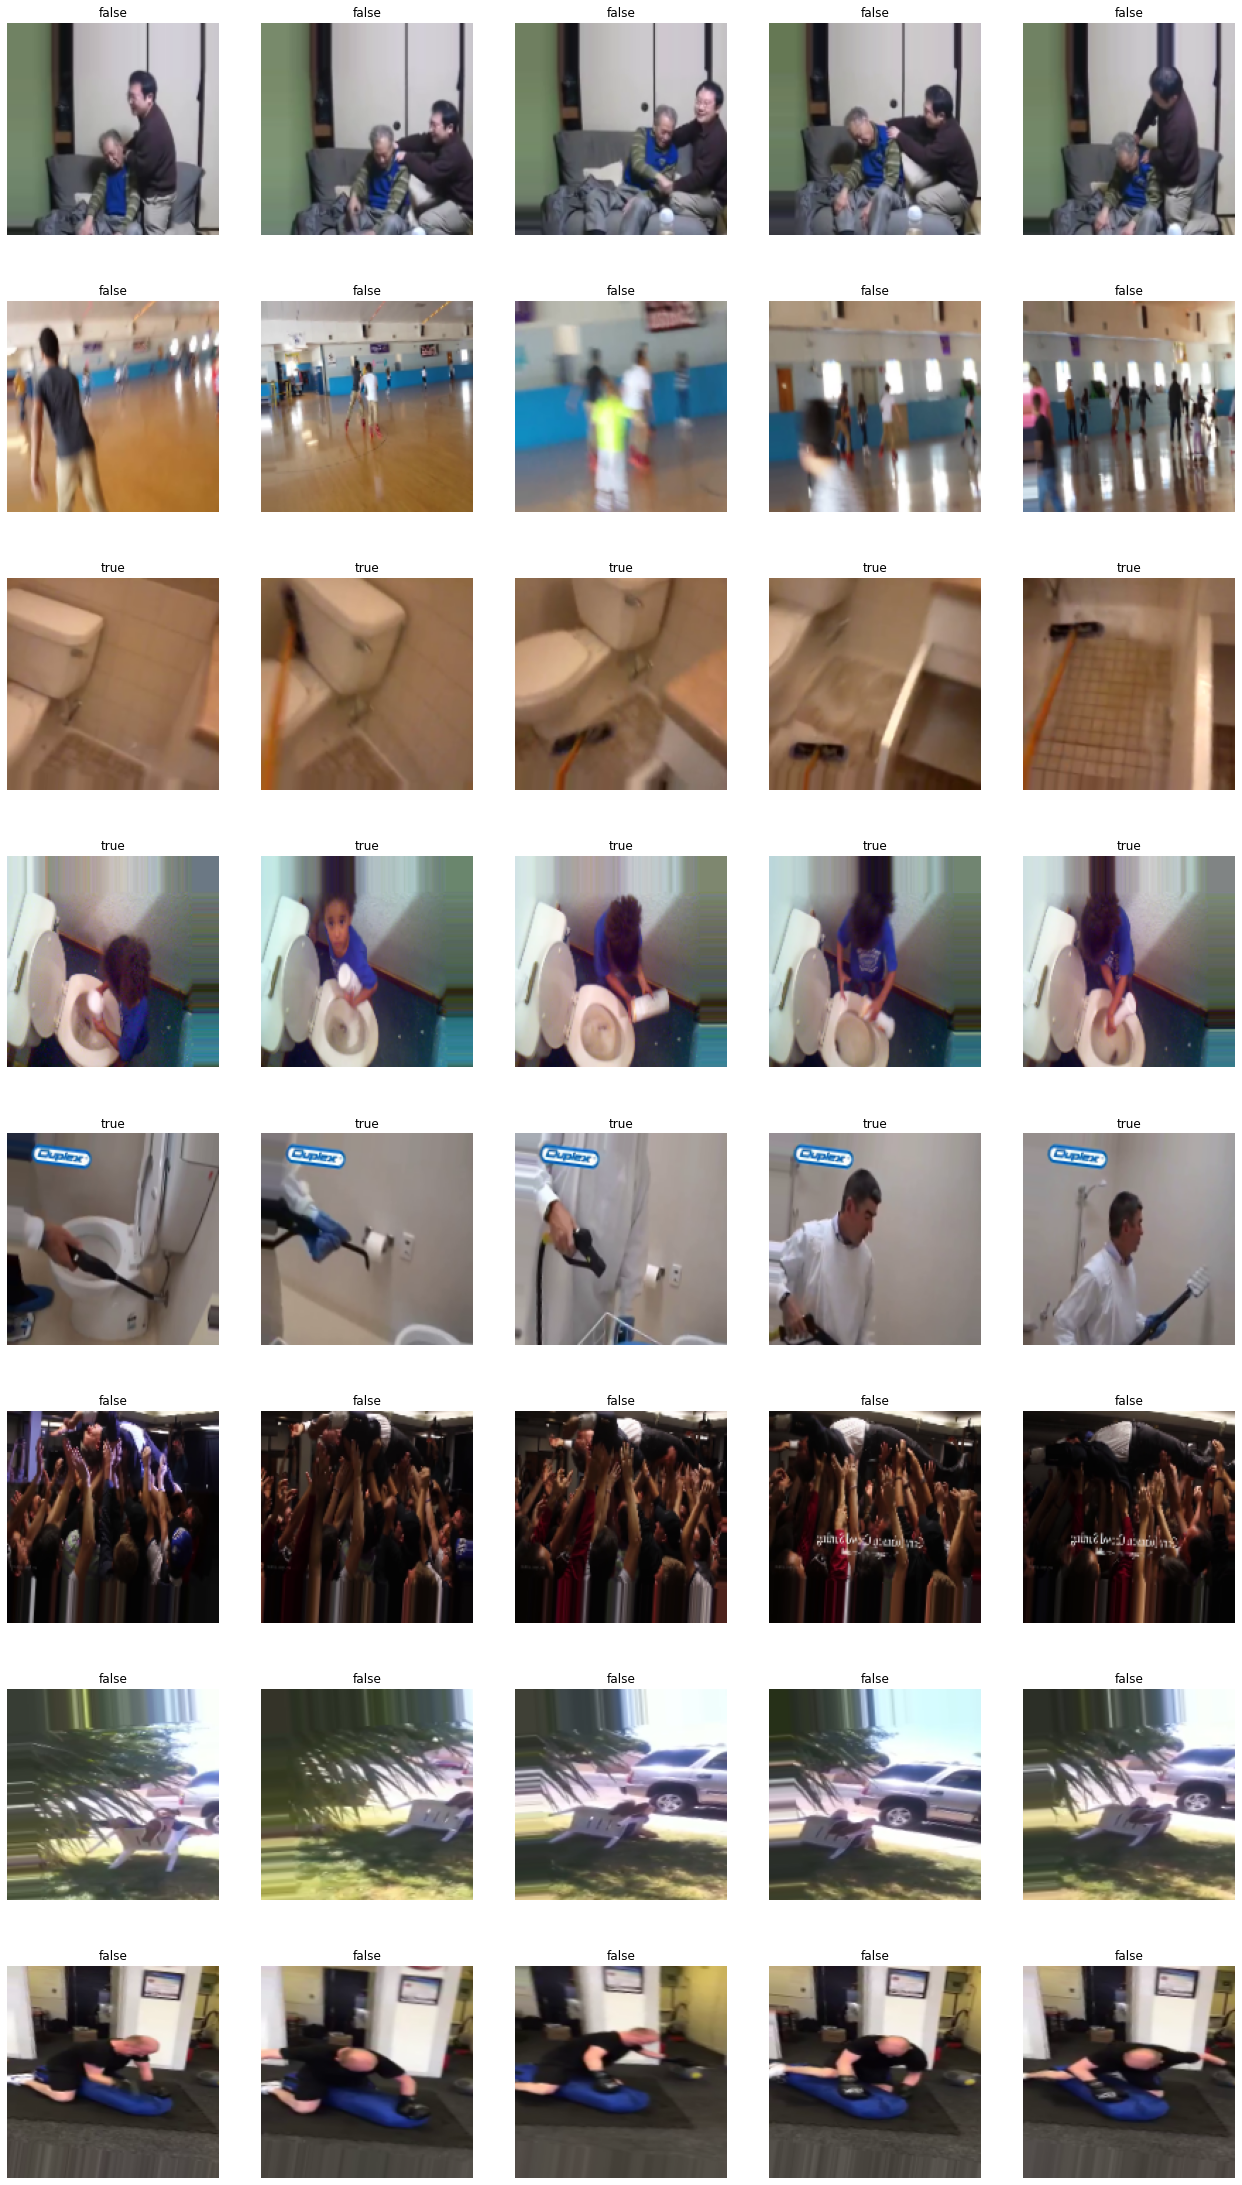

In [9]:
import keras_video.utils

keras_video.utils.show_sample(train)

Build my model

In [10]:
from keras.applications import VGG16
from keras.layers import TimeDistributed
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import GlobalMaxPool2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from keras.applications import Xception


In [11]:

conv_base = Xception(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
conv_base.trainable = False

def action_model(shape=(NBFRAME, 150, 150, 3), nbout=2):
    
    # Flatten output of conv_base
    mod = Sequential()
    mod.add(conv_base)
    mod.add(GlobalMaxPool2D())
    # Build our model for training
    model = Sequential()
    model.add(TimeDistributed(mod, input_shape=shape))
    # LSTM for time series
    model.add(LSTM(64))
    # Build the classifier
    # model.add(Dense(1024, activation='relu'))
    # model.add(Dropout(.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nbout, activation='sigmoid'))
    return model

INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,)
model = action_model(INSHAPE, len(classes))
model.summary()

83689472/83683744 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 5, 2048)           20861480  
_________________________________________________________________
lstm (LSTM)                  (None, 64)                540928    
_________________________________________________________________
dense (Dense)                (None, 512)               33280     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_______________________________________________________

In [12]:
from keras.optimizers import Adam

optimizer= Adam(0.0001)
model.compile(optimizer=optimizer , 
              loss='binary_crossentropy',
              metrics=['accuracy'])

Train

Try 1: split_val=.2, Adam(0.001), steps_per_epoch = 20, epochs=35, validation_steps=10, NBFRAME = 15
, BS = 15. ACCURACY: 72




Try 1: split_val=.2, Adam(0.0001), steps_per_epoch = 20, epochs=30, validation_steps=10, NBFRAME = 5
, BS = 8. ACCURACY: 74.7

try 3: lr = 0.001 LSTM

In [13]:
callbacks = [
    keras.callbacks.ReduceLROnPlateau(verbose=1),
    keras.callbacks.ModelCheckpoint(
                     filepath = 'cleaningbathroom_Xcep_sub6.h5',
                     monitor = 'val_loss',
                     save_best_only = True,
                 ),
]

history = model.fit(train,
                    steps_per_epoch = 30, #23 43
                    epochs=30, #can change
                   # batch_size=8,
                    callbacks=callbacks,
                    validation_data=val,
                    validation_steps=10)

Epoch 1/30
23/30 [======================>.......] - ETA: 19s - loss: 0.6920 - accuracy: 0.5202

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.137.mp4, 0 total, 0 extracted


30/30 [==============================] - ETA: 0s - loss: 0.6914 - accuracy: 0.5259

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.518.mp4, 0 total, 0 extracted


30/30 [==============================] - 138s 4s/step - loss: 0.6913 - accuracy: 0.5266 - val_loss: 0.6789 - val_accuracy: 0.5316
Epoch 2/30


Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.637.mp4, 2 total, 1 extracted


19/30 [==================>...........] - ETA: 29s - loss: 0.6683 - accuracy: 0.5820

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.705.mp4, 0 total, 0 extracted


30/30 [==============================] - ETA: 0s - loss: 0.6700 - accuracy: 0.5793

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.518.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.78.mp4, 0 total, 0 extracted


30/30 [==============================] - 101s 3s/step - loss: 0.6700 - accuracy: 0.5793 - val_loss: 0.6335 - val_accuracy: 0.6026
Epoch 3/30
 5/30 [====>.........................] - ETA: 45s - loss: 0.6998 - accuracy: 0.4550

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.555.mp4, 0 total, 0 extracted


 7/30 [======>.......................] - ETA: 51s - loss: 0.6951 - accuracy: 0.4815

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.220.mp4, 0 total, 0 extracted


30/30 [==============================] - 66s 2s/step - loss: 0.6582 - accuracy: 0.5817 - val_loss: 0.5747 - val_accuracy: 0.8375
Epoch 4/30


Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.555.mp4, 0 total, 0 extracted


12/30 [===========>..................] - ETA: 32s - loss: 0.5897 - accuracy: 0.7239

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.705.mp4, 0 total, 0 extracted


30/30 [==============================] - ETA: 0s - loss: 0.5765 - accuracy: 0.7643

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.518.mp4, 0 total, 0 extracted


30/30 [==============================] - 52s 2s/step - loss: 0.5758 - accuracy: 0.7655 - val_loss: 0.4657 - val_accuracy: 0.9114
Epoch 5/30
13/30 [============>.................] - ETA: 19s - loss: 0.4981 - accuracy: 0.8827

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.637.mp4, 2 total, 1 extracted


30/30 [==============================] - ETA: 0s - loss: 0.4902 - accuracy: 0.8659

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.142.mp4, 0 total, 0 extracted


30/30 [==============================] - 40s 1s/step - loss: 0.4896 - accuracy: 0.8655 - val_loss: 0.4209 - val_accuracy: 0.8500
Epoch 6/30
10/30 [=========>....................] - ETA: 17s - loss: 0.3992 - accuracy: 0.8692

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.142.mp4, 0 total, 0 extracted


14/30 [=============>................] - ETA: 14s - loss: 0.3938 - accuracy: 0.8751

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.220.mp4, 0 total, 0 extracted


15/30 [==============>...............] - ETA: 13s - loss: 0.3943 - accuracy: 0.8750

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.705.mp4, 0 total, 0 extracted


28/30 [===========================>..] - ETA: 1s - loss: 0.3945 - accuracy: 0.8710

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.637.mp4, 2 total, 1 extracted


30/30 [==============================] - ETA: 0s - loss: 0.3958 - accuracy: 0.8701

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.518.mp4, 0 total, 0 extracted


30/30 [==============================] - 31s 1s/step - loss: 0.3963 - accuracy: 0.8697 - val_loss: 0.2953 - val_accuracy: 0.9114
Epoch 7/30
19/30 [==================>...........] - ETA: 7s - loss: 0.3323 - accuracy: 0.8688

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.705.mp4, 0 total, 0 extracted


30/30 [==============================] - ETA: 0s - loss: 0.3290 - accuracy: 0.8736

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.78.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.518.mp4, 0 total, 0 extracted


30/30 [==============================] - 30s 991ms/step - loss: 0.3287 - accuracy: 0.8737 - val_loss: 0.2874 - val_accuracy: 0.8987
Epoch 8/30
26/30 [=========================>....] - ETA: 2s - loss: 0.3218 - accuracy: 0.9080

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.637.mp4, 2 total, 1 extracted


30/30 [==============================] - ETA: 0s - loss: 0.3183 - accuracy: 0.9084

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.518.mp4, 0 total, 0 extracted


30/30 [==============================] - 19s 624ms/step - loss: 0.3173 - accuracy: 0.9085 - val_loss: 0.1385 - val_accuracy: 0.9750
Epoch 9/30
20/30 [===================>..........] - ETA: 5s - loss: 0.2731 - accuracy: 0.8577

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.220.mp4, 0 total, 0 extracted


30/30 [==============================] - 21s 707ms/step - loss: 0.2747 - accuracy: 0.8614 - val_loss: 0.1892 - val_accuracy: 0.9250


Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.555.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.637.mp4, 2 total, 1 extracted


Epoch 10/30
13/30 [============>.................] - ETA: 6s - loss: 0.2825 - accuracy: 0.9012

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.705.mp4, 0 total, 0 extracted


30/30 [==============================] - ETA: 0s - loss: 0.2618 - accuracy: 0.9066

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.518.mp4, 0 total, 0 extracted


30/30 [==============================] - 16s 536ms/step - loss: 0.2613 - accuracy: 0.9067 - val_loss: 0.1775 - val_accuracy: 0.9367
Epoch 11/30


Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.220.mp4, 0 total, 0 extracted


 7/30 [======>.......................] - ETA: 8s - loss: 0.3453 - accuracy: 0.8633

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.637.mp4, 2 total, 1 extracted


30/30 [==============================] - ETA: 0s - loss: 0.2965 - accuracy: 0.8751

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.78.mp4, 0 total, 0 extracted


30/30 [==============================] - 15s 497ms/step - loss: 0.2954 - accuracy: 0.8756 - val_loss: 0.1761 - val_accuracy: 0.9114
Epoch 12/30


Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.705.mp4, 0 total, 0 extracted


13/30 [============>.................] - ETA: 6s - loss: 0.1648 - accuracy: 0.9754

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.142.mp4, 0 total, 0 extracted


30/30 [==============================] - ETA: 0s - loss: 0.1627 - accuracy: 0.9620

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.518.mp4, 0 total, 0 extracted


30/30 [==============================] - 13s 407ms/step - loss: 0.1623 - accuracy: 0.9618 - val_loss: 0.1236 - val_accuracy: 0.9620
Epoch 13/30
 2/30 [=>............................] - ETA: 5s - loss: 0.0876 - accuracy: 1.0000

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.555.mp4, 0 total, 0 extracted


 9/30 [========>.....................] - ETA: 6s - loss: 0.2702 - accuracy: 0.9393

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.705.mp4, 0 total, 0 extracted


10/30 [=========>....................] - ETA: 5s - loss: 0.2772 - accuracy: 0.9364

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.137.mp4, 0 total, 0 extracted


30/30 [==============================] - ETA: 0s - loss: 0.3148 - accuracy: 0.9055

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.142.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.78.mp4, 0 total, 0 extracted


30/30 [==============================] - 11s 376ms/step - loss: 0.3149 - accuracy: 0.9047 - val_loss: 0.1592 - val_accuracy: 0.9494
Epoch 14/30
17/30 [================>.............] - ETA: 3s - loss: 0.2325 - accuracy: 0.8834

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.220.mp4, 0 total, 0 extracted


22/30 [=====================>........] - ETA: 1s - loss: 0.2288 - accuracy: 0.8884

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/true/cleaning bathroom.271.mp4, 0 total, 0 extracted


26/30 [=========================>....] - ETA: 1s - loss: 0.2257 - accuracy: 0.8924

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.555.mp4, 0 total, 0 extracted


30/30 [==============================] - ETA: 0s - loss: 0.2219 - accuracy: 0.8961

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.518.mp4, 0 total, 0 extracted


30/30 [==============================] - 9s 307ms/step - loss: 0.2210 - accuracy: 0.8969 - val_loss: 0.2457 - val_accuracy: 0.8987
Epoch 15/30
10/30 [=========>....................] - ETA: 4s - loss: 0.1444 - accuracy: 0.9408

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/true/cleaning bathroom.271.mp4, 0 total, 0 extracted


30/30 [==============================] - ETA: 0s - loss: 0.2007 - accuracy: 0.9107

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.78.mp4, 0 total, 0 extracted


30/30 [==============================] - 8s 260ms/step - loss: 0.2021 - accuracy: 0.9101 - val_loss: 0.2159 - val_accuracy: 0.8987
Epoch 16/30
26/30 [=========================>....] - ETA: 1s - loss: 0.2136 - accuracy: 0.9231

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.637.mp4, 2 total, 1 extracted


30/30 [==============================] - 10s 317ms/step - loss: 0.2193 - accuracy: 0.9194 - val_loss: 0.1878 - val_accuracy: 0.9000
Epoch 17/30
 3/30 [==>...........................] - ETA: 8s - loss: 0.0985 - accuracy: 0.9653 

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.637.mp4, 2 total, 1 extracted


27/30 [==========================>...] - ETA: 0s - loss: 0.2216 - accuracy: 0.9129

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.555.mp4, 0 total, 0 extracted


29/30 [============================>.] - ETA: 0s - loss: 0.2218 - accuracy: 0.9127

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/true/cleaning bathroom.271.mp4, 0 total, 0 extracted


30/30 [==============================] - ETA: 0s - loss: 0.2218 - accuracy: 0.9126

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.518.mp4, 0 total, 0 extracted


30/30 [==============================] - 8s 273ms/step - loss: 0.2218 - accuracy: 0.9126 - val_loss: 0.1594 - val_accuracy: 0.9494
Epoch 18/30
 2/30 [=>............................] - ETA: 5s - loss: 0.1240 - accuracy: 0.9688

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.142.mp4, 0 total, 0 extracted


13/30 [============>.................] - ETA: 3s - loss: 0.1551 - accuracy: 0.9457

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/true/cleaning bathroom.271.mp4, 0 total, 0 extracted


19/30 [==================>...........] - ETA: 2s - loss: 0.1625 - accuracy: 0.9421

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.137.mp4, 0 total, 0 extracted


30/30 [==============================] - ETA: 0s - loss: 0.1686 - accuracy: 0.9366

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.78.mp4, 0 total, 0 extracted


30/30 [==============================] - 7s 227ms/step - loss: 0.1689 - accuracy: 0.9364 - val_loss: 0.1885 - val_accuracy: 0.9367
Epoch 19/30
30/30 [==============================] - 7s 227ms/step - loss: 0.2702 - accuracy: 0.8959 - val_loss: 0.2139 - val_accuracy: 0.9375
Epoch 20/30
 7/30 [======>.......................] - ETA: 4s - loss: 0.2302 - accuracy: 0.9175

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.637.mp4, 2 total, 1 extracted


30/30 [==============================] - ETA: 0s - loss: 0.2013 - accuracy: 0.9319

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.78.mp4, 0 total, 0 extracted


30/30 [==============================] - 7s 225ms/step - loss: 0.2015 - accuracy: 0.9318 - val_loss: 0.2025 - val_accuracy: 0.9367
Epoch 21/30
 4/30 [===>..........................] - ETA: 15s - loss: 0.1818 - accuracy: 0.9323

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.637.mp4, 2 total, 1 extracted


30/30 [==============================] - ETA: 0s - loss: 0.2066 - accuracy: 0.9243

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.518.mp4, 0 total, 0 extracted


30/30 [==============================] - 8s 280ms/step - loss: 0.2075 - accuracy: 0.9237 - val_loss: 0.1020 - val_accuracy: 0.9494
Epoch 22/30
 8/30 [=======>......................] - ETA: 4s - loss: 0.2000 - accuracy: 0.9097

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/true/cleaning bathroom.271.mp4, 0 total, 0 extracted


21/30 [====================>.........] - ETA: 1s - loss: 0.1690 - accuracy: 0.9292

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.137.mp4, 0 total, 0 extracted


30/30 [==============================] - 7s 228ms/step - loss: 0.1634 - accuracy: 0.9347 - val_loss: 0.1645 - val_accuracy: 0.9250
Epoch 23/30
30/30 [==============================] - 7s 228ms/step - loss: 0.1305 - accuracy: 0.9511 - val_loss: 0.3019 - val_accuracy: 0.9125
Epoch 24/30
18/30 [=================>............] - ETA: 2s - loss: 0.2096 - accuracy: 0.9097

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/true/cleaning bathroom.271.mp4, 0 total, 0 extracted


30/30 [==============================] - 7s 226ms/step - loss: 0.1837 - accuracy: 0.9227 - val_loss: 0.2399 - val_accuracy: 0.9250
Epoch 25/30
13/30 [============>.................] - ETA: 3s - loss: 0.1432 - accuracy: 0.9321

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/true/cleaning bathroom.271.mp4, 0 total, 0 extracted


27/30 [==========================>...] - ETA: 0s - loss: 0.1456 - accuracy: 0.9338

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.705.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.137.mp4, 0 total, 0 extracted


30/30 [==============================] - 8s 242ms/step - loss: 0.1477 - accuracy: 0.9329 - val_loss: 0.1691 - val_accuracy: 0.9250
Epoch 26/30
 2/30 [=>............................] - ETA: 5s - loss: 0.1129 - accuracy: 0.9688

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.220.mp4, 0 total, 0 extracted


 4/30 [===>..........................] - ETA: 5s - loss: 0.1095 - accuracy: 0.9654

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.555.mp4, 0 total, 0 extracted


30/30 [==============================] - 7s 225ms/step - loss: 0.1490 - accuracy: 0.9566 - val_loss: 0.1116 - val_accuracy: 0.9625
Epoch 27/30
16/30 [===============>..............] - ETA: 2s - loss: 0.1376 - accuracy: 0.9413

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.555.mp4, 0 total, 0 extracted


19/30 [==================>...........] - ETA: 2s - loss: 0.1334 - accuracy: 0.9428

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.705.mp4, 0 total, 0 extracted


30/30 [==============================] - ETA: 0s - loss: 0.1217 - accuracy: 0.9475

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.518.mp4, 0 total, 0 extracted


30/30 [==============================] - 7s 225ms/step - loss: 0.1208 - accuracy: 0.9479 - val_loss: 0.1964 - val_accuracy: 0.9367
Epoch 28/30
 2/30 [=>............................] - ETA: 6s - loss: 0.0243 - accuracy: 1.0000

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.555.mp4, 0 total, 0 extracted


16/30 [===============>..............] - ETA: 2s - loss: 0.0520 - accuracy: 0.9841

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.705.mp4, 0 total, 0 extracted


30/30 [==============================] - 7s 224ms/step - loss: 0.0746 - accuracy: 0.9749 - val_loss: 0.1521 - val_accuracy: 0.9625
Epoch 29/30
25/30 [========================>.....] - ETA: 1s - loss: 0.0822 - accuracy: 0.9821

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/true/cleaning bathroom.271.mp4, 0 total, 0 extracted


30/30 [==============================] - ETA: 0s - loss: 0.0914 - accuracy: 0.9776

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.78.mp4, 0 total, 0 extracted


30/30 [==============================] - 7s 224ms/step - loss: 0.0927 - accuracy: 0.9770 - val_loss: 0.0524 - val_accuracy: 0.9873
Epoch 30/30
13/30 [============>.................] - ETA: 3s - loss: 0.1614 - accuracy: 0.9491

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/train/false/not cleaning bathroom.637.mp4, 2 total, 1 extracted


30/30 [==============================] - 7s 226ms/step - loss: 0.1659 - accuracy: 0.9434 - val_loss: 0.2556 - val_accuracy: 0.9125


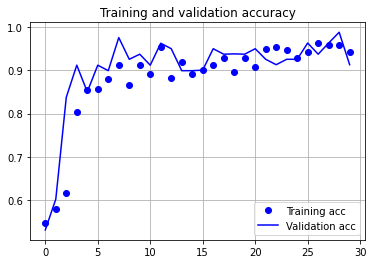

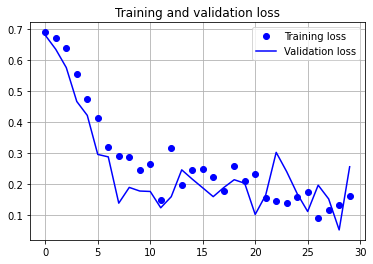

In [14]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.grid(axis='both')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.grid(axis='both')
plt.legend()

plt.show()

In [15]:
import keras
import keras_video.utils
from keras_video import VideoFrameGenerator

classes = ['true' , 'false']
SIZE = (150, 150)
CHANNELS = 3
NBFRAME = 5
BS = 8
glob_pattern='/content/cleaningbathroom/content/kinetics700/test/{classname}/*.mp4'

# make video frame generator
test = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_pattern,
    nb_frames=NBFRAME,
    shuffle=False,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    use_frame_cache=True)

Total data: 2 classes for 89 files for train


In [16]:
model.evaluate(test)

 6/11 [===============>..............] - ETA: 17s - loss: 0.1368 - accuracy: 0.9583

Frame count is not OK for video /content/cleaningbathroom/content/kinetics700/test/true/cleaning bathroom.28.mp4, 0 total, 0 extracted


11/11 [==============================] - 30s 3s/step - loss: 0.1142 - accuracy: 0.9655


[0.11424462497234344, 0.9655172228813171]

In [17]:
!cp -a '/content/cleaningbathroom_Xcep_sub6.h5' '/content/drive/MyDrive/Colab Notebooks/Submission 6'